In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scikitplot as skplt
import sklearn
from sklearn.model_selection import train_test_split
import os

# Normal vs Malignant Heatmap

In [2]:
data_info = pd.read_csv(r'A:\MSc\Pulmonary Nodules\sameslicethickness\arranged\arranged_info.csv')

In [3]:
target = 'nodule_diameter'
n = np.unique(np.array(data_info['nodule_diameter'])).shape[0]
nodule_diameters = np.unique(np.array(data_info['nodule_diameter']))
print(f'there are {n} different nodule diameters')

there are 292 different nodule diameters


## Helper functions

In [2]:
def get_noduleD_r_nSamples(malignancy_score):
    radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    noduleD_r_nSamples = {}
    small_d = [0, 10, 20, 30, 40 ] # mm
    large_d = [10, 20, 30, 40, 60] # mm
    # number of nodules that ranges from 50 to 60 is too small to determine accuracy.

    for r in radii:
        noduleD_r_nSamples[f'r{r}'] = {}
        for d1, d2 in zip(small_d, large_d):
            data_df = data_info.loc[data_info['nodule_diameter'] > d1].loc[data_info['nodule_diameter'] <= d2].loc[
                data_info['malignancy_score']==malignancy_score].loc[data_info['radius'] == r]
            n_samples = 0
            for vname in list(data_df['volume']):
                n_samples += 1
            noduleD_r_nSamples[f'r{r}'][f'{d1}  < d <= {d2}'] = n_samples
    return pd.DataFrame(noduleD_r_nSamples)

def create_v_path(r, l, vn):
    path = f'A:/MSc/Pulmonary Nodules/sameslicethickness/arranged/radius_{r}/level_{l}/' + vn + '.npy'
    return path

def get_vn(vname):
    return int(vname.split('v')[-1])

def normalize_volume(volume):
    return (volume-volume.min())/(volume.max()-volume.min())

def test_data_prep(data, labels, BATCH_SIZE = 16):
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def load_data(df, malignancy_score, c):
    h, w, d = (64, 64, 28)
    data = []
    label = []
    vs = list(df['volume'])
    rs = list(df['radius'])
    for v, r in zip(vs, rs):
        if  get_vn(v) > 1000: # to get samples from testing data only
            data.append(normalize_volume(np.load(create_v_path(int(r), malignancy_score, v))).reshape(h,w,d,1))
            label.append(c)
            if len(data) > 100:
                break
    dataset = test_data_prep(data, label, 16)
    return dataset

## number of malignant | benign nodules vs nodule diameter

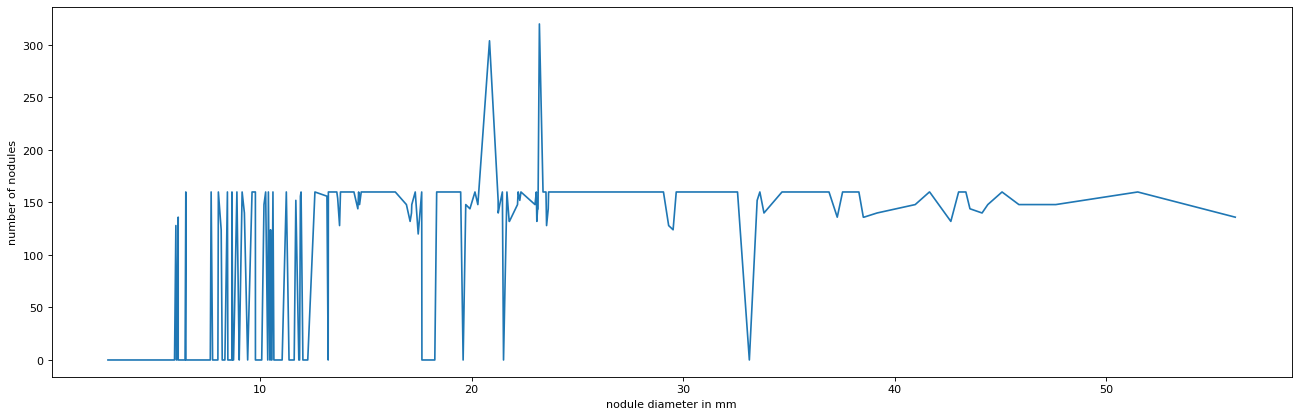

In [65]:
# getting number of malignant nodules that has a certain size
size_n_nodules = []
for size in nodule_diameters:
    n_nodules = len(data_info.loc[data_info['nodule_diameter'] == size].loc[data_info['malignancy_score']==5])
    size_n_nodules.append([size, n_nodules])
size_n_nodules = np.array(size_n_nodules)
plt.figure(figsize=(20, 6), dpi=80)
plt.xlabel('nodule diameter in mm')
plt.ylabel('number of nodules')
plt.plot(size_n_nodules[:,0], size_n_nodules[:,1])

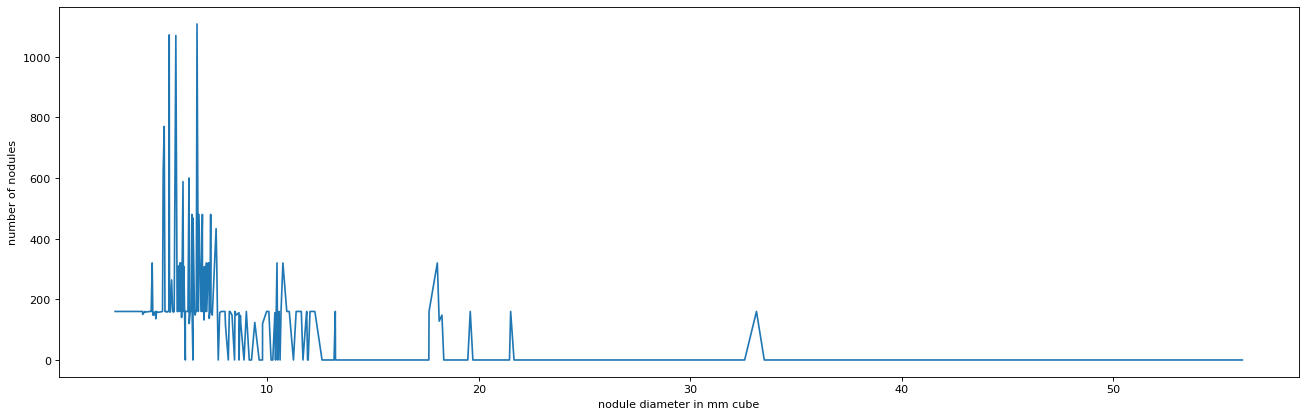

In [66]:
# getting number of benign nodules that has a certain size
size_n_nodules = []
for size in nodule_diameters:
    n_nodules = len(data_info.loc[data_info['nodule_diameter'] == size].loc[data_info['malignancy_score']==1])
    size_n_nodules.append([size, n_nodules])
size_n_nodules = np.array(size_n_nodules)
plt.figure(figsize=(20, 6), dpi=80)
plt.xlabel('nodule diameter in mm cube')
plt.ylabel('number of nodules')
plt.plot(size_n_nodules[:,0], size_n_nodules[:,1])

## Group per diameter and test

### Number of samples per group (All)

In [49]:
malignancy_score = 5
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
noduleD_r_nSamples = {}
results = {}
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
# number of nodules that ranges from 50 to 60 is too small to determine accuracy.

for r in radii:
    noduleD_r_nSamples[f'r{r}'] = {}
    for d1, d2 in zip(small_d, large_d):
        data_df = data_info.loc[data_info['nodule_diameter'] > d1].loc[data_info['nodule_diameter'] <= d2].loc[
            data_info['malignancy_score']==malignancy_score].loc[data_info['radius'] == r]
        n_samples = 0
        for vname in list(data_df['volume']):
            n_samples += 1
        noduleD_r_nSamples[f'r{r}'][f'{d1}  < d <= {d2}'] = n_samples

In [50]:
pd.DataFrame(noduleD_r_nSamples)

r5  r10  r15  r20  r25  r30  r35  r40  r45  r50
0  < d <= 10   208  204  200  200  196  192  192  192  192  192
10  < d <= 20  880  876  876  864  864  860  852  826  822  810
20  < d <= 30  768  768  768  744  744  740  728  712  692  684
30  < d <= 40  416  416  416  416  404  396  396  396  392  392
40  < d <= 60  224  224  224  220  216  212  208  192  192  192

### Number of samples per group (Training)

In [51]:
malignancy_score = 5
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
noduleD_r_nSamples = {}
results = {}
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
# number of nodules that ranges from 50 to 60 is too small to determine accuracy.

for r in radii:
    noduleD_r_nSamples[f'r{r}'] = {}
    for d1, d2 in zip(small_d, large_d):
        data_df = data_info.loc[data_info['nodule_diameter'] > d1].loc[data_info['nodule_diameter'] <= d2].loc[
            data_info['malignancy_score']==malignancy_score].loc[data_info['radius'] == r]
        n_samples = 0
        for vname in list(data_df['volume']):
            if get_vn(vname) < 1000:
                n_samples += 1
        noduleD_r_nSamples[f'r{r}'][f'{d1}  < d <= {d2}'] = n_samples

In [52]:
pd.DataFrame(noduleD_r_nSamples)

r5  r10  r15  r20  r25  r30  r35  r40  r45  r50
0  < d <= 10    48   48   48   48   48   44   50   56   56   60
10  < d <= 20  508  508  508  509  512  515  512  504  500  488
20  < d <= 30  368  368  368  366  367  367  363  363  365  371
30  < d <= 40   57   57   57   57   57   57   57   57   57   57
40  < d <= 60   19   19   19   20   16   17   18   20   22   24

### Number of samples per group (testing)

In [5]:
malignancy_score = 5
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
noduleD_r_nSamples = {}
results = {}
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
# number of nodules that ranges from 50 to 60 is too small to determine accuracy.

for r in radii:
    noduleD_r_nSamples[f'r{r}'] = {}
    for d1, d2 in zip(small_d, large_d):
        data_df = data_info.loc[data_info['nodule_diameter'] > d1].loc[data_info['nodule_diameter'] <= d2].loc[
            data_info['malignancy_score']==malignancy_score].loc[data_info['radius'] == r]
        n_samples = 0
        for vname in list(data_df['volume']):
            if get_vn(vname) > 1000:
                n_samples += 1
        noduleD_r_nSamples[f'r{r}'][f'{d1}  < d <= {d2}'] = n_samples

In [6]:
pd.DataFrame(noduleD_r_nSamples)

r5  r10  r15  r20  r25  r30  r35  r40  r45  r50
0  < d <= 10   160  156  152  152  148  148  141  136  136  131
10  < d <= 20  372  368  368  354  352  344  340  322  322  322
20  < d <= 30  399  399  399  378  377  373  365  348  326  313
30  < d <= 40  359  359  359  359  347  339  339  339  335  335
40  < d <= 60  205  205  205  200  199  195  190  172  170  168

### Test

#### All at once

In [7]:
malignancy_score = 5
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = {}
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
# number of nodules that ranges from 50 to 60 is too small to determine accuracy.
models_path = r'A:\\MSc\\Pulmonary Nodules\\models\\'
models = ['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50']
for m_name in tqdm(models, total = len(models)):
    results[m_name] = {}
    _path = models_path + m_name
    m = tf.keras.models.load_model(_path)
    for r in tqdm(radii, total = len(radii)):
        results[m_name][f'r{r}'] = {}
        for d1, d2 in zip(small_d, large_d):
            data_df = data_info.loc[data_info['nodule_diameter'] > d1].loc[data_info['nodule_diameter'] <= d2].loc[
                data_info['malignancy_score']==malignancy_score].loc[data_info['radius'] == r]
            test_data = load_data(data_df, malignancy_score, 1)
            accuracy = m.evaluate(test_data)
            results[m_name][f'r{r}'][f'{d1}  < d <= {d2}'] = accuracy[1]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 1s 98ms/step - loss: 5.9711 - accuracy: 0.6436


  0%|          | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 1s 97ms/step - loss: 3.6585 - accuracy: 0.6535


  0%|          | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 1s 96ms/step - loss: 2.5578 - accuracy: 0.6238


  0%|          | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 1s 97ms/step - loss: 0.4681 - accuracy: 0.9406


  0%|          | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 1s 96ms/step - loss: 1.8861 - accuracy: 0.8218


In [53]:
target = 'normal_vs_malignant_r10'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df, cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

KeyError: 'normal_vs_malignant_r10'

The model here is trained to capture changes of tissue nearby the malignant nodule (till r10). Generally, there is an increasing trend in the model ability to detect malignancy starting from r30 while approaching r5 in each row. Tiny nodules (0 < d <= 10) appear to affect nearer surronding tissue till r20 more significantly than further tissue. Which means that the inflammation did not spread widely. However, larger nodules (10 < d <= 30) have a larger effect that is detectable till r50. The biggest nodules (30 < d <= 60) results do not confirm the pattern that appear in other results. After investigation, it was found that number of training examples that contained this size is 3.5% of total training dataset. This indicates that large nodules effect on tissue is different from medium or small nodules, which confused the model and could capture the expected features that usually appear in smaller volumes. To overcome such a problem, distribution between different sizes should be taken into consideration while preparing training dataset to accurately sample the overall distribution.

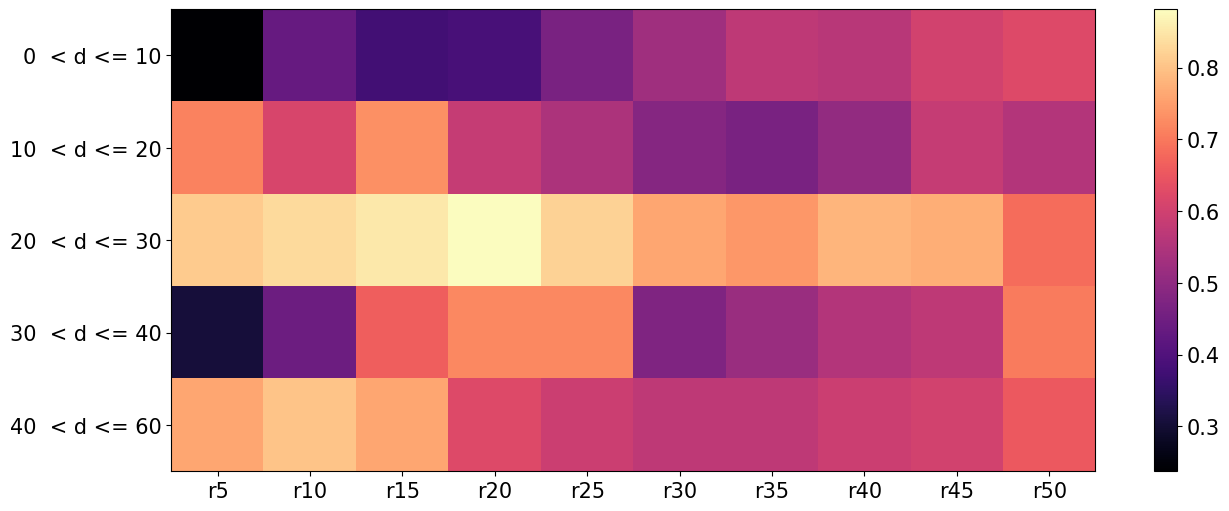

In [45]:
target = 'normal_vs_malignant_r20'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df, cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

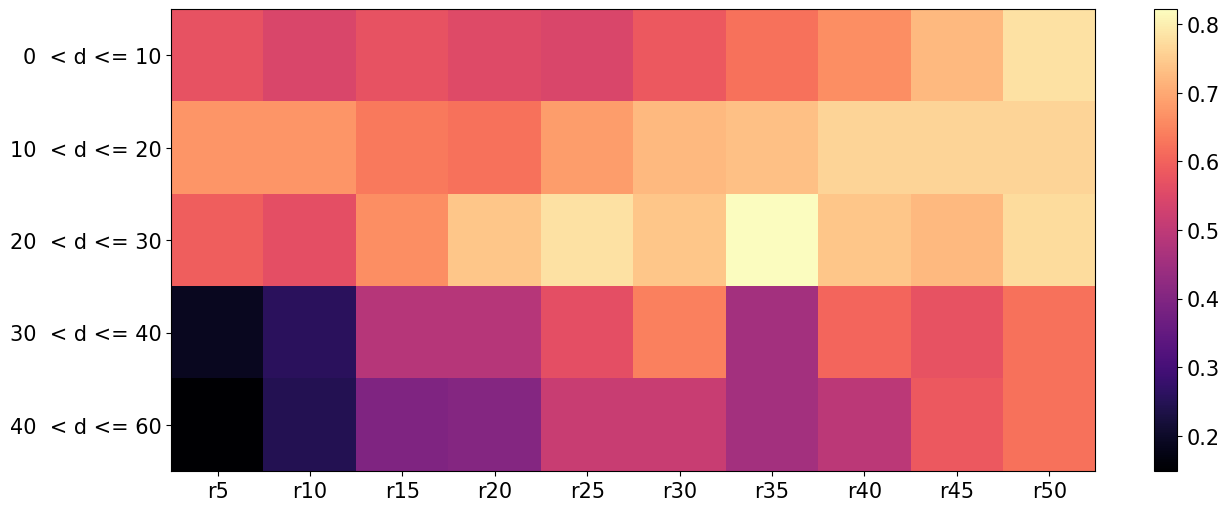

In [46]:
target = 'normal_vs_malignant_r30'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df, cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

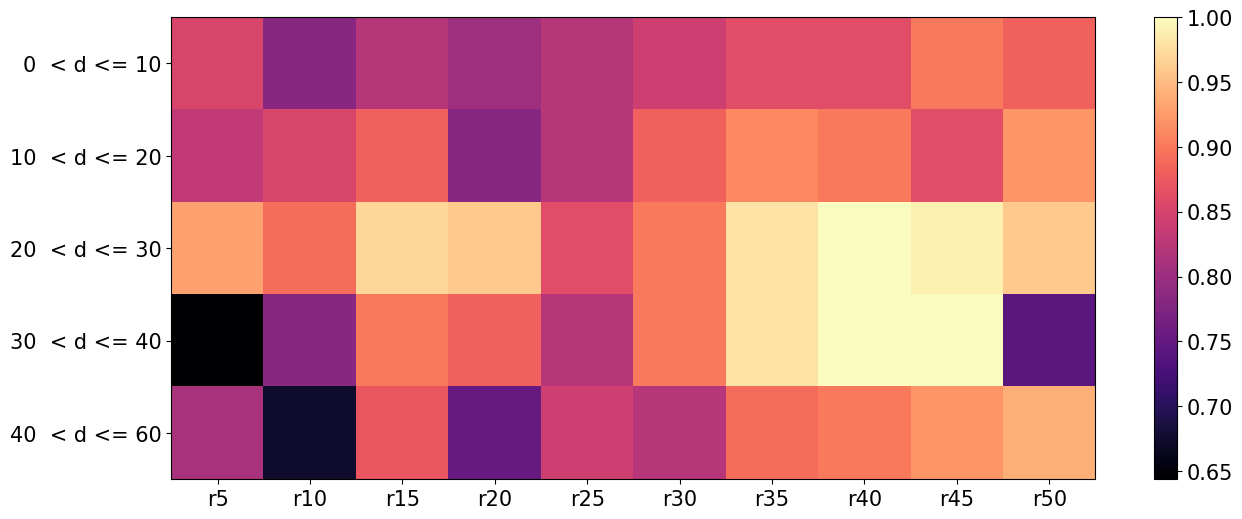

In [47]:
target = 'normal_vs_malignant_r40'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df, cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

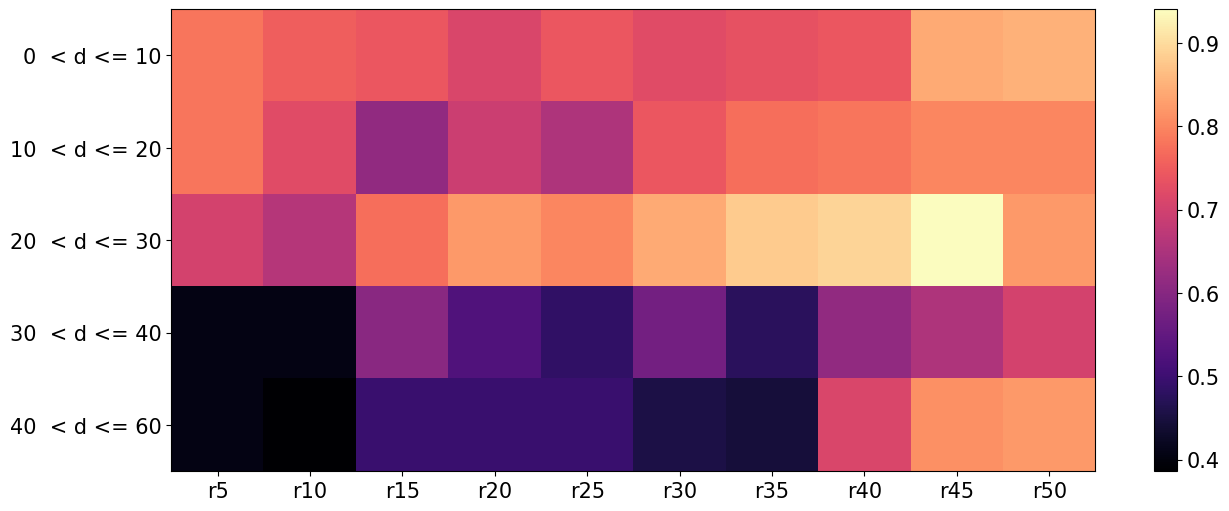

In [48]:
target = 'normal_vs_malignant_r50'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df, cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

# Test Different Grades

## Helper functions

In [64]:
def load_data(df, malignancy_score, c, number_of_samples_per_axis_parameter = 25, sizes=None, radius=None):
    h, w, d = (64, 64, 28)
    data = []
    label = []
    
    if radius == 'all_radii' and sizes == 'all_sizes':
        small_d = [0, 10, 20, 30, 40 ] # mm
        large_d = [10, 20, 30, 40, 60] # mm
        dfs = []
        final_dfs = []
        for d1, d2 in zip(small_d, large_d):
            dfs.append(df.loc[df['nodule_diameter'] > d1].loc[df['nodule_diameter'] <= d2])
        
        radii = [5,10,15,20,25,30,35,40,45,50]
        for df in dfs:
            for rad in radii:
                final_dfs.append(df.loc[df['radius'] == rad])
        
        test_dfs = []
        for i in range(5):
            test_dfs.append(pd.concat(final_dfs[i:i+10]).sample(frac=1))
        if len(test_dfs) == 5:
            print('3ash ya paytor')
        for s, df_sample in zip([1,2,3,4,5], test_dfs):
            vs = list(df_sample['volume'])
            rs = list(df_sample['radius'])  
            for v, r in zip(vs, rs):
                if malignancy_score in [1, 5]:
                    if  get_vn(v) > 1000:
                        data.append(normalize_volume(np.load(create_v_path(int(r), malignancy_score, v))).reshape(h,w,d,1))
                        label.append(1)
                else :
                    data.append(normalize_volume(np.load(create_v_path(int(r), malignancy_score, v))).reshape(h,w,d,1))
                    label.append(1)
                if len(data) >= s * number_of_samples_per_axis_parameter * 2:
                    break
        dataset = test_data_prep(data, label, 16)
        return dataset
        
    
    if malignancy_score == 'all': # for reduction along score axis
        dfs = []
        for s in [1,2,3,4,5]:
            dfs.append(df.loc[df['malignancy_score'] == s])
        for s, df_sample in zip([1,2,3,4,5], dfs):
            vs = list(df_sample['volume'])
            rs = list(df_sample['radius'])  
            for v, r in zip(vs, rs):
                if s in [1, 5]:
                    if  get_vn(v) > 1000:
                        data.append(normalize_volume(np.load(create_v_path(int(r), s, v))).reshape(h,w,d,1))
                        label.append(1)
                else :
                    data.append(normalize_volume(np.load(create_v_path(int(r), s, v))).reshape(h,w,d,1))
                    label.append(1)
                if len(data) >= s * number_of_samples_per_axis_parameter:
                    break
        dataset = test_data_prep(data, label, 16)
        return dataset
    
    if sizes == 'all': # for reduction along size axis
        small_d = [0, 10, 20, 30, 40 ] # mm
        large_d = [10, 20, 30, 40, 60] # mm
        dfs = []
        for d1, d2 in zip(small_d, large_d):
            dfs.append(df.loc[df['nodule_diameter'] > d1].loc[df['nodule_diameter'] <= d2])
        for s, df_sample in zip([1,2,3,4,5], dfs):
            vs = list(df_sample['volume'])
            rs = list(df_sample['radius'])  
            for v, r in zip(vs, rs):
                if malignancy_score in [1, 5]:
                    if  get_vn(v) > 1000:
                        data.append(normalize_volume(np.load(create_v_path(int(r), malignancy_score, v))).reshape(h,w,d,1))
                        label.append(1)
                else :
                    data.append(normalize_volume(np.load(create_v_path(int(r), malignancy_score, v))).reshape(h,w,d,1))
                    label.append(1)
                if len(data) >= s * number_of_samples_per_axis_parameter:
                    break
        dataset = test_data_prep(data, label, 16)
        return dataset
    
    if radius == 'all': # for reduction along radius axis
        dfs = []
        radii = [5,10,15,20,25,30,35,40,45,50]
        for rad in radii:
            dfs.append(df.loc[df['radius'] == rad])
        for s, df_sample in zip(range(1,11), dfs):
            vs = list(df_sample['volume'])
            rs = list(df_sample['radius'])  
            for v, r in zip(vs, rs):
                if malignancy_score in [1, 5]:
                    if  get_vn(v) > 1000:
                        data.append(normalize_volume(np.load(create_v_path(int(r), malignancy_score, v))).reshape(h,w,d,1))
                        label.append(1)
                else :
                    data.append(normalize_volume(np.load(create_v_path(int(r), malignancy_score, v))).reshape(h,w,d,1))
                    label.append(1)
                if len(data) >= s * number_of_samples_per_axis_parameter:
                    break
        dataset = test_data_prep(data, label, 16)
        return dataset
        
    vs = list(df['volume'])
    rs = list(df['radius'])        
    for v, r in zip(vs, rs):
        if malignancy_score in [1, 5]:
            if  get_vn(v) > 1000:
                data.append(normalize_volume(np.load(create_v_path(int(r), malignancy_score, v))).reshape(h,w,d,1))
                label.append(c)
                if len(data) > 100:
                    break
        else :
            data.append(normalize_volume(np.load(create_v_path(int(r), malignancy_score, v))).reshape(h,w,d,1))
            label.append(c)
            if len(data) > 100:
                break
    dataset = test_data_prep(data, label, 16)
    return dataset

In [29]:
data_info = pd.read_csv(r'A:\MSc\Pulmonary Nodules\sameslicethickness\arranged\arranged_info_levels234.csv')

In [30]:
target = 'nodule_diameter'
n = np.unique(np.array(data_info['nodule_diameter'])).shape[0]
nodule_diameters = np.unique(np.array(data_info['nodule_diameter']))
print(f'there are {n} different nodule diameters')

there are 895 different nodule diameters


## number of samples per diameter

In [4]:
get_noduleD_r_nSamples(malignancy_score = 2)

r5  r10  r15  r20  r25  r30  r35  r40  r45  r50
0  < d <= 10   295  295  295  295  295  295  295  295  295  295
10  < d <= 20   73   73   73   73   73   73   73   73   73   73
20  < d <= 30   10   10   10   10   10   10   10   10   10   10
30  < d <= 40    2    2    2    2    2    2    2    2    2    2
40  < d <= 60    0    0    0    0    0    0    0    0    0    0

In [7]:
get_noduleD_r_nSamples(malignancy_score = 3)

r5  r10  r15  r20  r25  r30  r35  r40  r45  r50
0  < d <= 10   424  424  424  424  424  424  424  424  424  424
10  < d <= 20  149  149  149  149  149  149  149  149  149  149
20  < d <= 30   17   17   17   17   17   17   17   17   17   17
30  < d <= 40    5    5    5    5    5    5    5    5    5    5
40  < d <= 60    0    0    0    0    0    0    0    0    0    0

In [8]:
get_noduleD_r_nSamples(malignancy_score = 4)

r5  r10  r15  r20  r25  r30  r35  r40  r45  r50
0  < d <= 10   101  101  101  101  101  101  101  101  101  101
10  < d <= 20  106  106  106  106  106  106  106  106  106  106
20  < d <= 30   18   18   18   18   18   18   18   18   18   18
30  < d <= 40    8    8    8    8    8    8    8    8    8    8
40  < d <= 60    1    1    1    1    1    1    1    1    1    1

## Heatmap Generation

### Malignancy level = 2

In [31]:
malignancy_score = 2
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = {}
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
# number of nodules that ranges from 50 to 60 is too small to determine accuracy.
models_path = r'A:\\MSc\\Pulmonary Nodules\\models\\'
models = ['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50']
for m_name in tqdm(models, total = len(models)):
    results[m_name] = {}
    _path = models_path + m_name
    m = tf.keras.models.load_model(_path)
    for r in tqdm(radii, total = len(radii)):
        results[m_name][f'r{r}'] = {}
        for d1, d2 in zip(small_d, large_d):
            data_df = data_info.loc[data_info['nodule_diameter'] > d1].loc[data_info['nodule_diameter'] <= d2].loc[
                data_info['malignancy_score']==malignancy_score].loc[data_info['radius'] == r]
            test_data = load_data(data_df, malignancy_score, 1)
            if len(test_data) == 0:
                results[m_name][f'r{r}'][f'{d1}  < d <= {d2}'] = 'no samples'
                continue
            accuracy = m.evaluate(test_data)
            results[m_name][f'r{r}'][f'{d1}  < d <= {d2}'] = accuracy[1]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step - loss: 5.9311e-06 - accuracy: 1.0000


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0115 - accuracy: 1.0000


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0054 - accuracy: 1.0000


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step - loss: 3.9144e-07 - accuracy: 1.0000


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.2178 - accuracy: 1.0000


In [35]:
df = pd.DataFrame(results[target])
df[:-1]

r5       r10       r15       r20       r25       r30  \
0  < d <= 10   0.691525  0.684746   0.59661  0.566102  0.616949  0.613559   
10  < d <= 20  0.726027  0.726027  0.684932  0.506849  0.547945  0.589041   
20  < d <= 30       0.8       0.8       0.5       0.5       0.5       0.7   
30  < d <= 40       1.0       1.0       1.0       0.0       0.5       0.5   

                    r35       r40       r45       r50  
0  < d <= 10   0.633898  0.667797  0.674576  0.742373  
10  < d <= 20  0.589041  0.630137  0.684932  0.712329  
20  < d <= 30       0.4       0.5       0.5       0.8  
30  < d <= 40       0.5       0.5       0.0       1.0

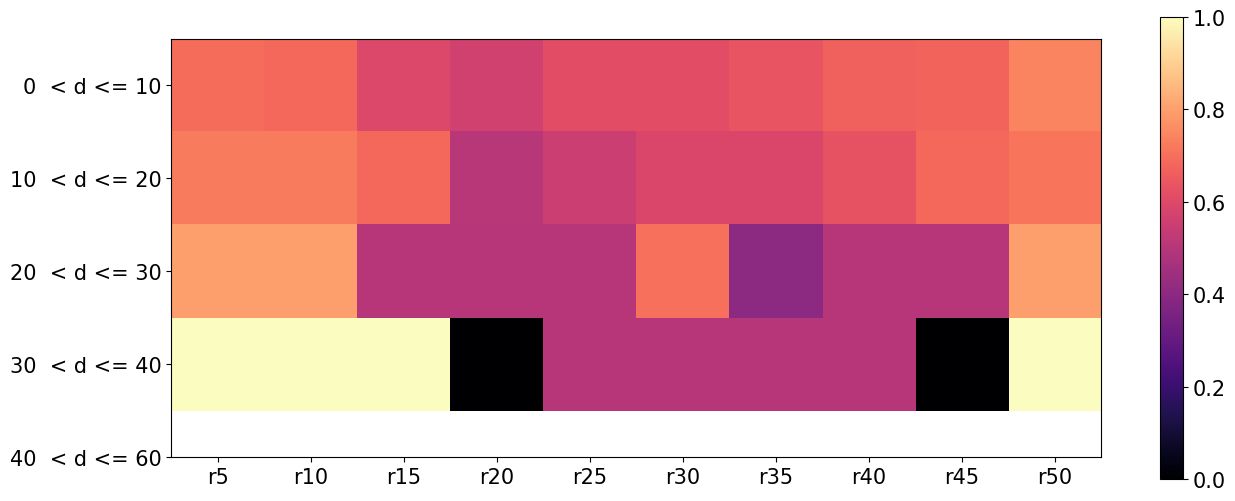

In [37]:
target = 'normal_vs_malignant_r10'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_2_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

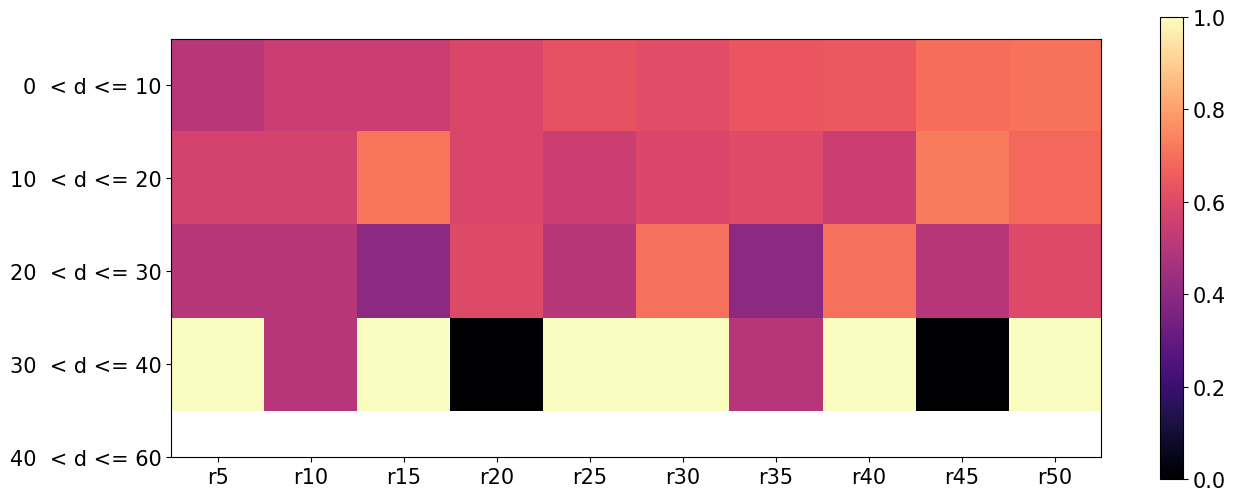

In [38]:
target = 'normal_vs_malignant_r20'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_2_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

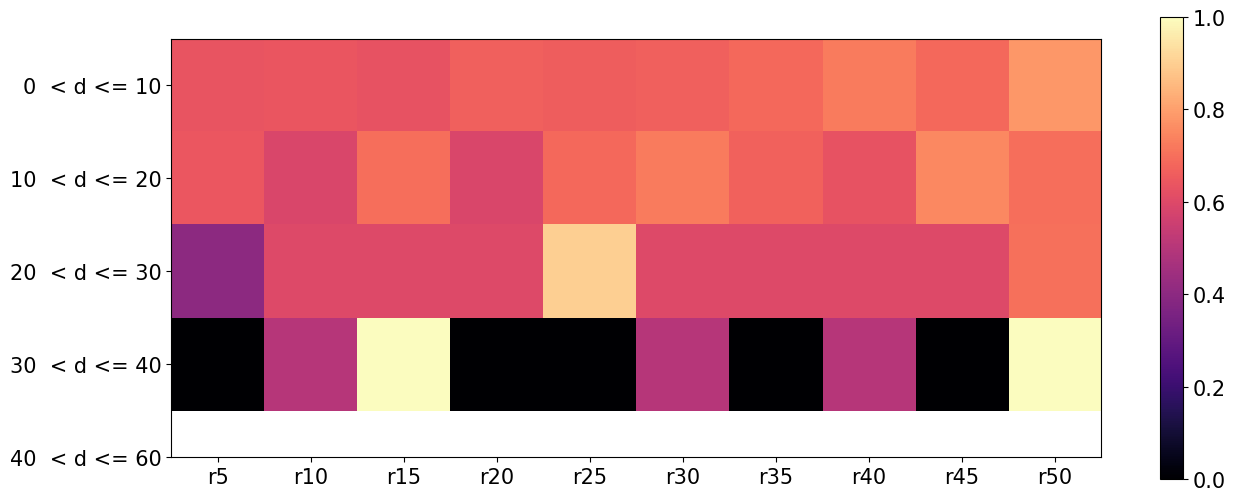

In [39]:
target = 'normal_vs_malignant_r30'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_2_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

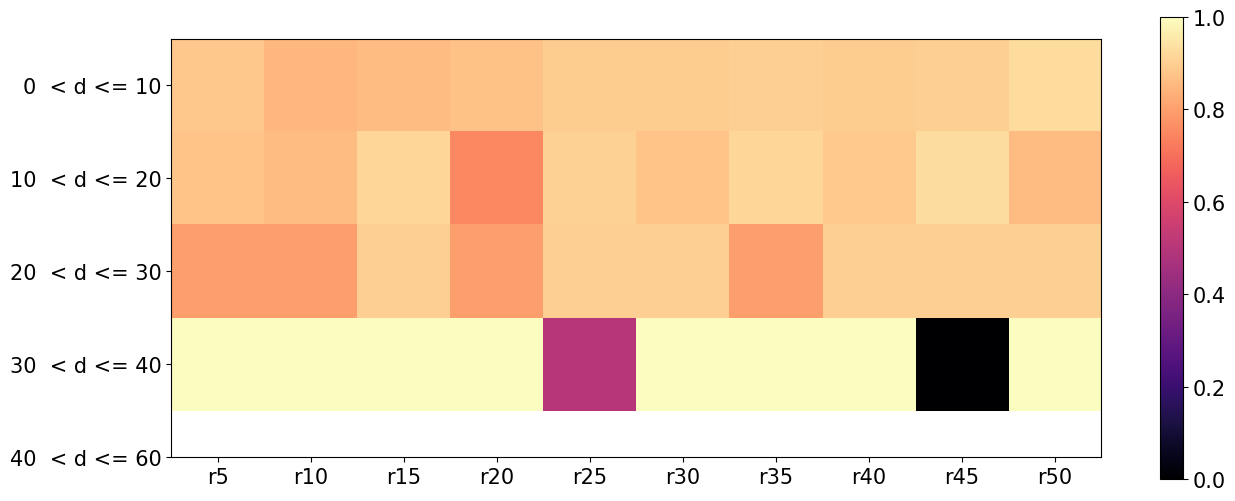

In [40]:
target = 'normal_vs_malignant_r40'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_2_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

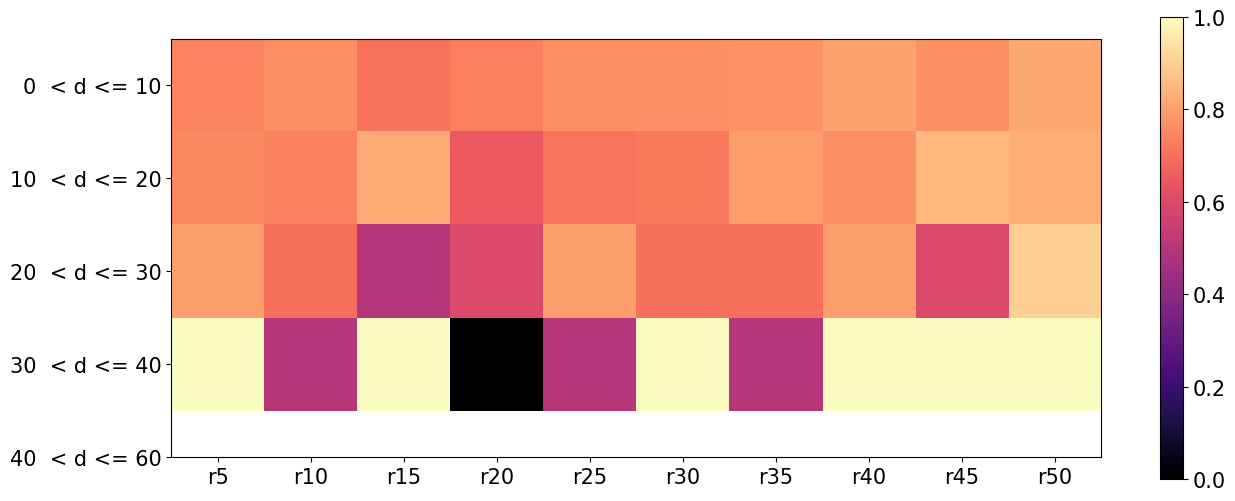

In [41]:
target = 'normal_vs_malignant_r50'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_2_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

### Malignancy level = 3

In [43]:
malignancy_score = 3
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = {}
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
# number of nodules that ranges from 50 to 60 is too small to determine accuracy.
models_path = r'A:\\MSc\\Pulmonary Nodules\\models\\'
models = ['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50']
for m_name in tqdm(models, total = len(models)):
    results[m_name] = {}
    _path = models_path + m_name
    m = tf.keras.models.load_model(_path)
    for r in tqdm(radii, total = len(radii)):
        results[m_name][f'r{r}'] = {}
        for d1, d2 in zip(small_d, large_d):
            data_df = data_info.loc[data_info['nodule_diameter'] > d1].loc[data_info['nodule_diameter'] <= d2].loc[
                data_info['malignancy_score']==malignancy_score].loc[data_info['radius'] == r]
            test_data = load_data(data_df, malignancy_score, 1)
            if len(test_data) == 0:
                results[m_name][f'r{r}'][f'{d1}  < d <= {d2}'] = 'no samples'
                continue
            accuracy = m.evaluate(test_data)
            results[m_name][f'r{r}'][f'{d1}  < d <= {d2}'] = accuracy[1]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step - loss: 4.4836 - accuracy: 0.6000


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step - loss: 4.4428 - accuracy: 0.6000


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.2992 - accuracy: 0.6000


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.5222 - accuracy: 0.6000


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0530 - accuracy: 1.0000


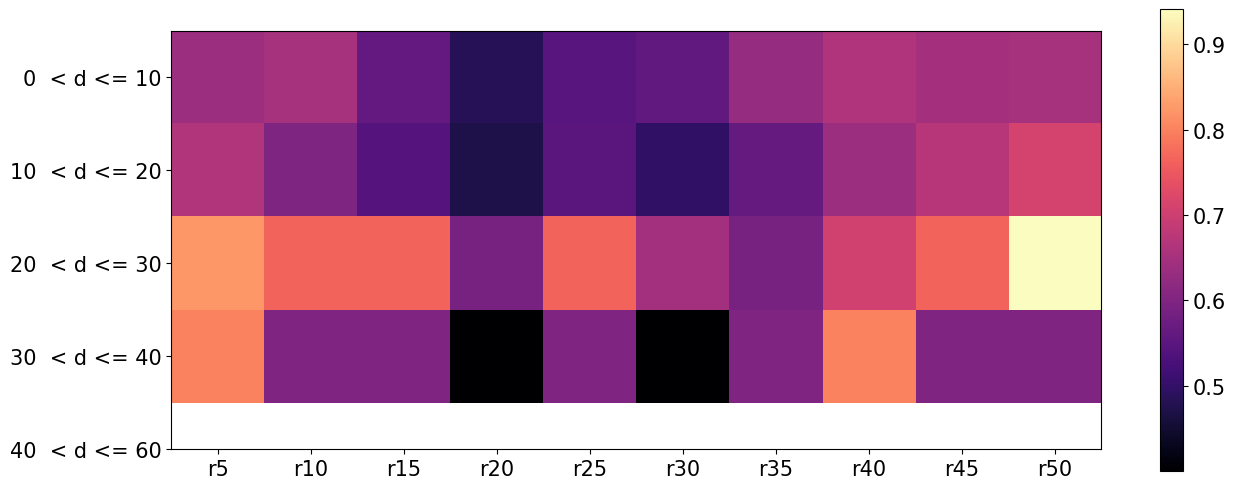

In [44]:
target = 'normal_vs_malignant_r10'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_3_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

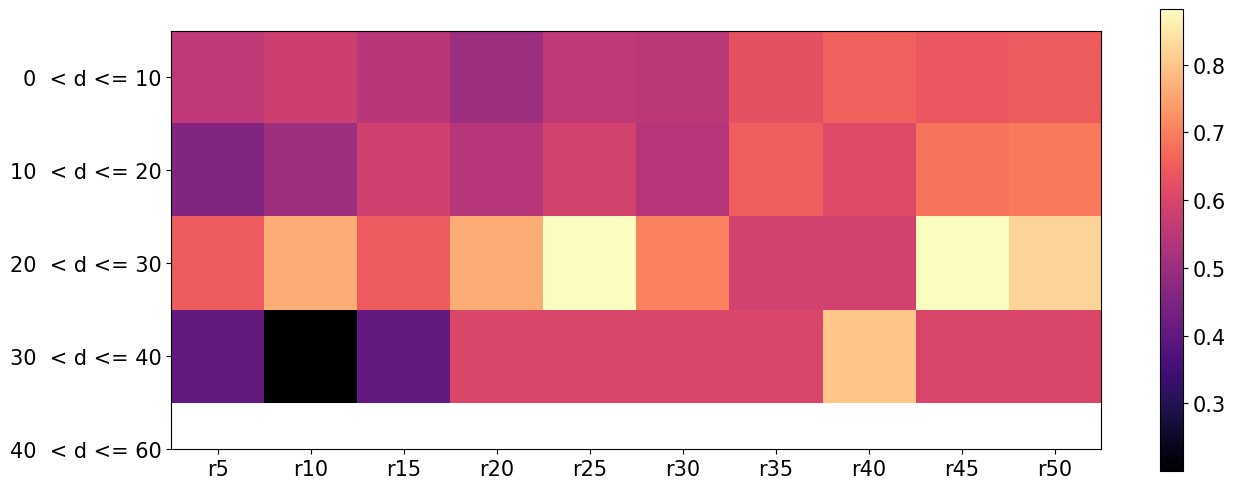

In [45]:
target = 'normal_vs_malignant_r20'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_3_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

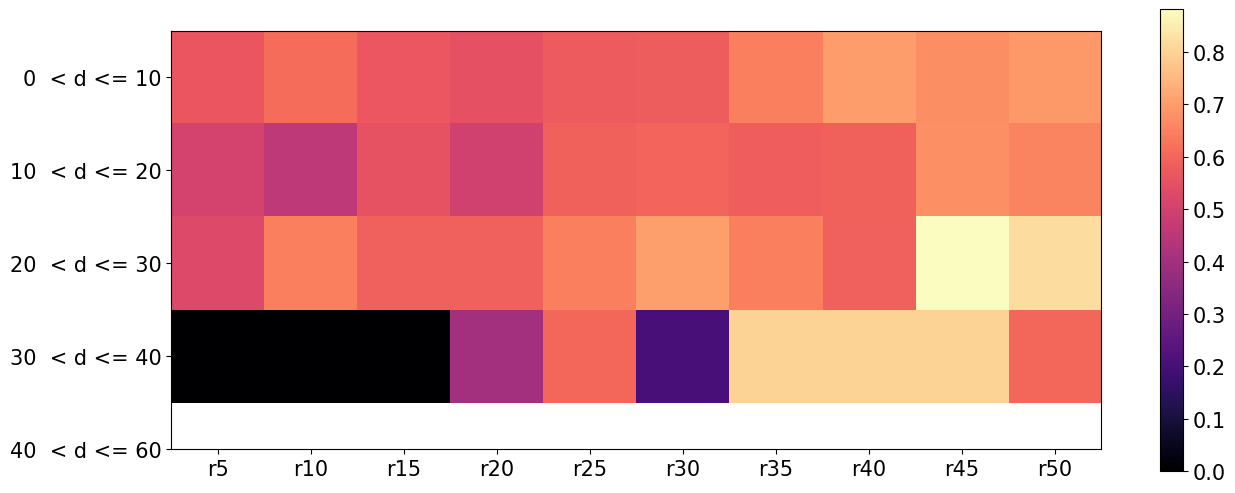

In [46]:
target = 'normal_vs_malignant_r30'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_3_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

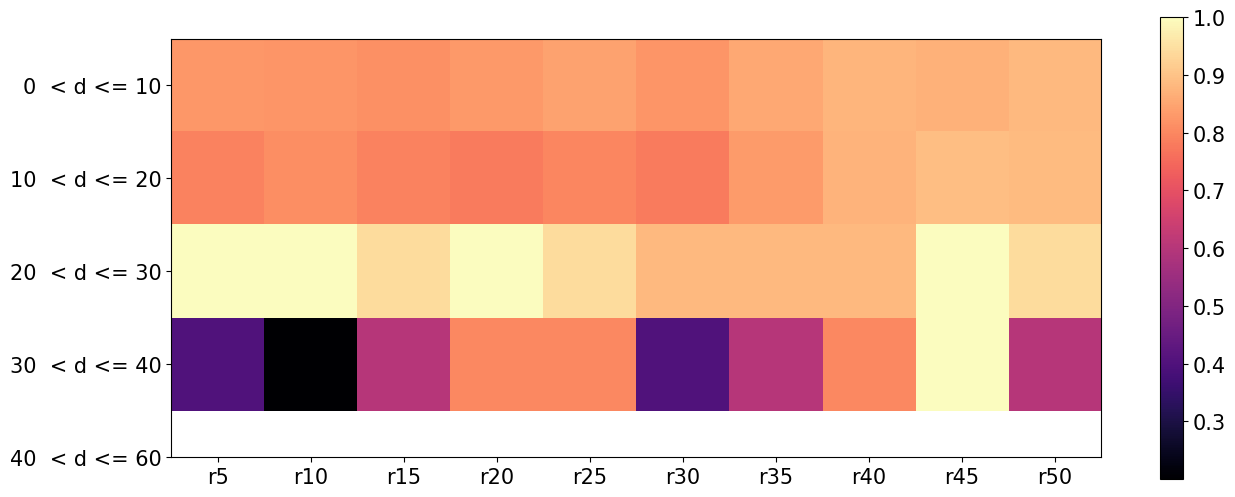

In [47]:
target = 'normal_vs_malignant_r40'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_3_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

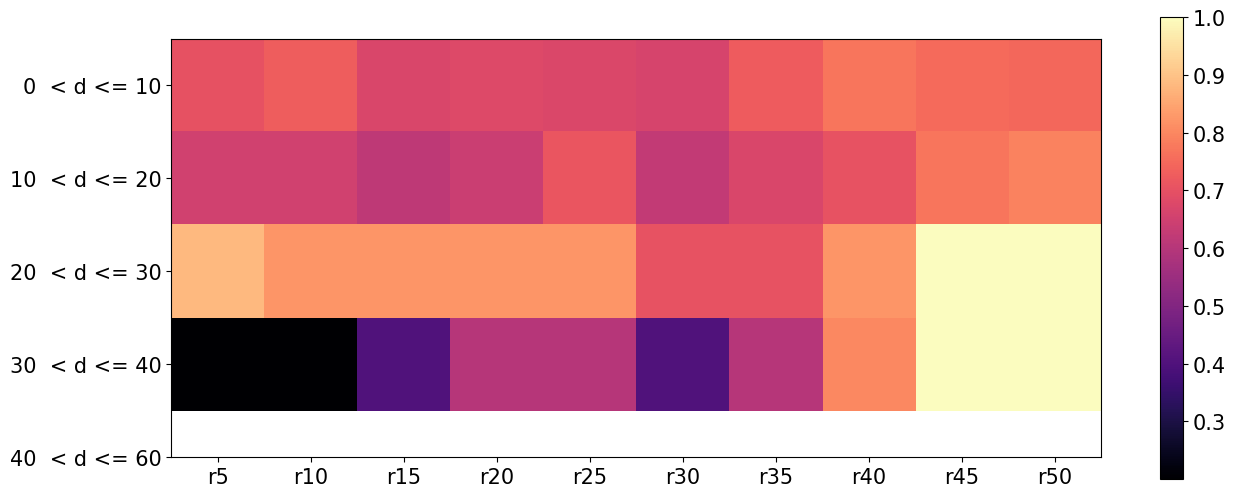

In [48]:
target = 'normal_vs_malignant_r50'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_3_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

### Malignancy level = 4 

In [49]:
malignancy_score = 4
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = {}
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
# number of nodules that ranges from 50 to 60 is too small to determine accuracy.
models_path = r'A:\\MSc\\Pulmonary Nodules\\models\\'
models = ['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50']
for m_name in tqdm(models, total = len(models)):
    results[m_name] = {}
    _path = models_path + m_name
    m = tf.keras.models.load_model(_path)
    for r in tqdm(radii, total = len(radii)):
        results[m_name][f'r{r}'] = {}
        for d1, d2 in zip(small_d, large_d):
            data_df = data_info.loc[data_info['nodule_diameter'] > d1].loc[data_info['nodule_diameter'] <= d2].loc[
                data_info['malignancy_score']==malignancy_score].loc[data_info['radius'] == r]
            test_data = load_data(data_df, malignancy_score, 1)
            if len(test_data) == 0:
                results[m_name][f'r{r}'][f'{d1}  < d <= {d2}'] = 'no samples'
                continue
            accuracy = m.evaluate(test_data)
            results[m_name][f'r{r}'][f'{d1}  < d <= {d2}'] = accuracy[1]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step - loss: 1.0086e-23 - accuracy: 1.0000


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step - loss: 1.7544e-18 - accuracy: 1.0000


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step - loss: 7.1540e-16 - accuracy: 1.0000


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.6216e-36 - accuracy: 1.0000


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000


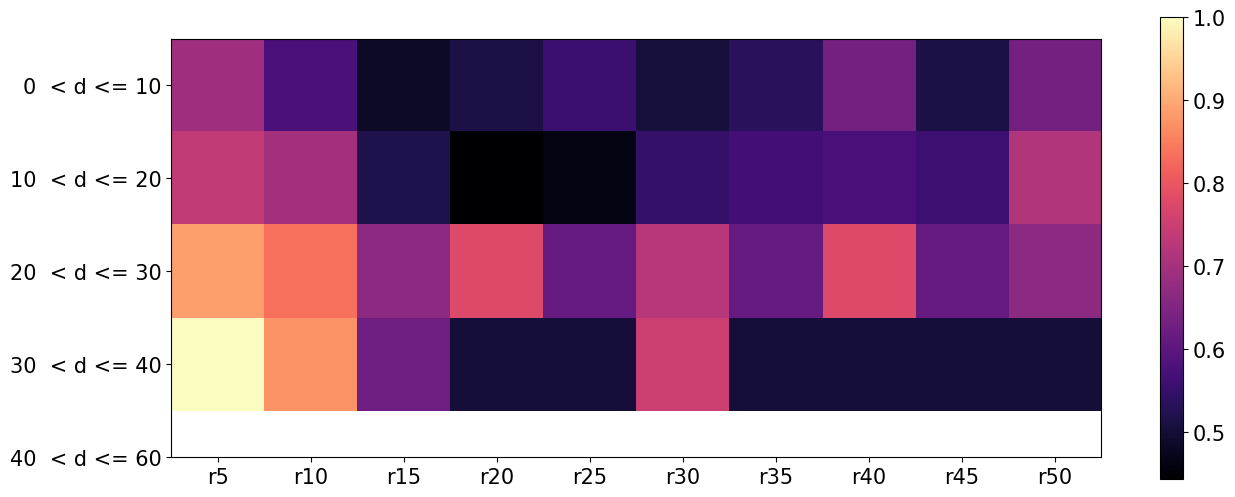

In [50]:
target = 'normal_vs_malignant_r10'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_4_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

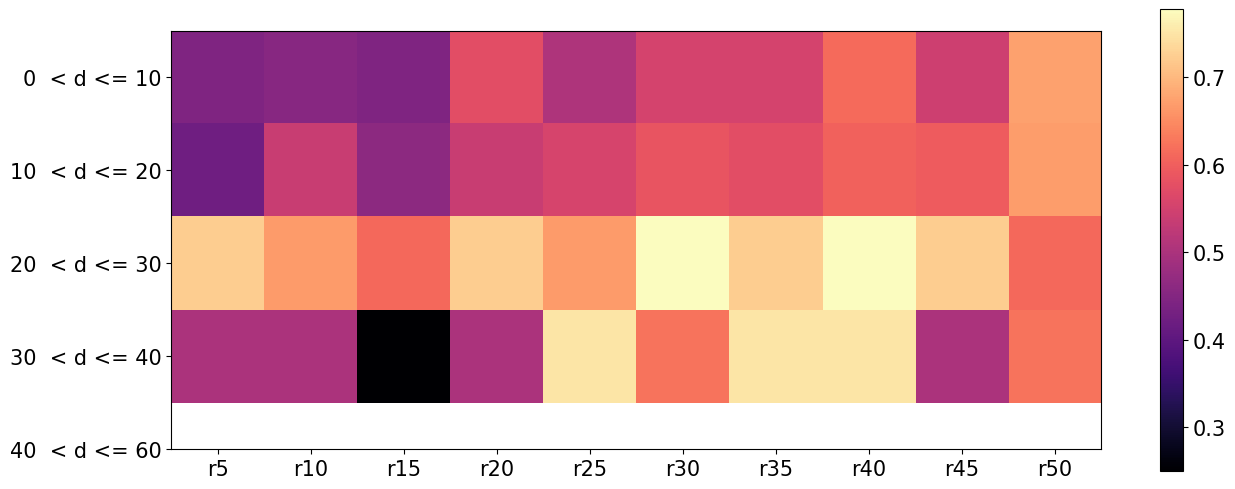

In [51]:
target = 'normal_vs_malignant_r20'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_4_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

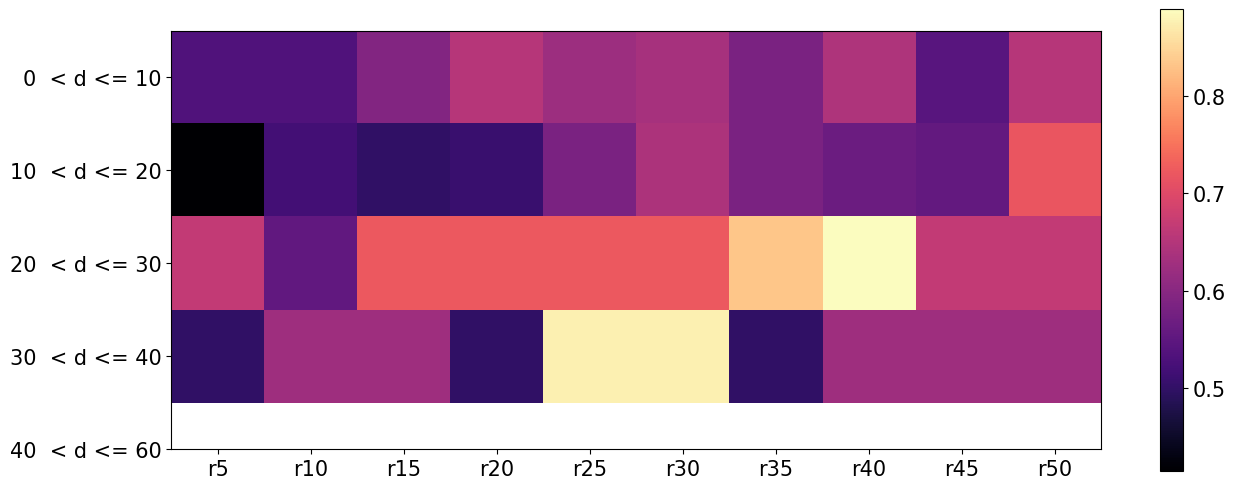

In [52]:
target = 'normal_vs_malignant_r30'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_4_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

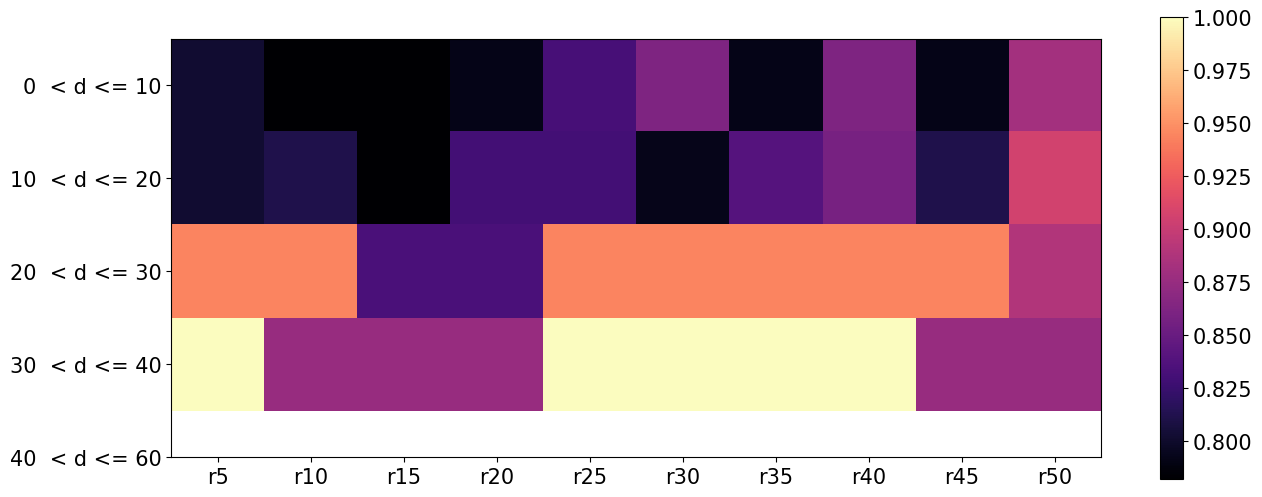

In [53]:
target = 'normal_vs_malignant_r40'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_4_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

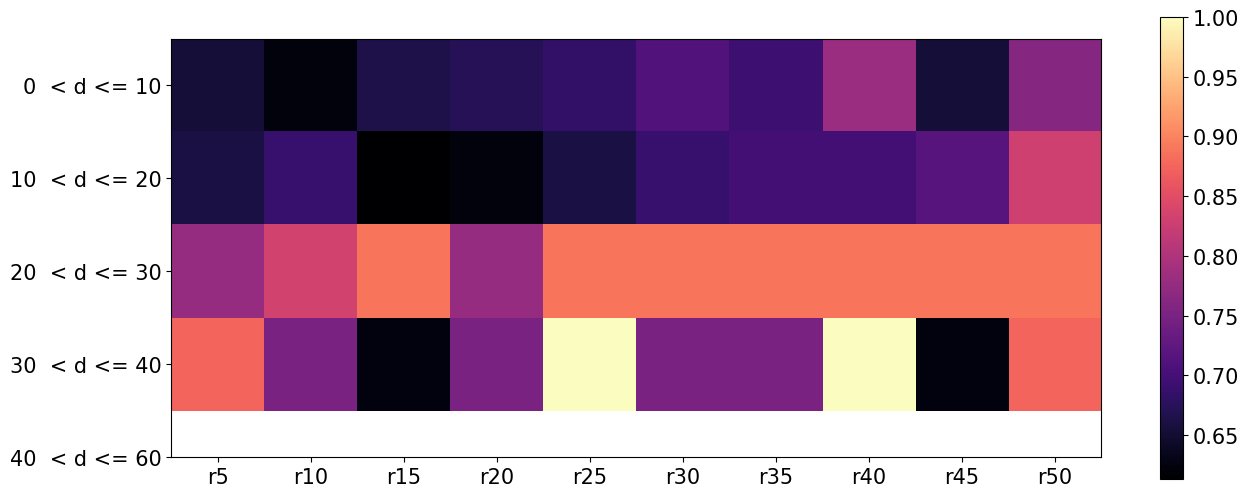

In [54]:
target = 'normal_vs_malignant_r50'
df = pd.DataFrame(results[target])
plt.figure(figsize=(15,6))
plt.imshow(df[:-1].astype(float), cmap ="magma")
plt.colorbar().ax.tick_params(labelsize=15)
  
# Assigning labels of x-axis 
# according to dataframe
plt.yticks(range(len(df.index)), df.index)
  
# Assigning labels of y-axis 
# according to dataframe
plt.xticks(range(len(df.columns)), df.columns)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/malignancy_4_' +target+ '.png', dpi = 500)
# Displaying the figure
plt.show()

## Malignancy score vs Size (Heatmap)

In [4]:
data_info_1 = pd.read_csv(r'A:\MSc\Pulmonary Nodules\sameslicethickness\arranged\arranged_info_levels234.csv')
data_info_2 = pd.read_csv(r'A:\MSc\Pulmonary Nodules\sameslicethickness\arranged\arranged_info.csv')
data_info = pd.concat([data_info_1, data_info_2], ignore_index = True)
del data_info_1, data_info_2

In [8]:
models_path = r'A:\\MSc\\Pulmonary Nodules\\models\\'
models = ['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50']
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = {}
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
for m_name in tqdm(models, total = len(models)):
        results[m_name] = {'radius' : [],
                     'score' : [],
                     'nodule size': [],
                     'accuracy' : []}
        _path = models_path + m_name
        m = tf.keras.models.load_model(_path)
        for r in tqdm(radii, total = len(radii)):
            for score in [1,2,3,4,5]:
                for d1, d2 in zip(small_d, large_d):
                    data_df = data_info.loc[data_info['nodule_diameter'] > d1].loc[data_info['nodule_diameter'] <= d2].loc[
                    data_info['malignancy_score']==score].loc[data_info['radius'] == r]
                    test_data = load_data(data_df, score, 1)
                    if len(test_data) == 0:
                        results[m_name]['radius'].append(r)
                        results[m_name]['score'].append(score)
                        results[m_name]['nodule size'].append(f'{d1}  < d <= {d2}')
                        results[m_name]['accuracy'].append('no samples')
                        continue
                    accuracy = m.evaluate(test_data)
                    results[m_name]['radius'].append(r)
                    results[m_name]['score'].append(score)
                    results[m_name]['nodule size'].append(f'{d1}  < d <= {d2}')
                    results[m_name]['accuracy'].append(accuracy)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 1s 98ms/step - loss: 5.9711 - accuracy: 0.6436


  0%|          | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 1s 99ms/step - loss: 3.6585 - accuracy: 0.6535


  0%|          | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 1s 98ms/step - loss: 2.5578 - accuracy: 0.6238


  0%|          | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 1s 98ms/step - loss: 0.4681 - accuracy: 0.9406


  0%|          | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 1s 97ms/step - loss: 1.8861 - accuracy: 0.8218


In [9]:
# end #
models = ['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50']
for m_name in models:
    pd.DataFrame(results[m_name]).to_csv('A:/MSc/Pulmonary Nodules/Results/All/'+m_name+'_results.csv')

In [10]:
results_2 = {}
for m_name in tqdm(models, total = len(models)):
        results_2[m_name] = {'radius' : [],
                     'score' : [],
                     'nodule size': [],
                     'accuracy' : []}
        for k in results_2[m_name].keys():
            if k == 'accuracy':
                for r in results[m_name][k]:
                    results_2[m_name][k].append(r[1])
            else :
                for r in results[m_name][k]:
                    results_2[m_name][k].append(r)
                    
models = ['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50']
for m_name in models:
    pd.DataFrame(results_2[m_name]).to_csv('A:/MSc/Pulmonary Nodules/Results/All/'+m_name+'_accuracies.csv')

  0%|          | 0/5 [00:00<?, ?it/s]

# Reduce test data along certain axis

## Reduce score axis

In [11]:
models_path = r'A:\\MSc\\Pulmonary Nodules\\models\\'
models = ['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50']
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = {}
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
for m_name in tqdm(models, total = len(models)):
        results[m_name] = {'radius' : [],
                     'score' : [],
                     'nodule size': [],
                     'accuracy' : []}
        _path = models_path + m_name
        m = tf.keras.models.load_model(_path)
        for r in tqdm(radii, total = len(radii)):
            for d1, d2 in zip(small_d, large_d):
                data_df = data_info.loc[
                    data_info['nodule_diameter'] > d1].loc[
                    data_info['nodule_diameter'] <= d2].loc[
                    data_info['radius'] == r]
                test_data = load_data(data_df, 'all', 1)
                if len(test_data) == 0:
                    #results[m_name]['radius'].append(r)
                    #results[m_name]['score'].append(score)
                    #results[m_name]['nodule size'].append(f'{d1}  < d <= {d2}')
                    #results[m_name]['accuracy'].append('no samples')
                    continue
                accuracy = m.evaluate(test_data)
                results[m_name]['radius'].append(r)
                results[m_name]['score'].append('all scores included')
                results[m_name]['nodule size'].append(f'{d1}  < d <= {d2}')
                results[m_name]['accuracy'].append(accuracy[1])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 1s 109ms/step - loss: 5.6694 - accuracy: 0.6080


  0%|          | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 1s 108ms/step - loss: 3.0412 - accuracy: 0.6400


  0%|          | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 1s 106ms/step - loss: 2.2409 - accuracy: 0.6320


  0%|          | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 1s 108ms/step - loss: 0.3782 - accuracy: 0.9520


  0%|          | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 1s 106ms/step - loss: 1.6879 - accuracy: 0.8320


In [17]:
pd.DataFrame(results['normal_vs_malignant_r10']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r10_reduced_score.csv')
pd.DataFrame(results['normal_vs_malignant_r20']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r20_reduced_score.csv')
pd.DataFrame(results['normal_vs_malignant_r30']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r30_reduced_score.csv')
pd.DataFrame(results['normal_vs_malignant_r40']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r40_reduced_score.csv')
pd.DataFrame(results['normal_vs_malignant_r50']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r50_reduced_score.csv')

## Reduce nodule size axis

In [25]:
models_path = r'A:\\MSc\\Pulmonary Nodules\\models\\'
models = ['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50']
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = {}
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
for m_name in tqdm(models, total = len(models)):
        results[m_name] = {'radius' : [],
                     'score' : [],
                     'nodule size': [],
                     'accuracy' : []}
        _path = models_path + m_name
        m = tf.keras.models.load_model(_path)
        for r in tqdm(radii, total = len(radii)):
            for score in [1,2,3,4,5]:
                data_df = data_info.loc[data_info['malignancy_score']==score].loc[data_info['radius'] == r]
                test_data = load_data(data_df, score, 1, sizes = 'all')
                if len(test_data) == 0:
                    #results[m_name]['radius'].append(r)
                    #results[m_name]['score'].append(score)
                    #results[m_name]['nodule size'].append(f'{d1}  < d <= {d2}')
                    #results[m_name]['accuracy'].append('no samples')
                    continue
                accuracy = m.evaluate(test_data)
                results[m_name]['radius'].append(r)
                results[m_name]['score'].append(score)
                results[m_name]['nodule size'].append('all sizes')
                results[m_name]['accuracy'].append(accuracy[1])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 1s 105ms/step - loss: 2.9975 - accuracy: 0.7040


  0%|          | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 1s 104ms/step - loss: 2.4796 - accuracy: 0.7120


  0%|          | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 1s 104ms/step - loss: 1.2454 - accuracy: 0.7760


  0%|          | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 1s 107ms/step - loss: 0.2888 - accuracy: 0.8960


  0%|          | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 1s 110ms/step - loss: 0.9461 - accuracy: 0.8800


In [26]:
pd.DataFrame(results['normal_vs_malignant_r10']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r10_reduced_nodule_size.csv')
pd.DataFrame(results['normal_vs_malignant_r20']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r20_reduced_nodule_size.csv')
pd.DataFrame(results['normal_vs_malignant_r30']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r30_reduced_nodule_size.csv')
pd.DataFrame(results['normal_vs_malignant_r40']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r40_reduced_nodule_size.csv')
pd.DataFrame(results['normal_vs_malignant_r50']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r50_reduced_nodule_size.csv')

## Reduce radius axis

In [37]:
models_path = r'A:\\MSc\\Pulmonary Nodules\\models\\'
models = ['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50']
radii = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = {}
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
for m_name in tqdm(models, total = len(models)):
        results[m_name] = {'radius' : [],
                     'score' : [],
                     'nodule size': [],
                     'accuracy' : []}
        _path = models_path + m_name
        m = tf.keras.models.load_model(_path)
        for score in tqdm([1,2,3,4,5], total = 5):
            for d1, d2 in zip(small_d, large_d):
                data_df = data_info.loc[data_info['nodule_diameter'] > d1].loc[data_info['nodule_diameter'] <= d2].loc[
                data_info['malignancy_score']==score]
                test_data = load_data(data_df, score, 1, radius = 'all')
                if len(test_data) == 0:
                    results[m_name]['radius'].append('all radii')
                    results[m_name]['score'].append(score)
                    results[m_name]['nodule size'].append(f'{d1}  < d <= {d2}')
                    results[m_name]['accuracy'].append(-1)
                    continue
                accuracy = m.evaluate(test_data)
                results[m_name]['radius'].append('all radii')
                results[m_name]['score'].append(score)
                results[m_name]['nodule size'].append(f'{d1}  < d <= {d2}')
                results[m_name]['accuracy'].append(accuracy)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

16/16 [==============================] - 2s 105ms/step - loss: 5.2133 - accuracy: 0.5680


  0%|          | 0/5 [00:00<?, ?it/s]

16/16 [==============================] - 2s 105ms/step - loss: 2.3441 - accuracy: 0.7280


  0%|          | 0/5 [00:00<?, ?it/s]

16/16 [==============================] - 2s 105ms/step - loss: 3.5168 - accuracy: 0.4880


  0%|          | 0/5 [00:00<?, ?it/s]

16/16 [==============================] - 2s 106ms/step - loss: 0.4244 - accuracy: 0.8560


  0%|          | 0/5 [00:00<?, ?it/s]

16/16 [==============================] - 2s 104ms/step - loss: 3.1659 - accuracy: 0.5640


In [40]:
results_2 = {}
for m_name in tqdm(models, total = len(models)):
        results_2[m_name] = {'radius' : [],
                     'score' : [],
                     'nodule size': [],
                     'accuracy' : []}
        for k in results_2[m_name].keys():
            if k == 'accuracy':
                for r in results[m_name][k]:
                    try:
                        results_2[m_name][k].append(r[1])
                    except:
                        results_2[m_name][k].append(r)
                        
            else :
                for r in results[m_name][k]:
                    results_2[m_name][k].append(r)
                    
models = ['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50']
for m_name in models:
    pd.DataFrame(results_2[m_name]).to_csv('A:/MSc/Pulmonary Nodules/Results/All/'+m_name+'_accuracies.csv')

  0%|          | 0/5 [00:00<?, ?it/s]

In [43]:
pd.DataFrame(results_2['normal_vs_malignant_r10']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r10_reduced_radius.csv')
pd.DataFrame(results_2['normal_vs_malignant_r20']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r20_reduced_radius.csv')
pd.DataFrame(results_2['normal_vs_malignant_r30']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r30_reduced_radius.csv')
pd.DataFrame(results_2['normal_vs_malignant_r40']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r40_reduced_radius.csv')
pd.DataFrame(results_2['normal_vs_malignant_r50']).to_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/normal_vs_malignant_r50_reduced_radius.csv')

## Get Maps

In [53]:
def heatmap(excel_sheet_mname, fixed_axis = 'score', fixed_axis_parameter=1, figname='name', figaxes = ['radius', 'nodule size'], arr_shape=(5, 10)):
    m1 = pd.read_csv('A:/MSc/Pulmonary Nodules/Results/All/'+excel_sheet_mname+'_accuracies.csv')
    df1 = m1.loc[m1[fixed_axis]==fixed_axis_parameter]
    arr = np.zeros(arr_shape)
    acc = list(df1['accuracy'])
    n=0
    for i in range(arr_shape[1]):
        for j in range(arr_shape[0]):
            if acc[n] == 'o':
                arr[j][i] = -1
            else :
                arr[j][i] = acc[n]
            n += 1

    plt.figure(figsize=(15,6))
    plt.imshow(arr, cmap ="magma")
    plt.colorbar().ax.tick_params(labelsize=15)

    # Assigning labels of x-axis 
    # according to dataframe
    plt.xticks(range(len(np.unique(np.array(list(df1[figaxes[0]]))))), np.unique(np.array(list(df1[figaxes[0]]))))

    # Assigning labels of y-axis 
    # according to dataframe
    plt.yticks(range(len(np.unique(np.array(list(df1[figaxes[1]]))))), np.unique(np.array(list(df1[figaxes[1]]))))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/All/' +figname+ '.png', dpi = 500)
    # Displaying the figure
    #plt.show()

C:\Users\peter\AppData\Local\Temp\ipykernel_10812\3082014915.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,6))


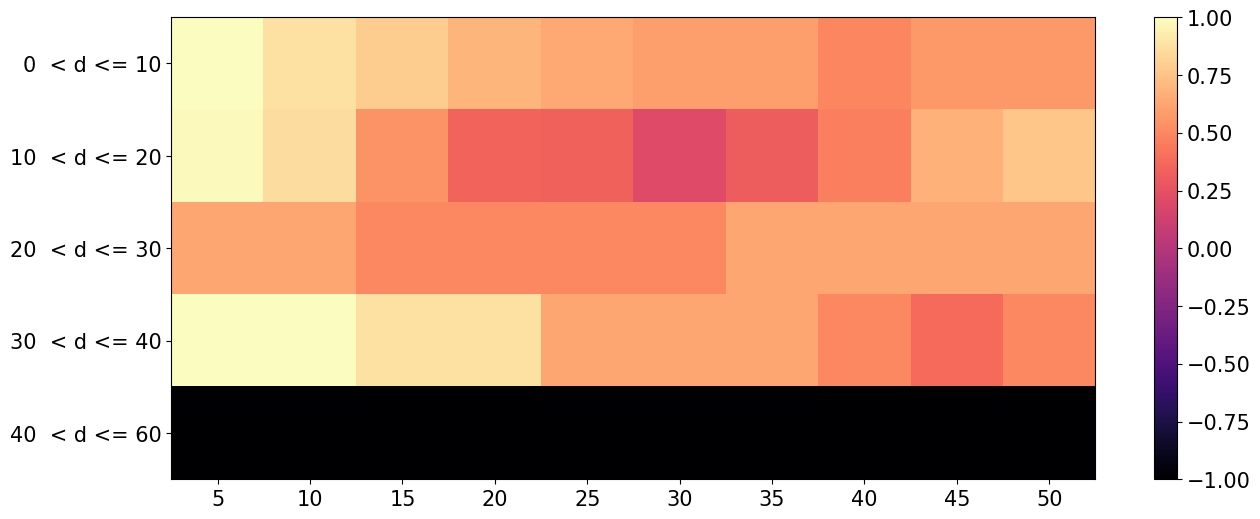

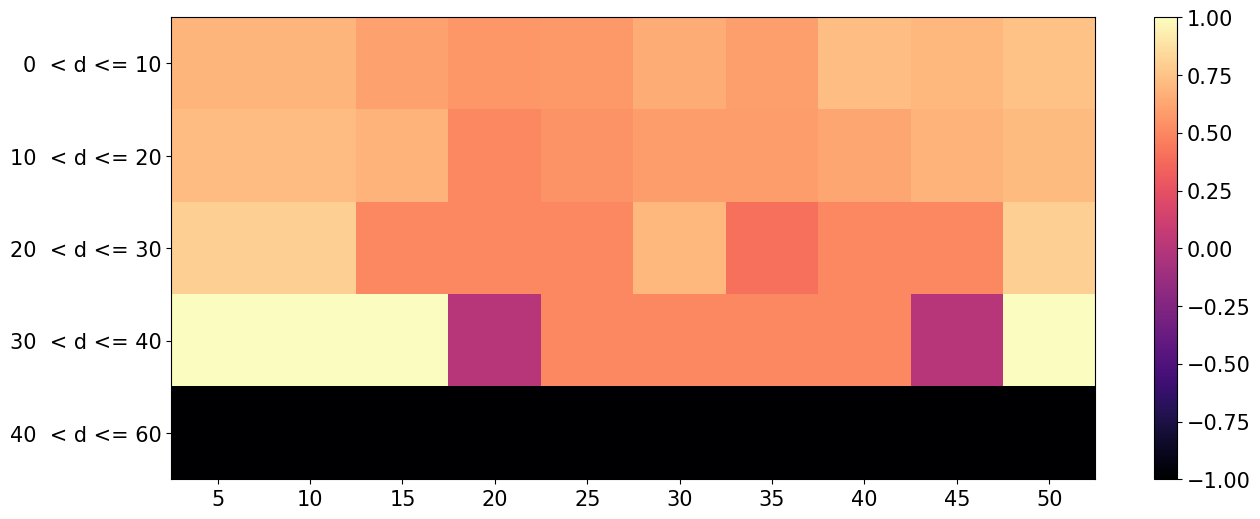

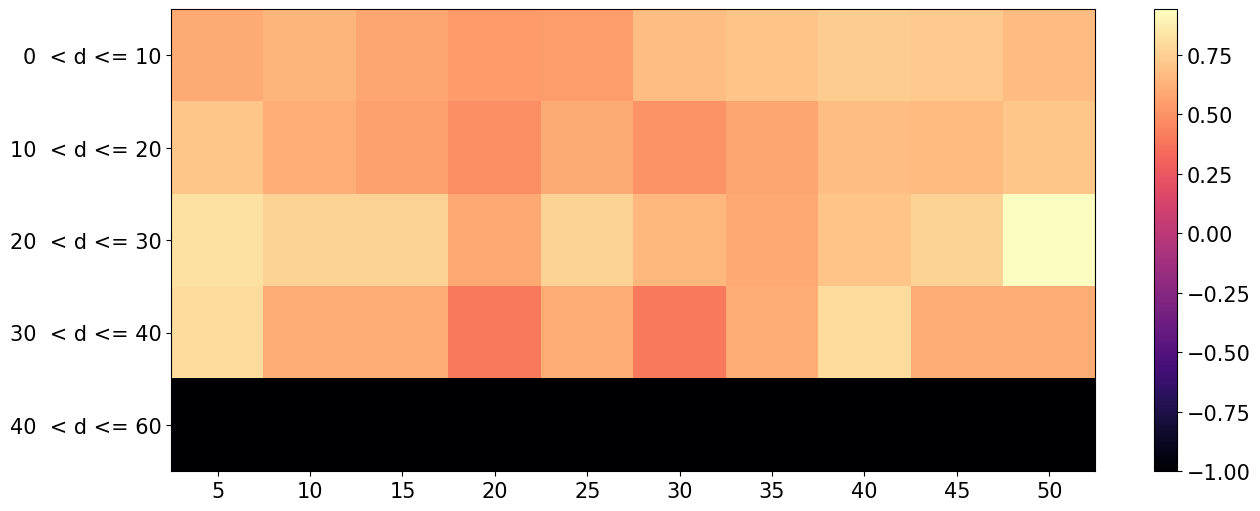

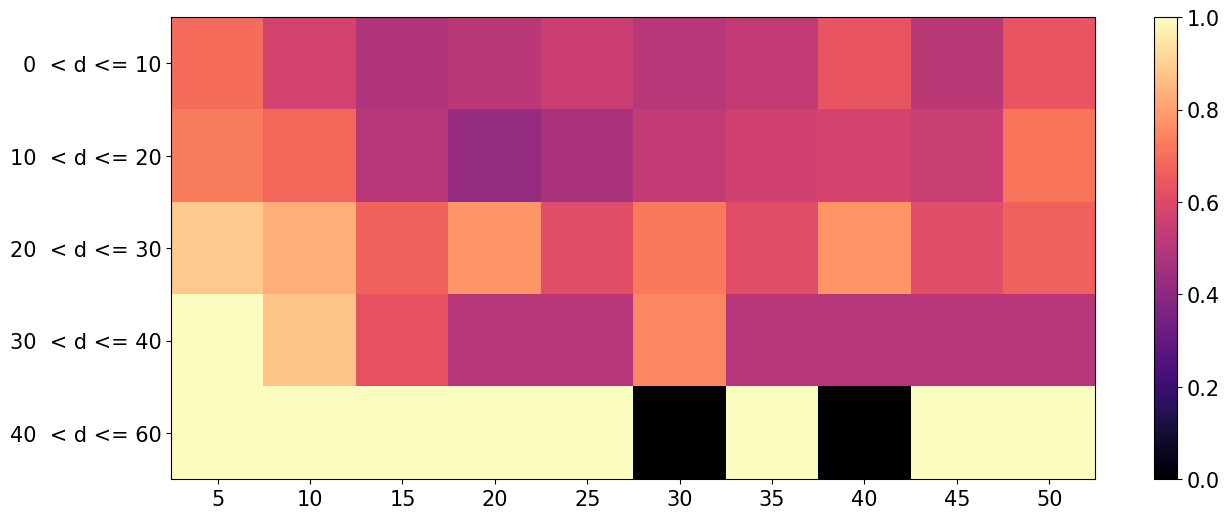

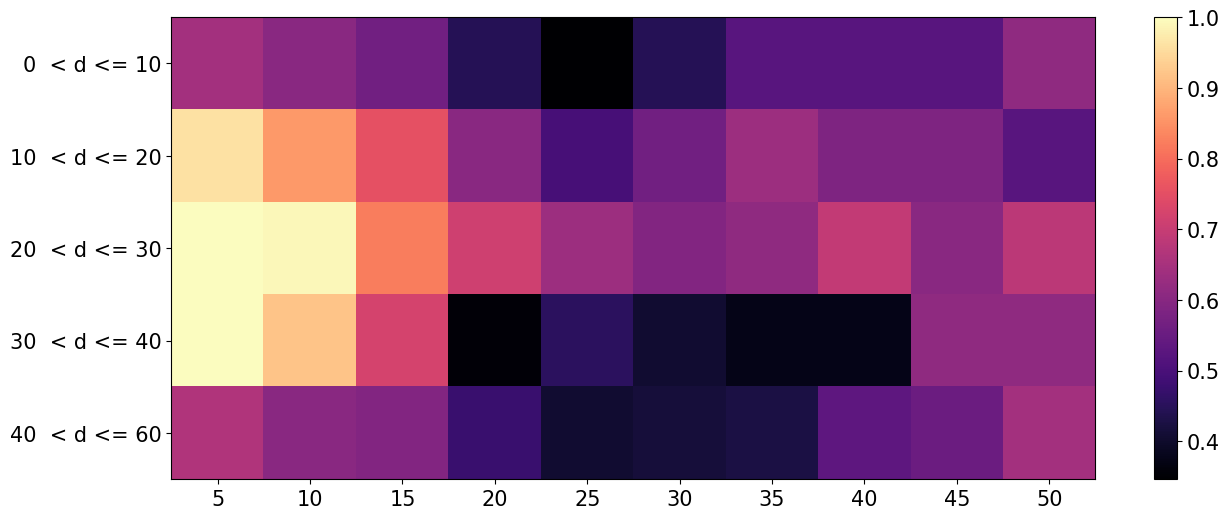

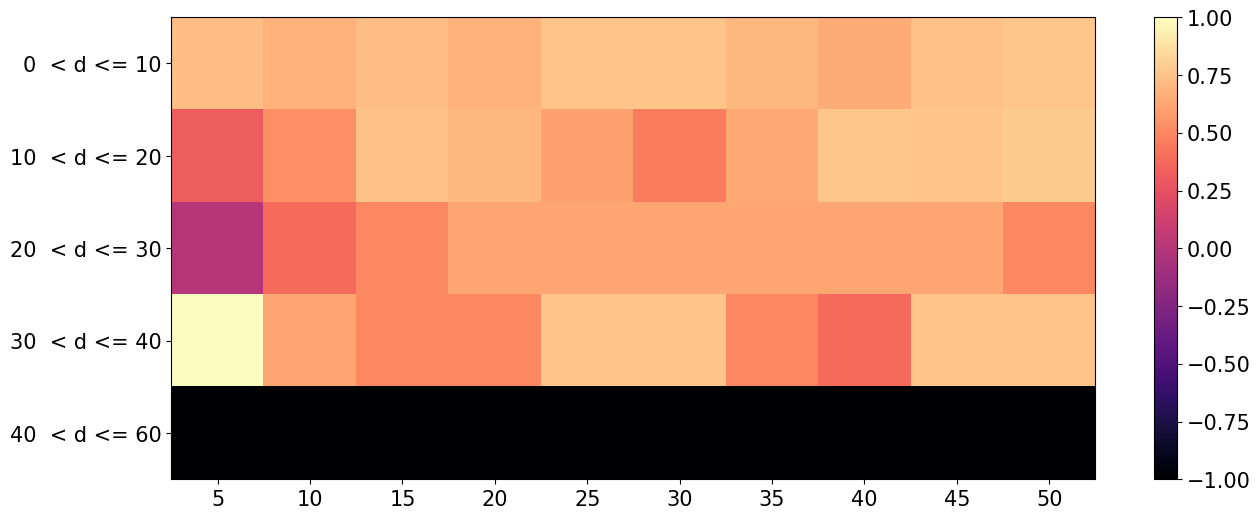

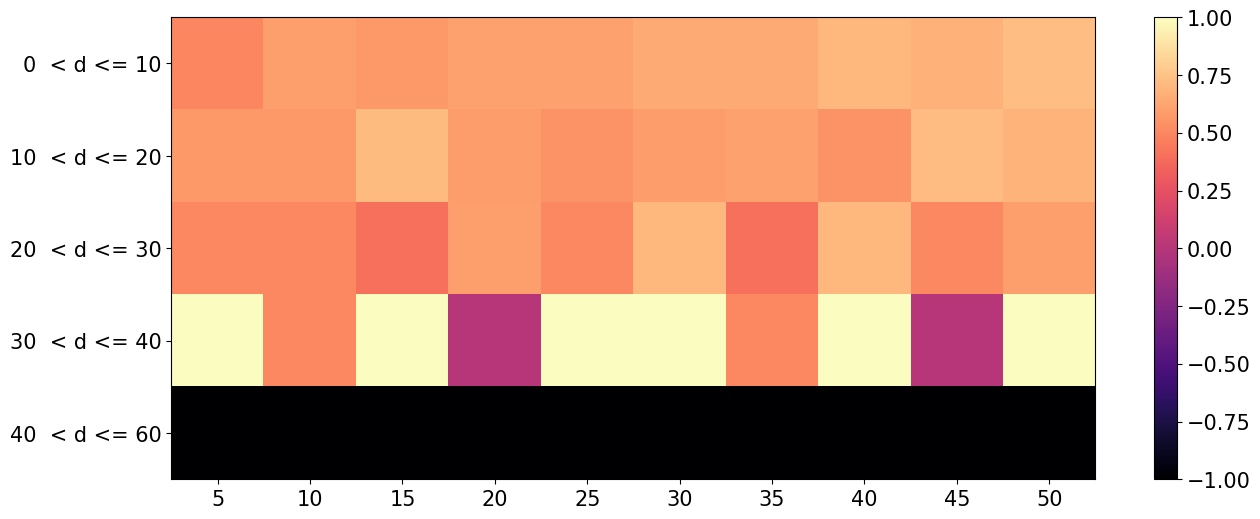

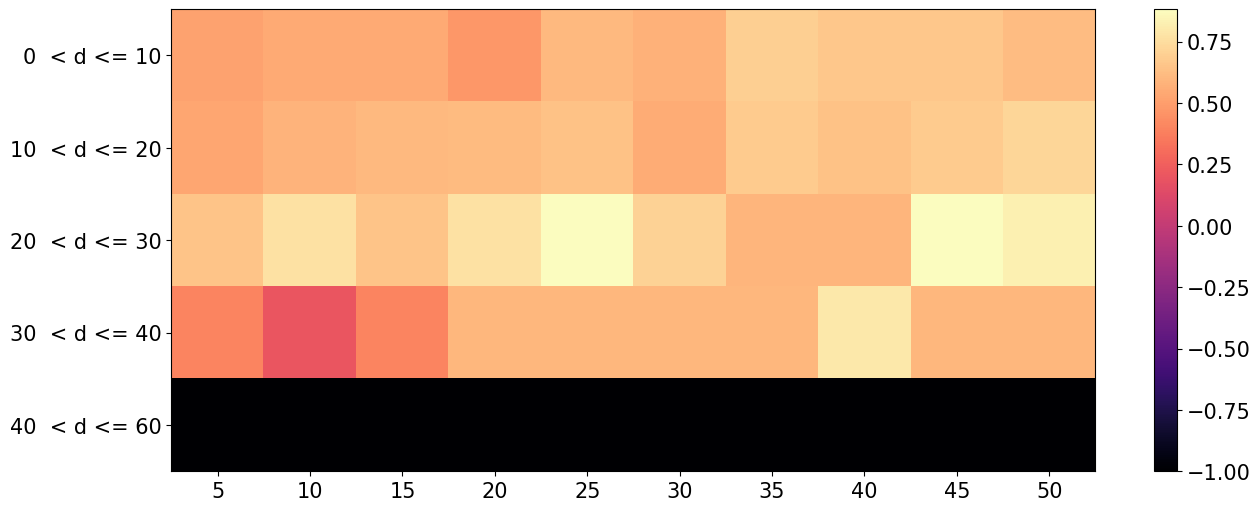

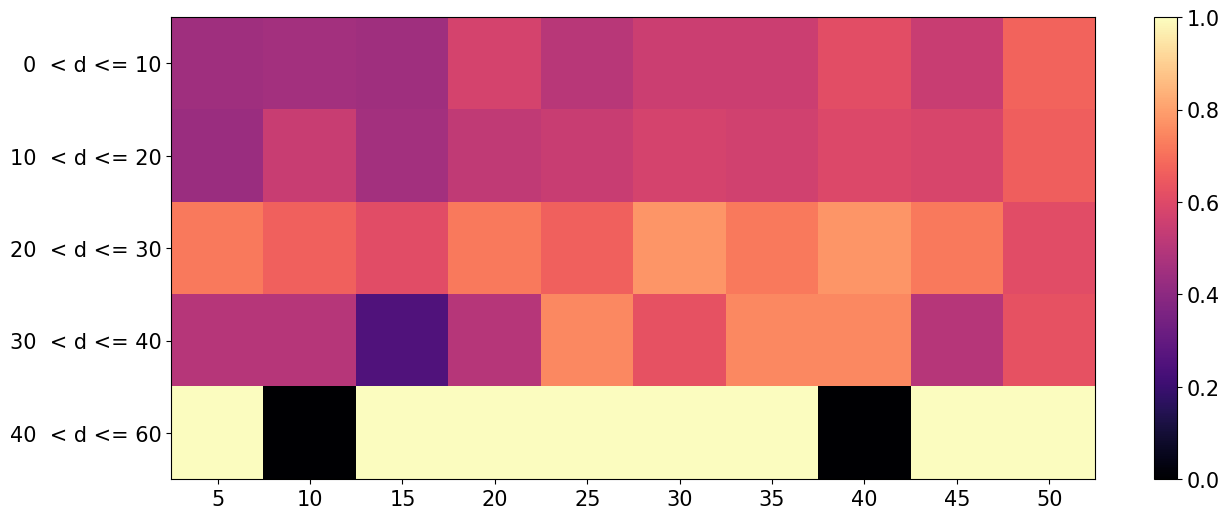

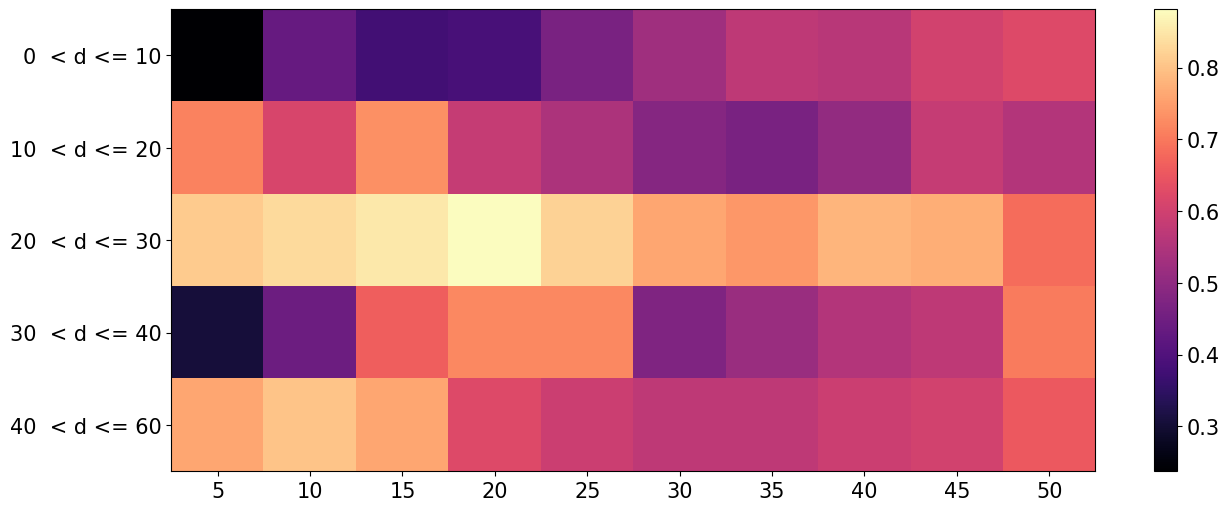

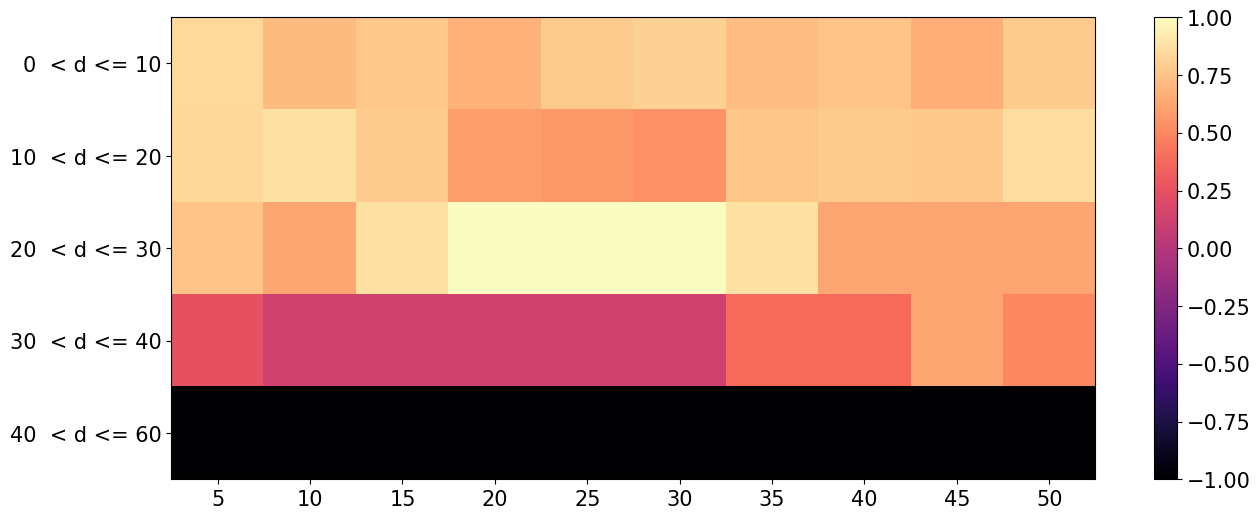

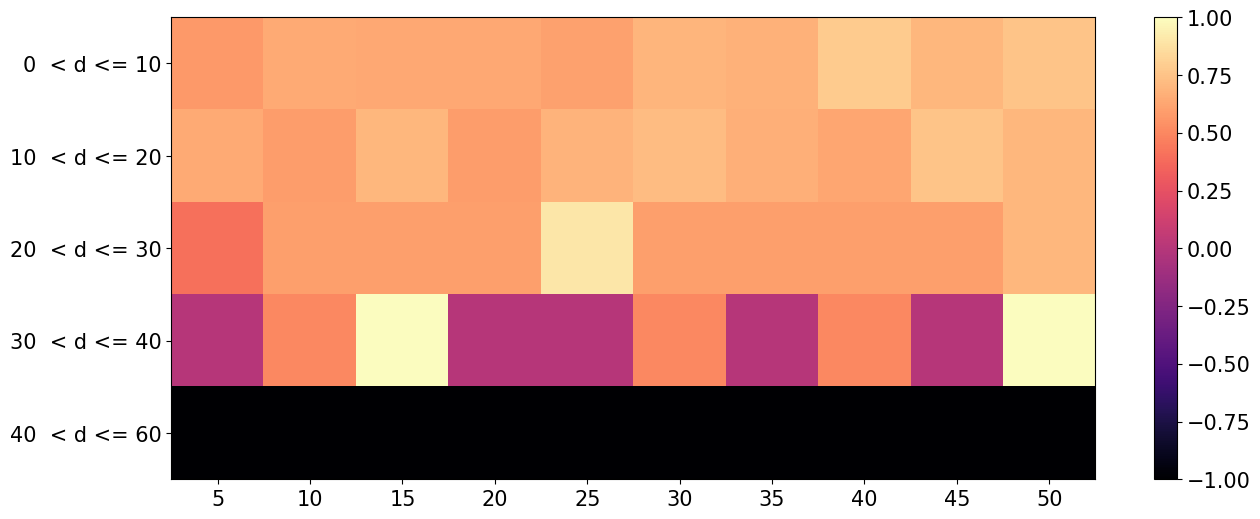

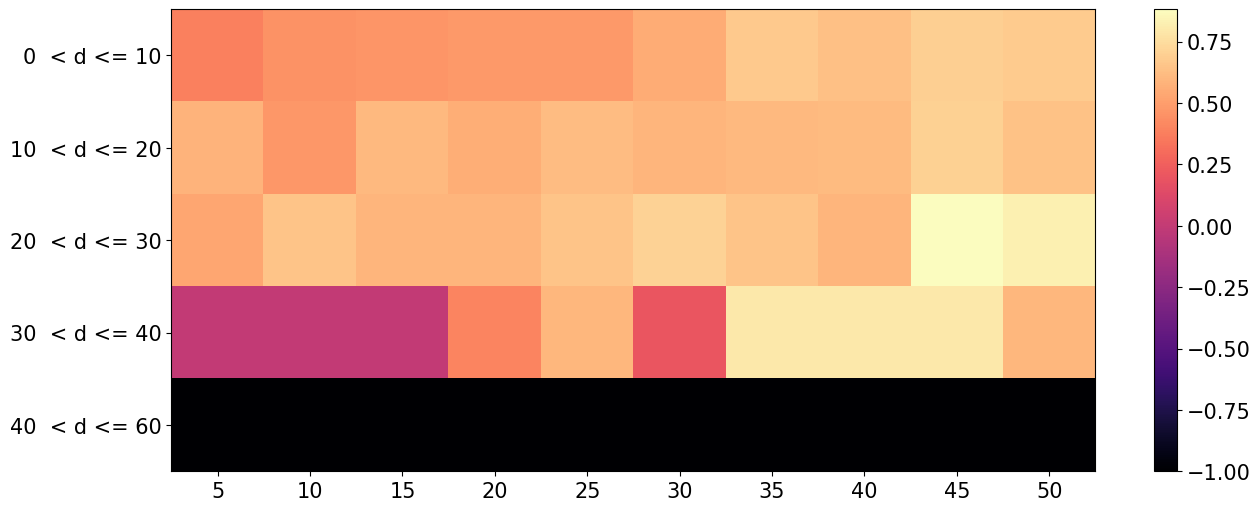

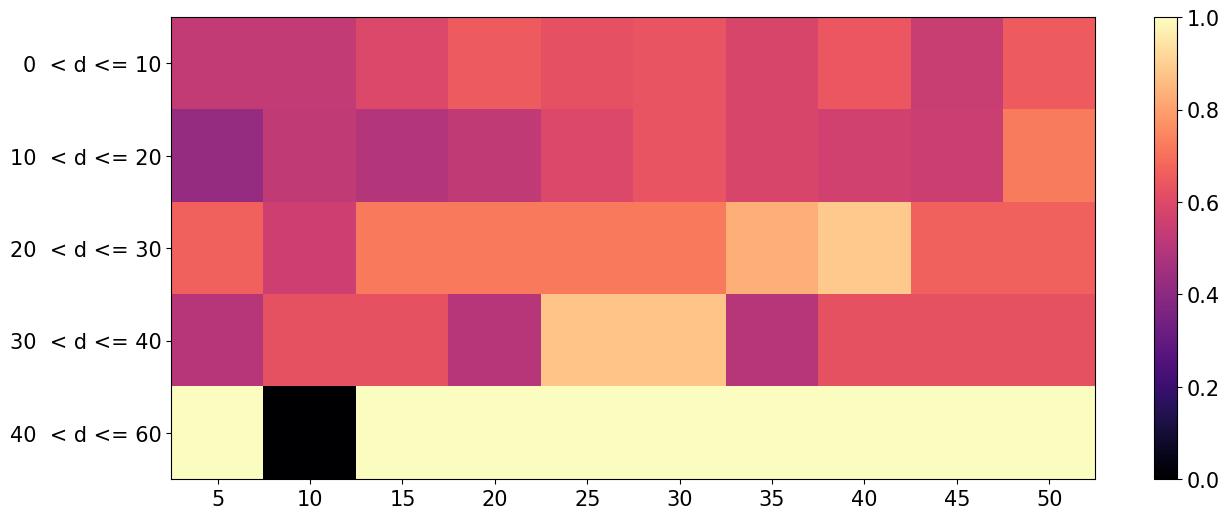

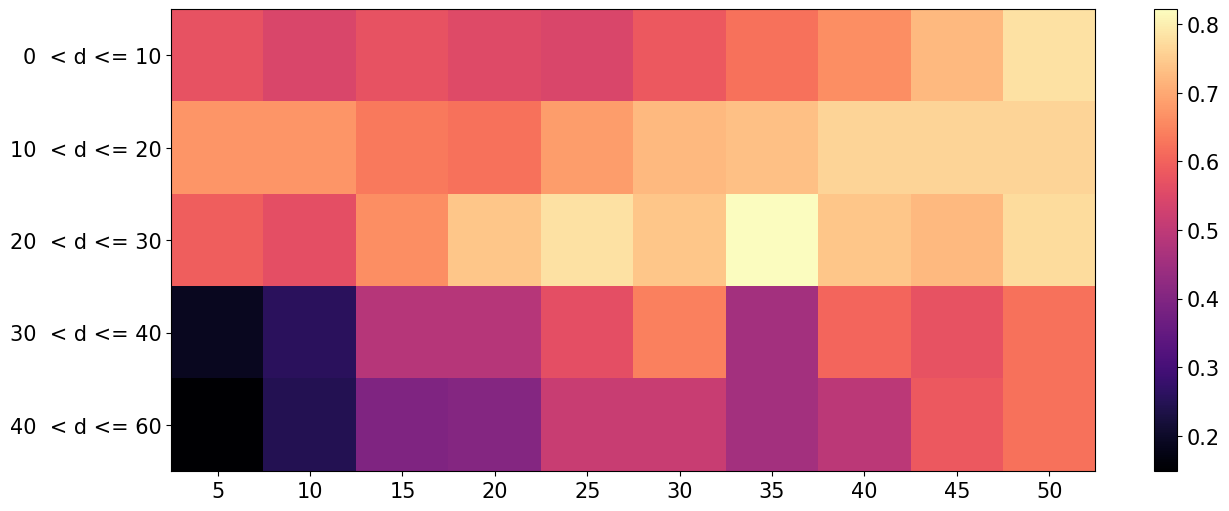

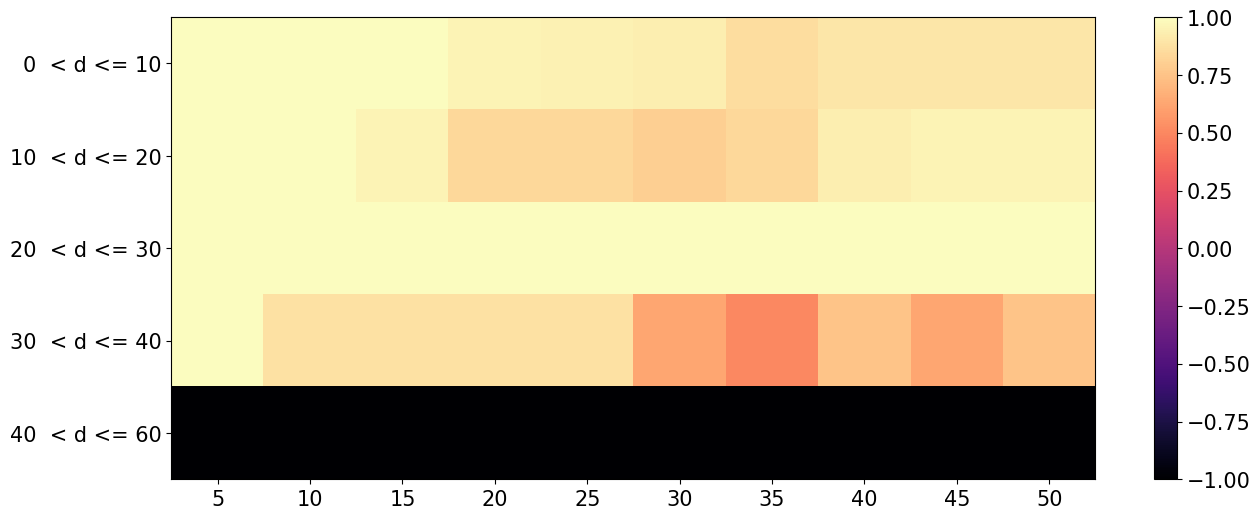

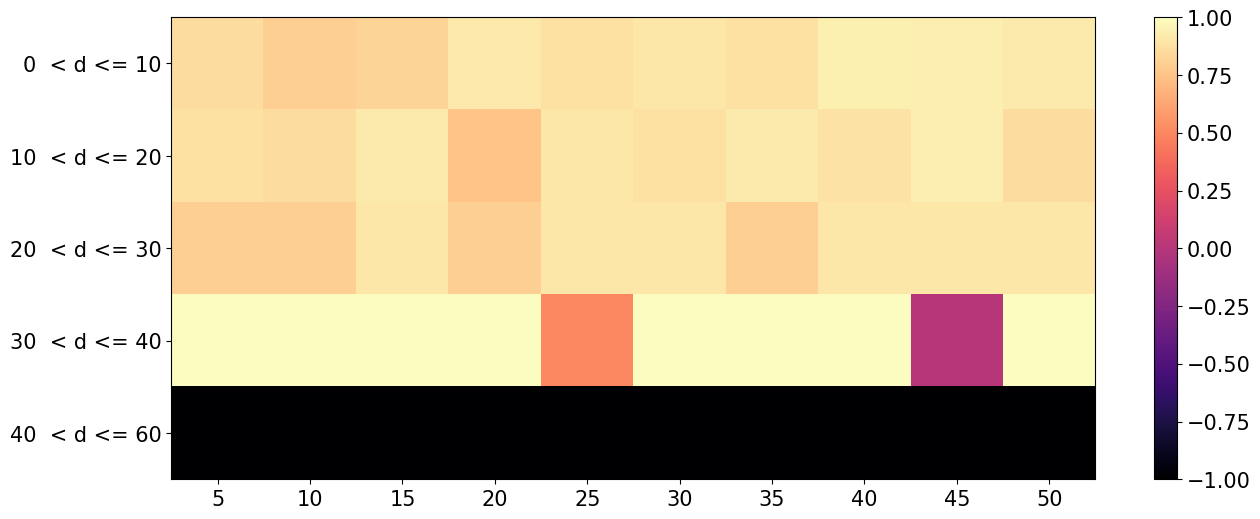

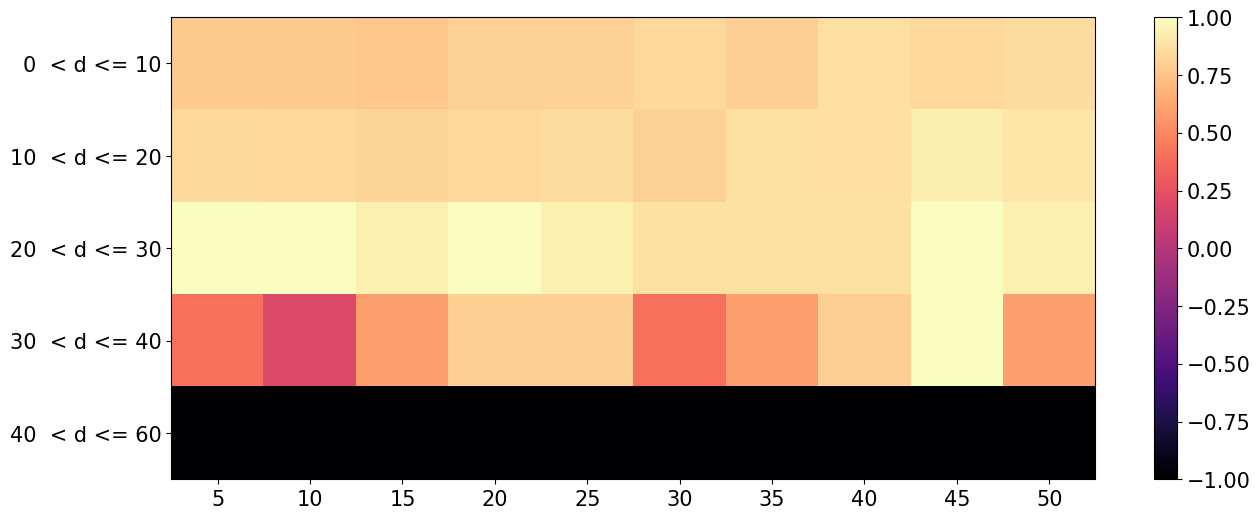

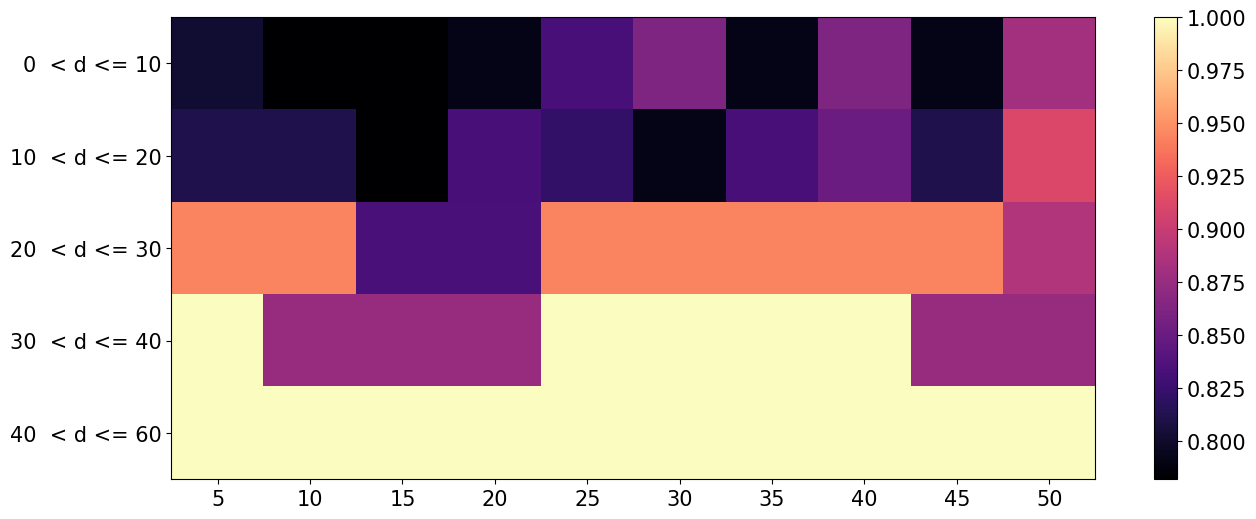

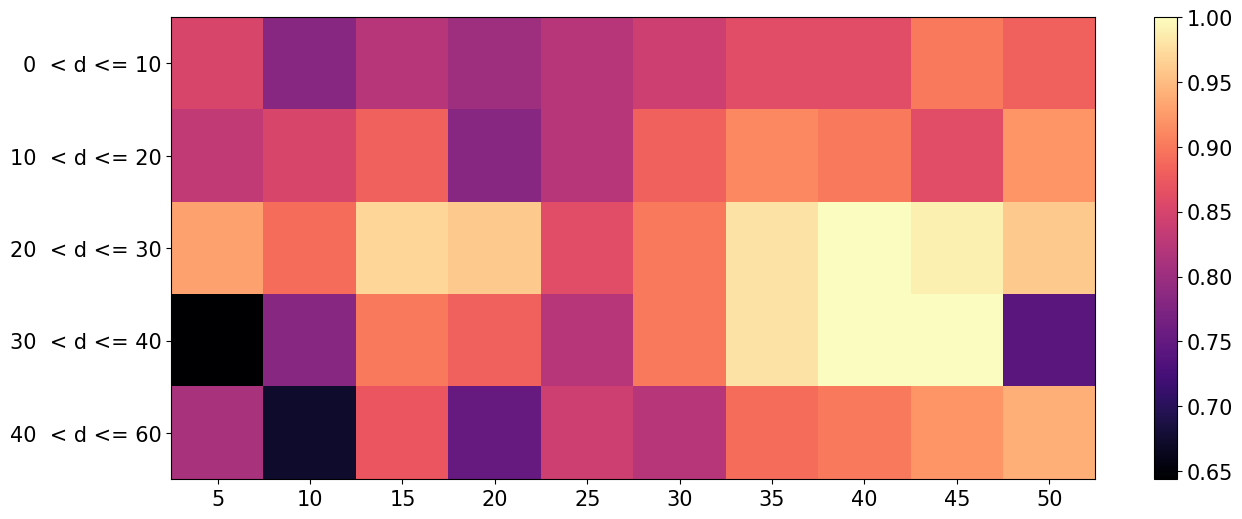

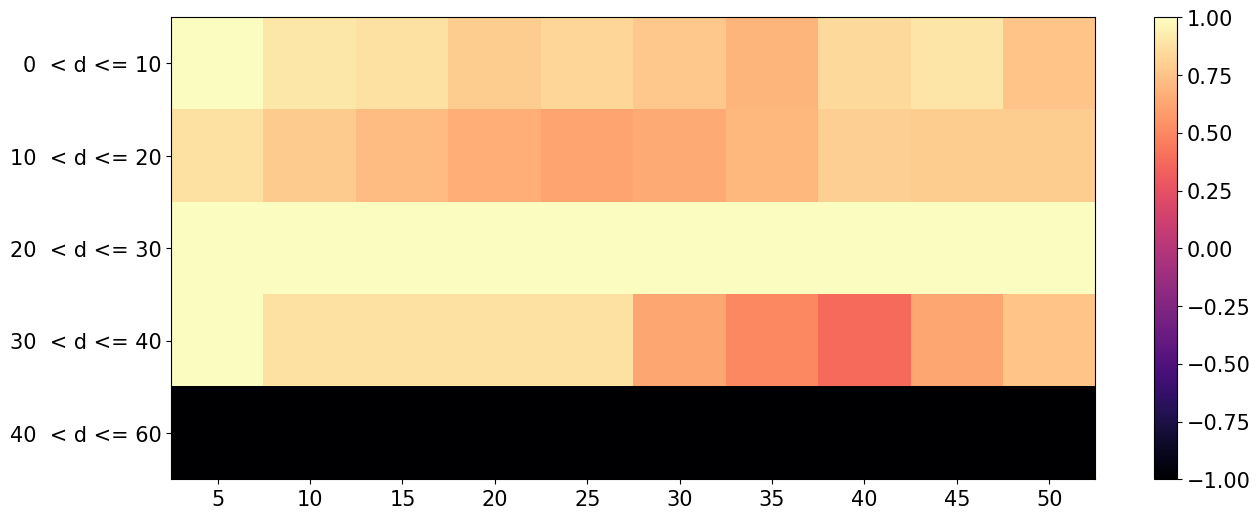

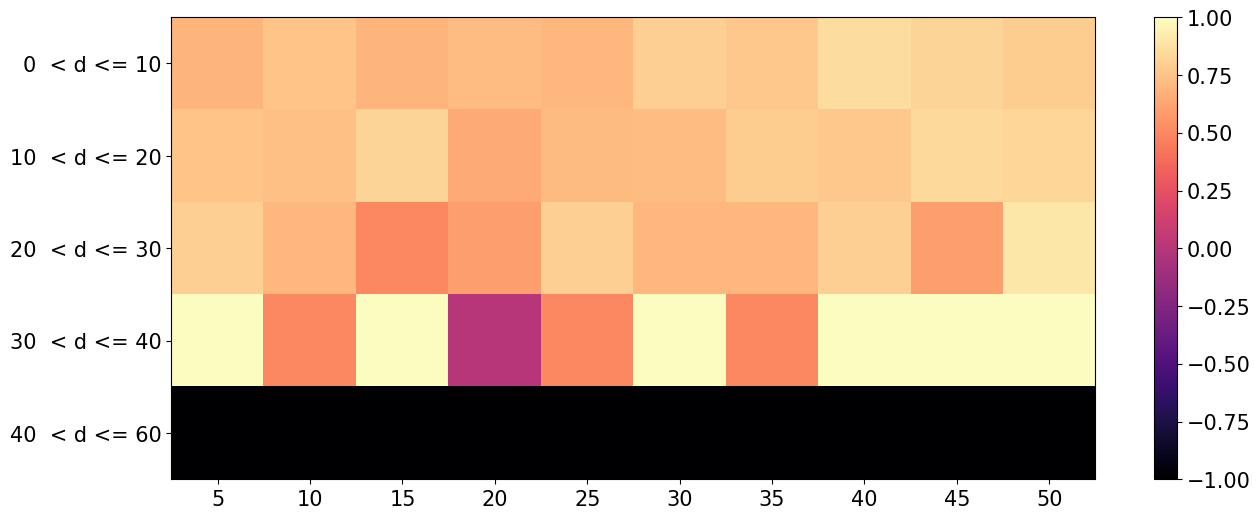

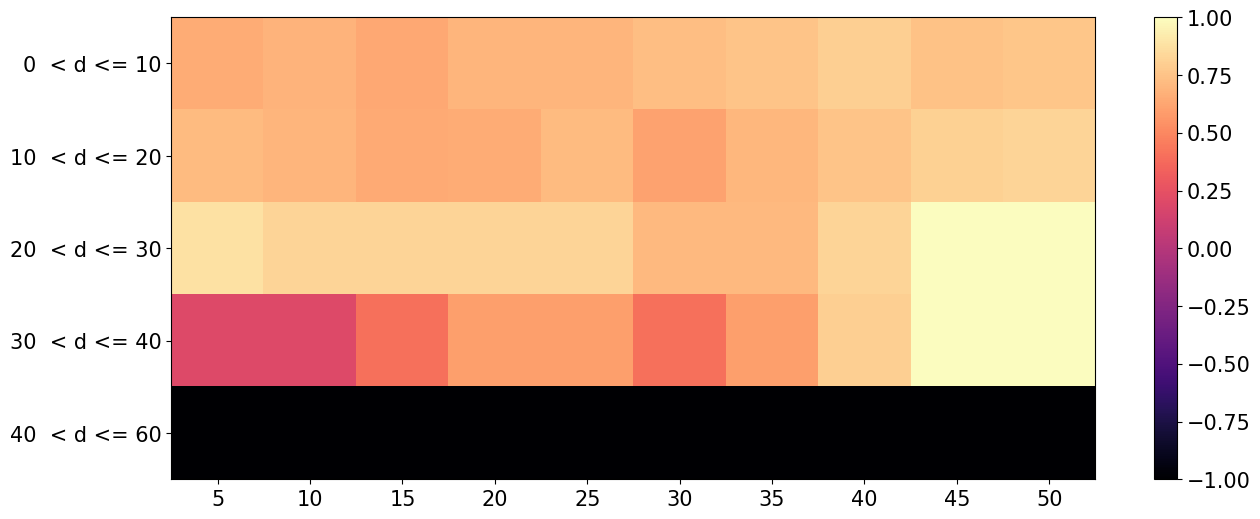

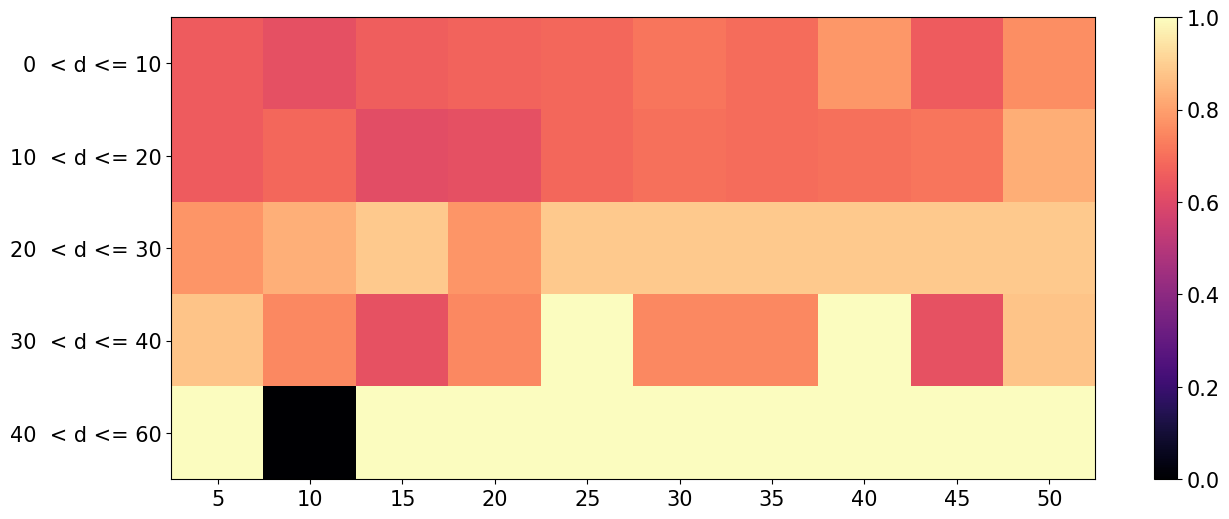

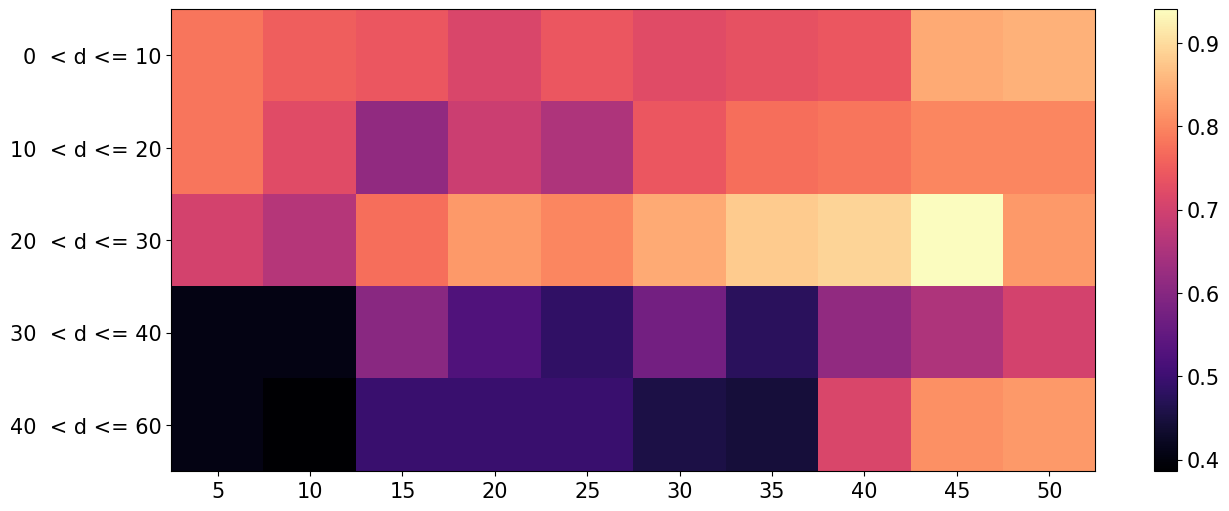

In [54]:
for i in range(5):
    for s in range(1, 6):
        heatmap(excel_sheet_mname=models[i], fixed_axis = 'score', fixed_axis_parameter=s, figname=models[i]+f'_score_{s}'+'_distance-VS-nodule_size', figaxes = ['radius', 'nodule size'], arr_shape=(5, 10))

C:\Users\peter\AppData\Local\Temp\ipykernel_10812\3082014915.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,6))


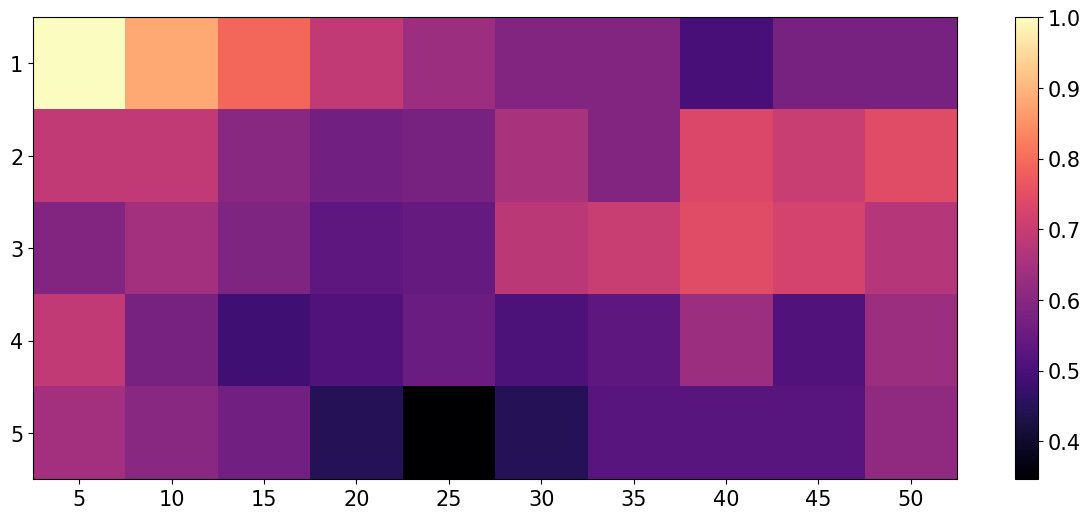

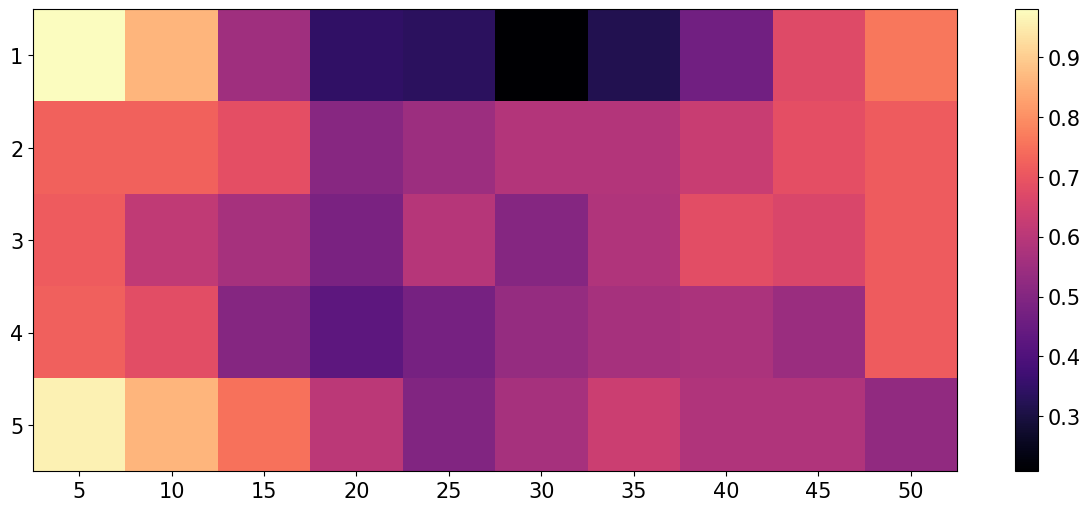

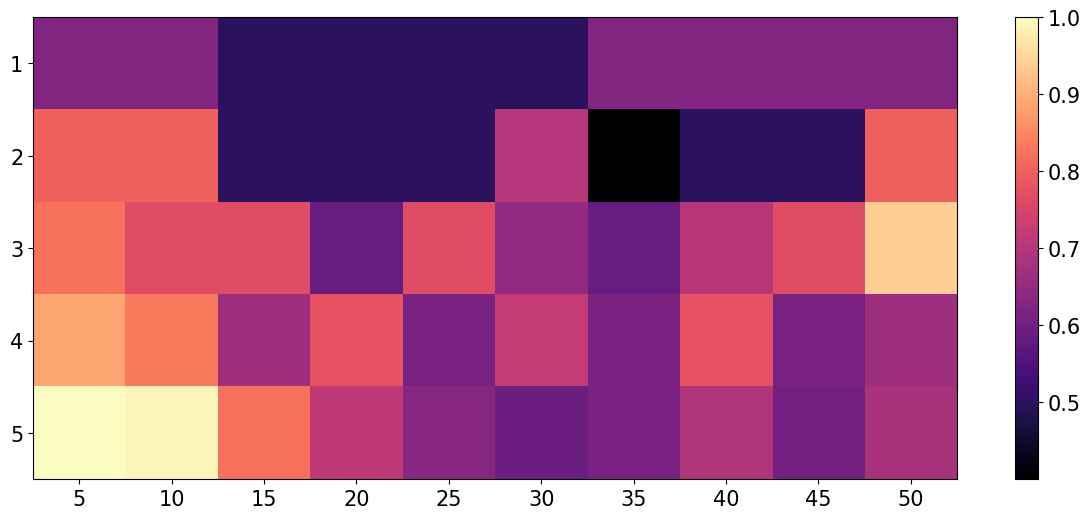

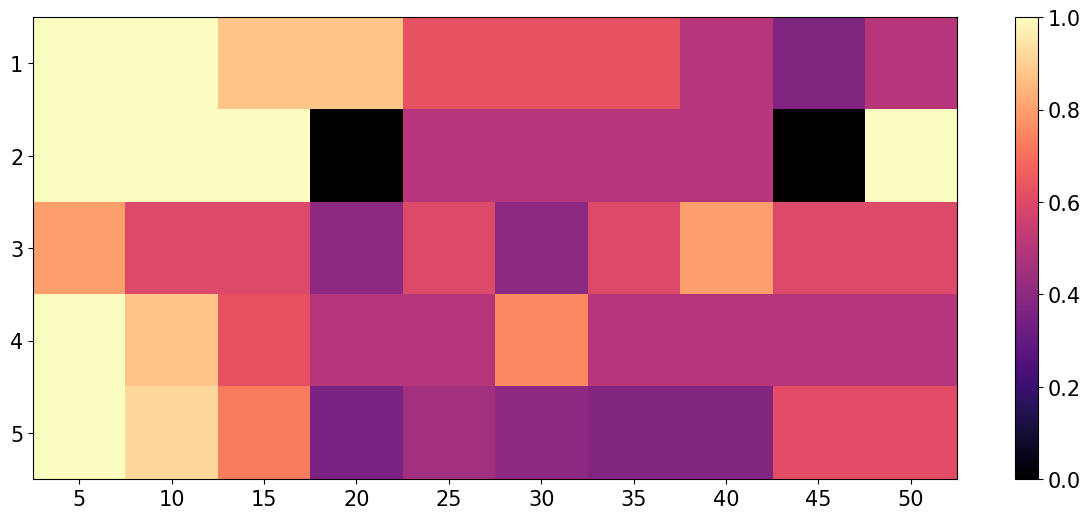

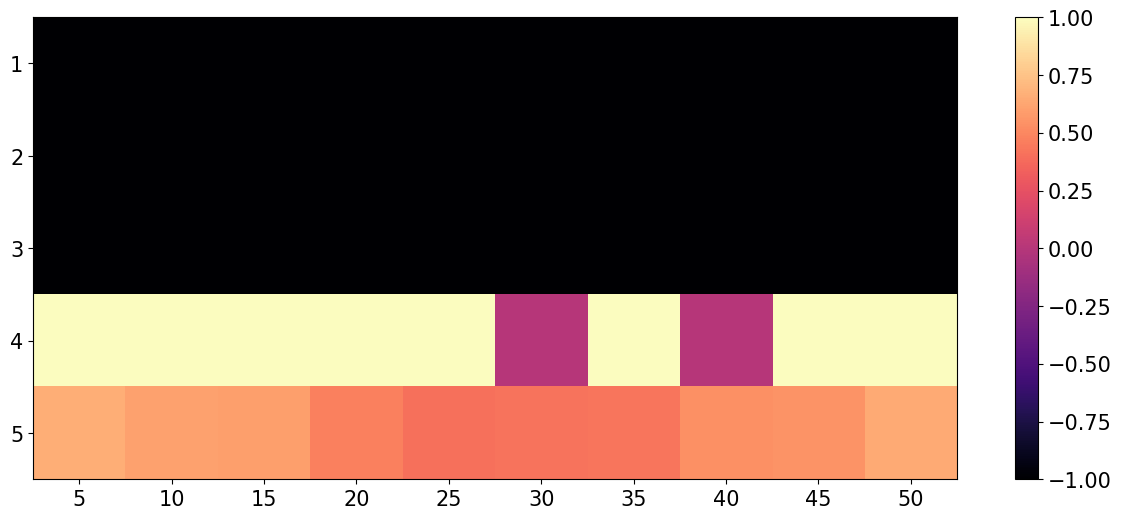

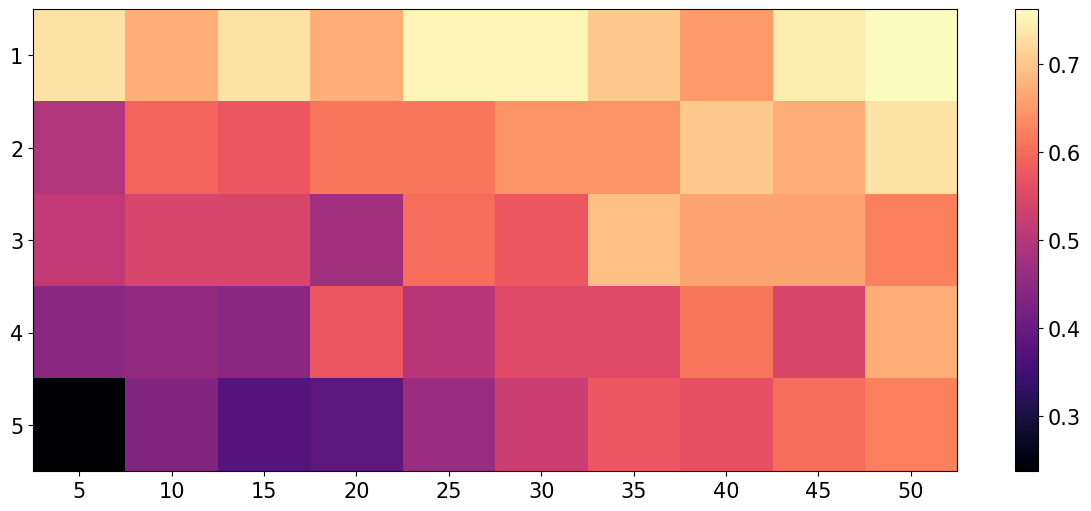

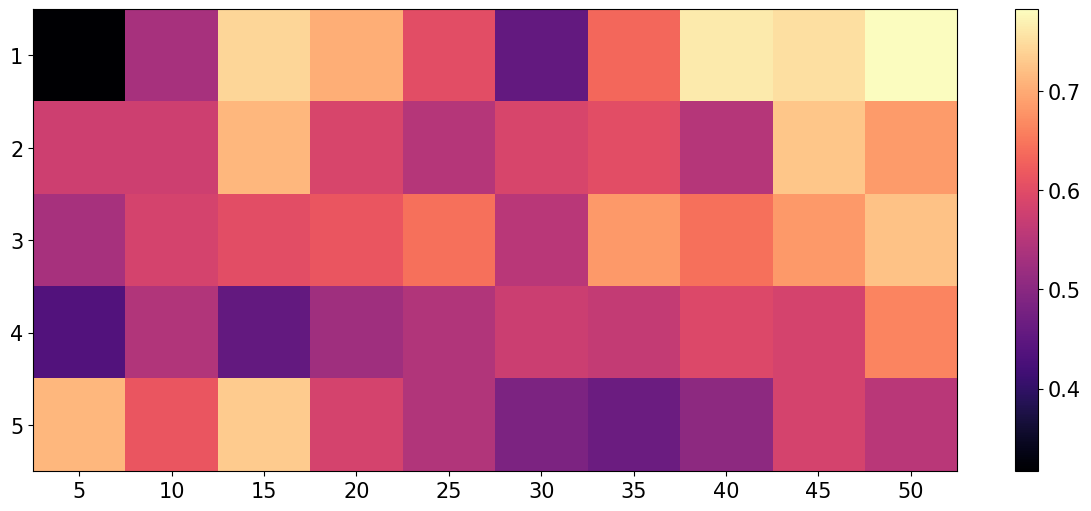

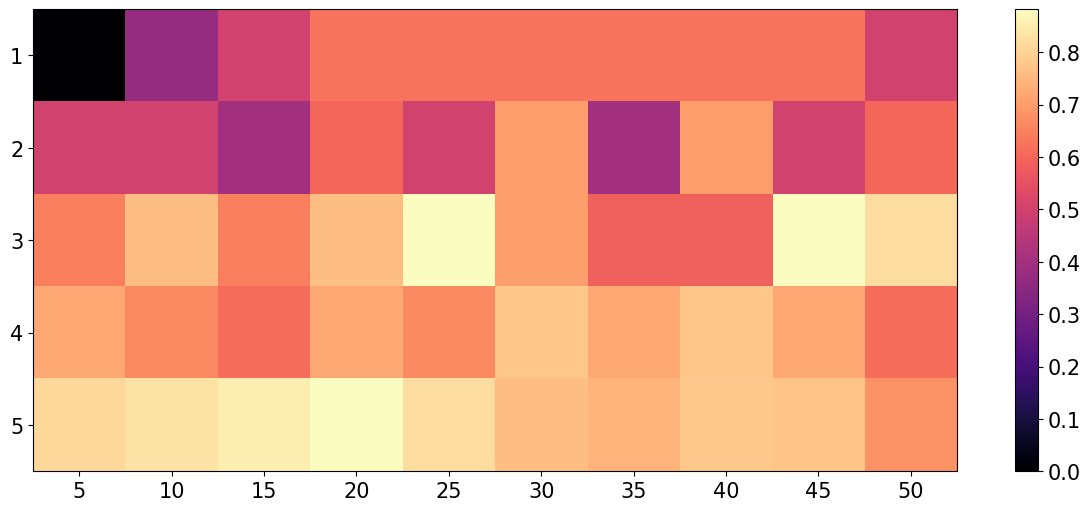

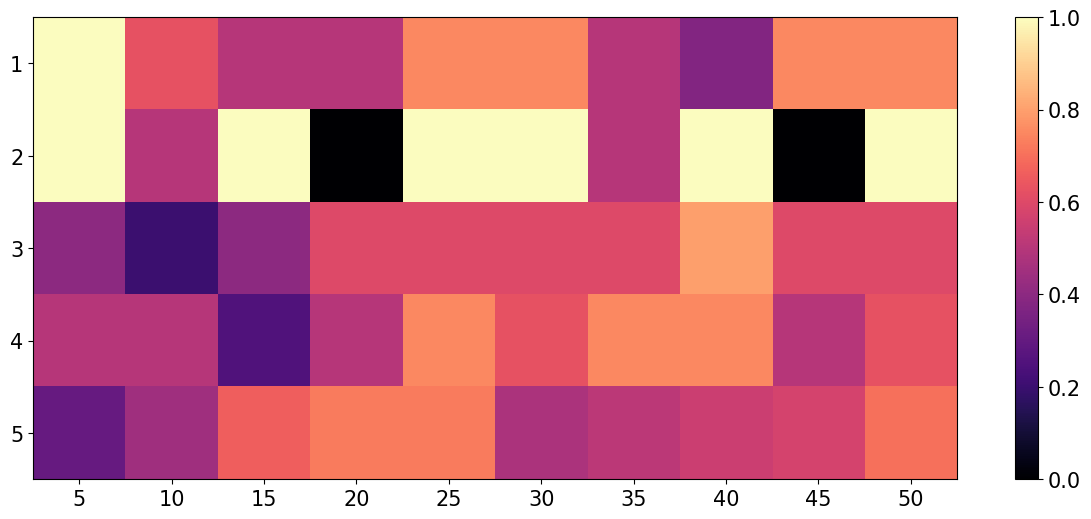

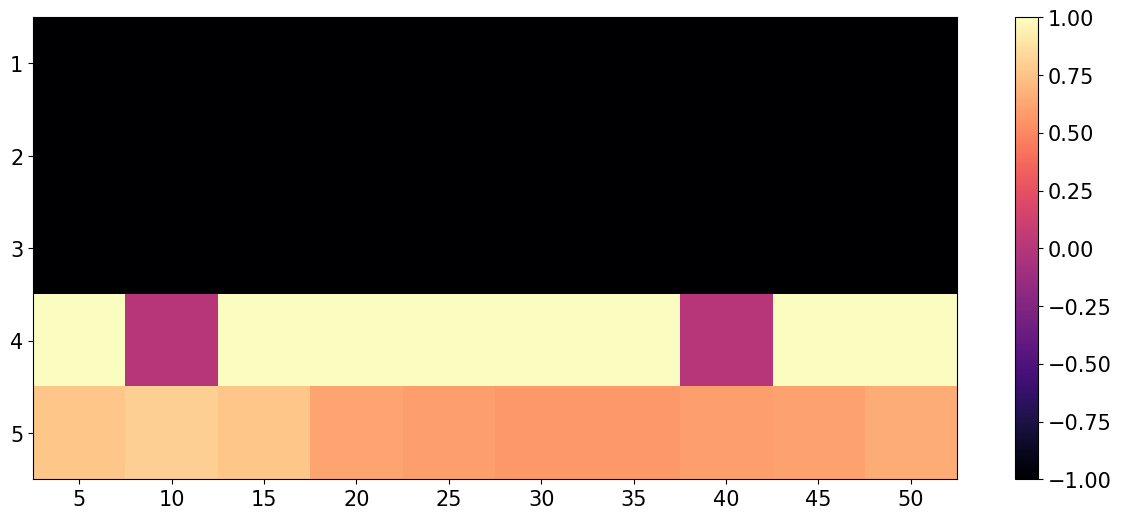

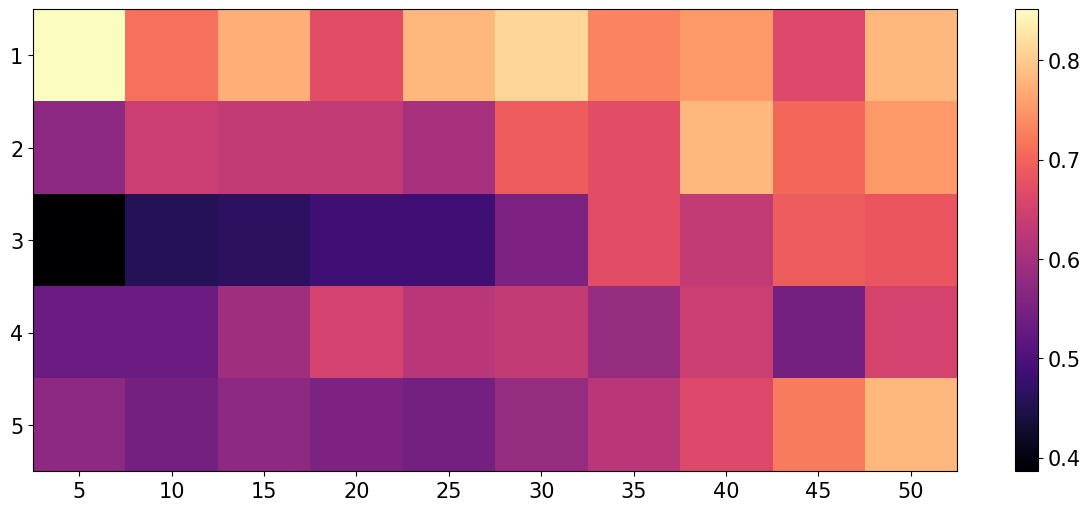

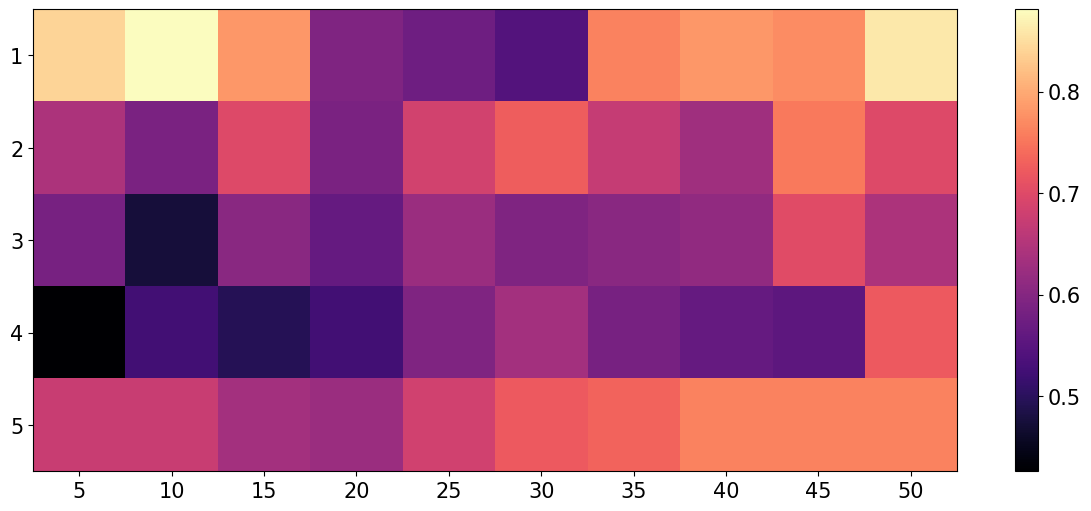

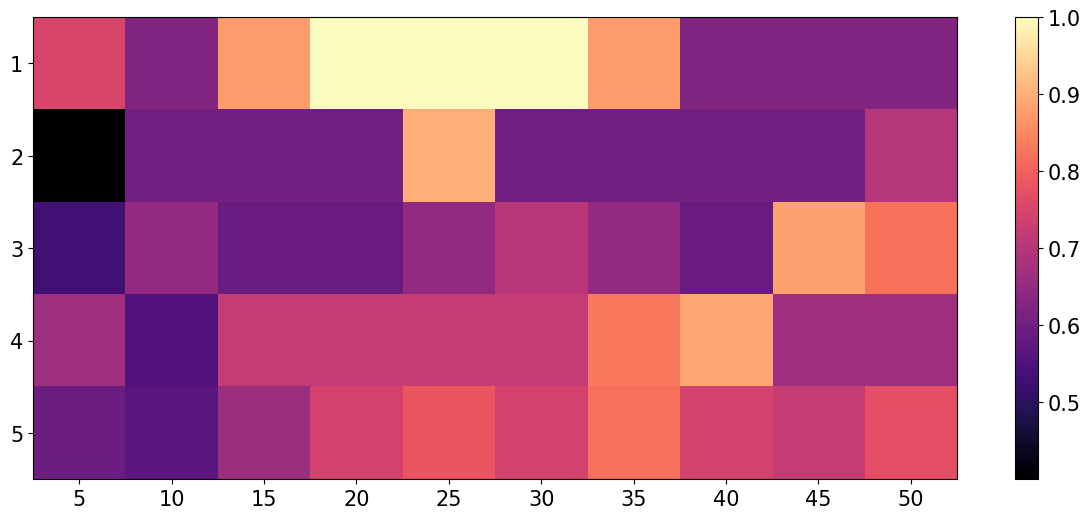

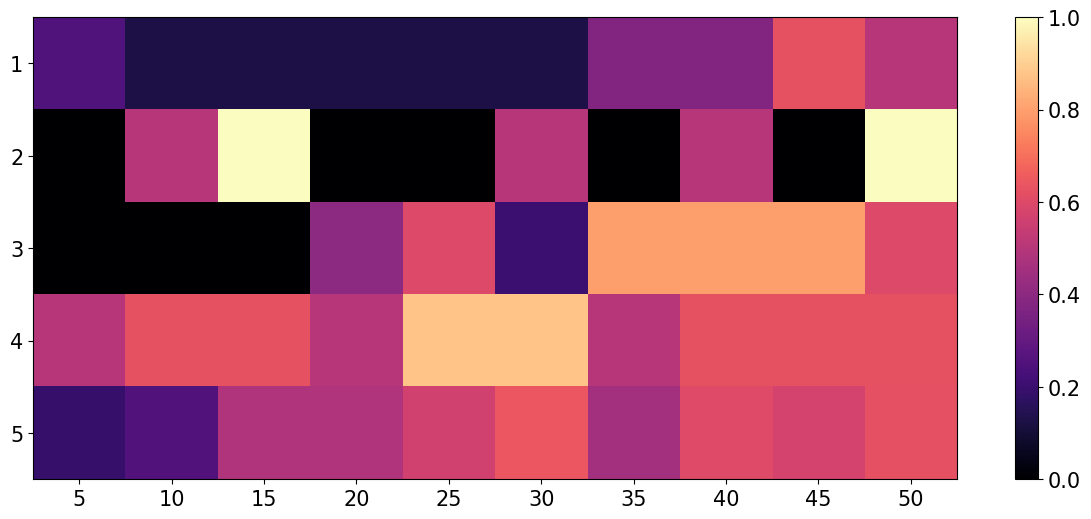

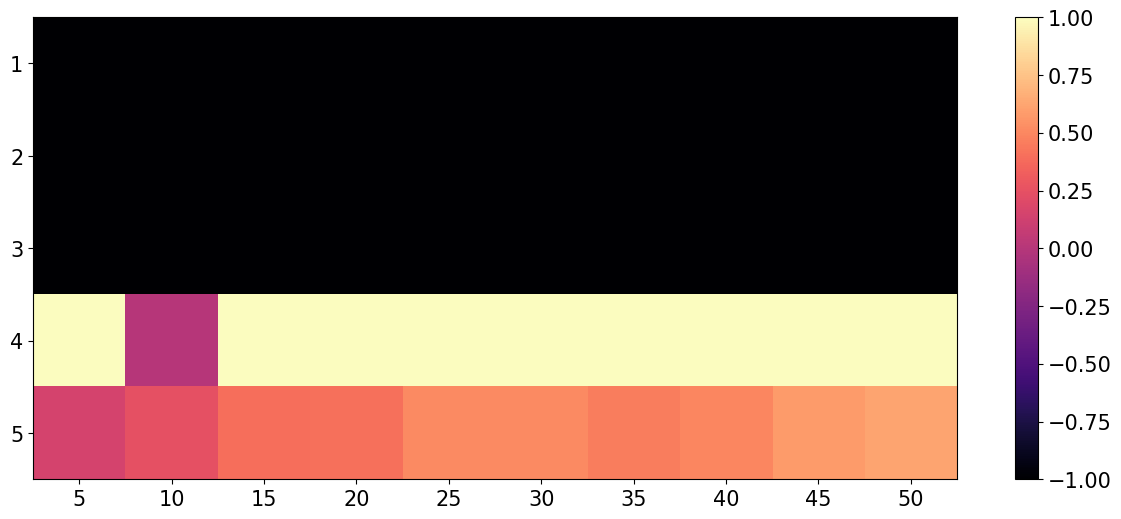

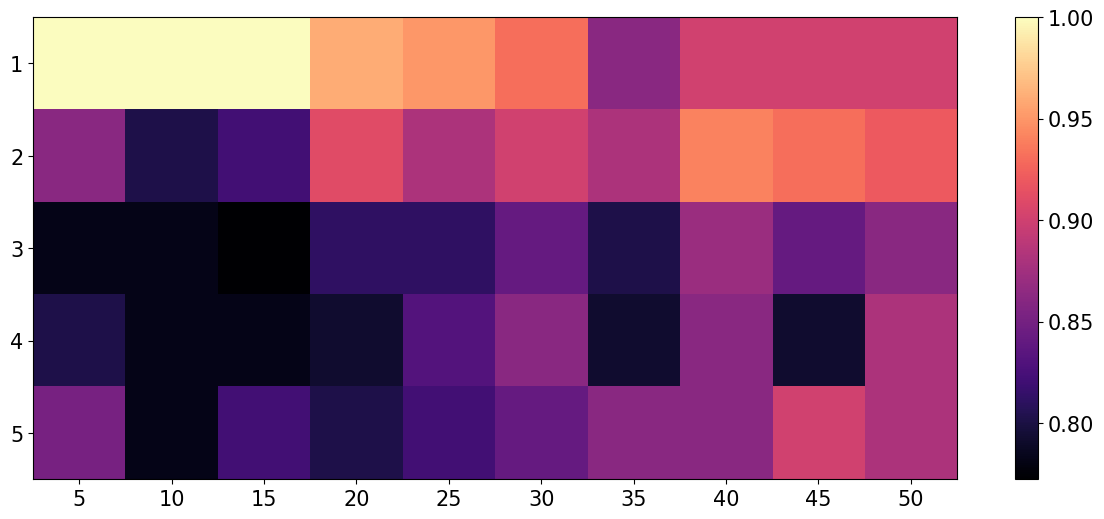

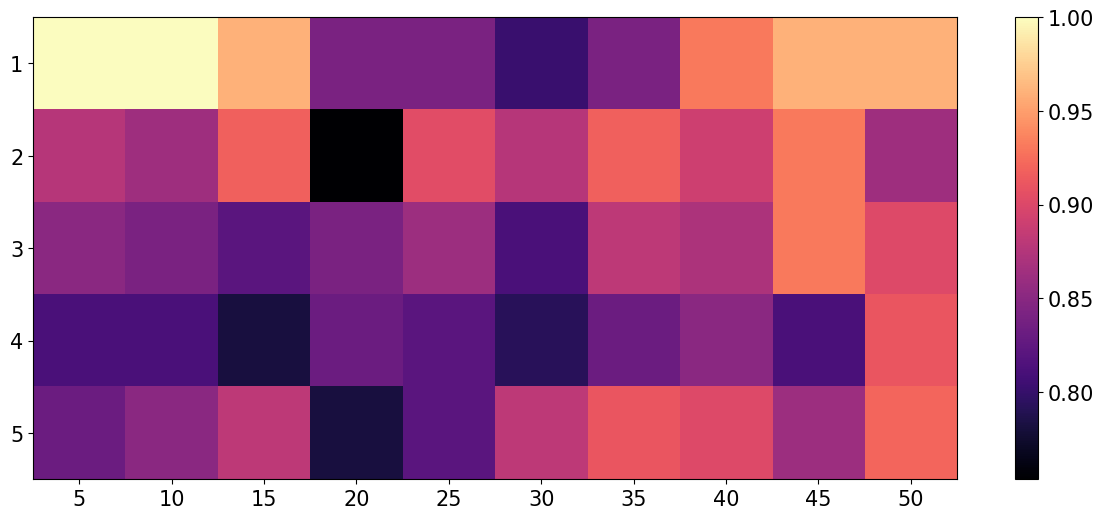

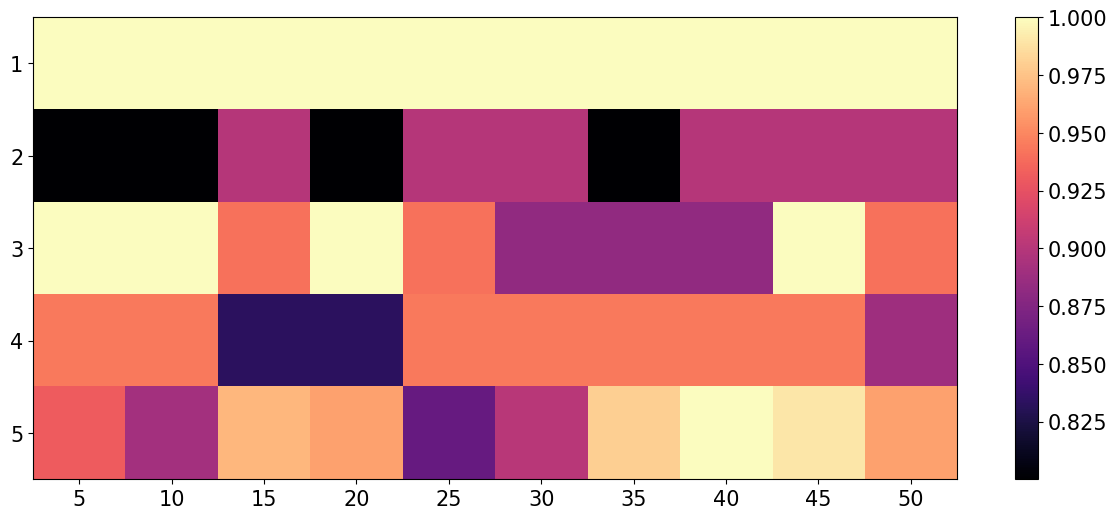

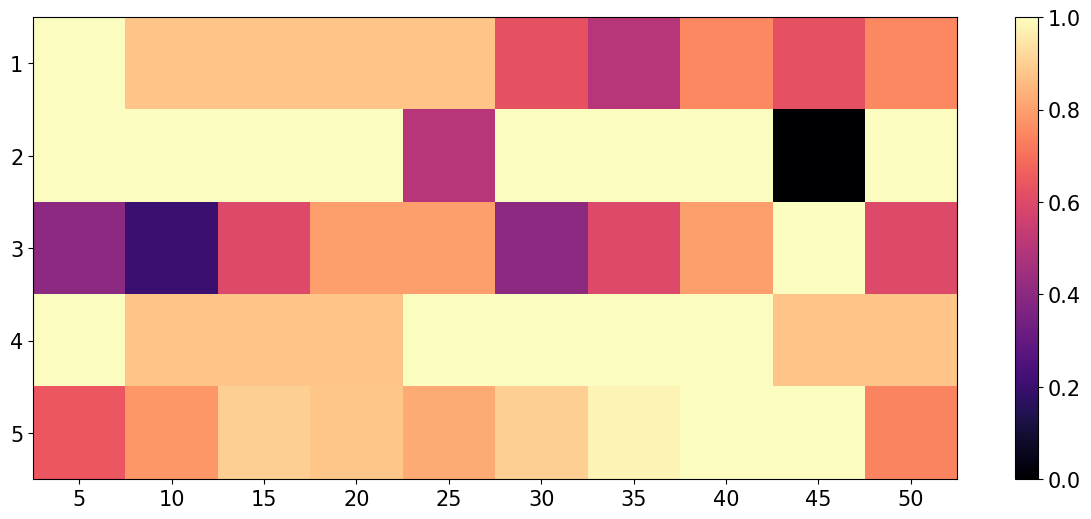

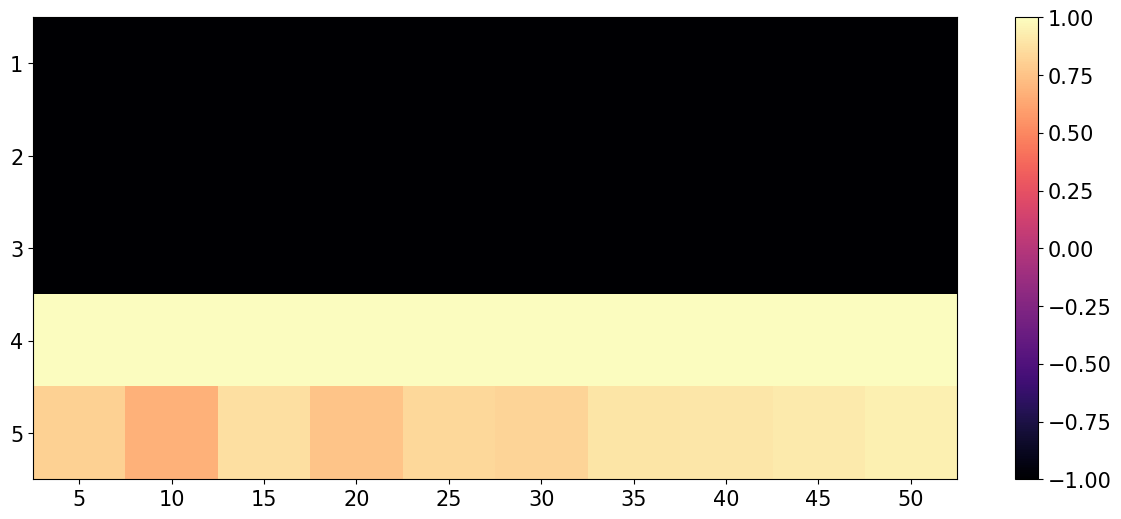

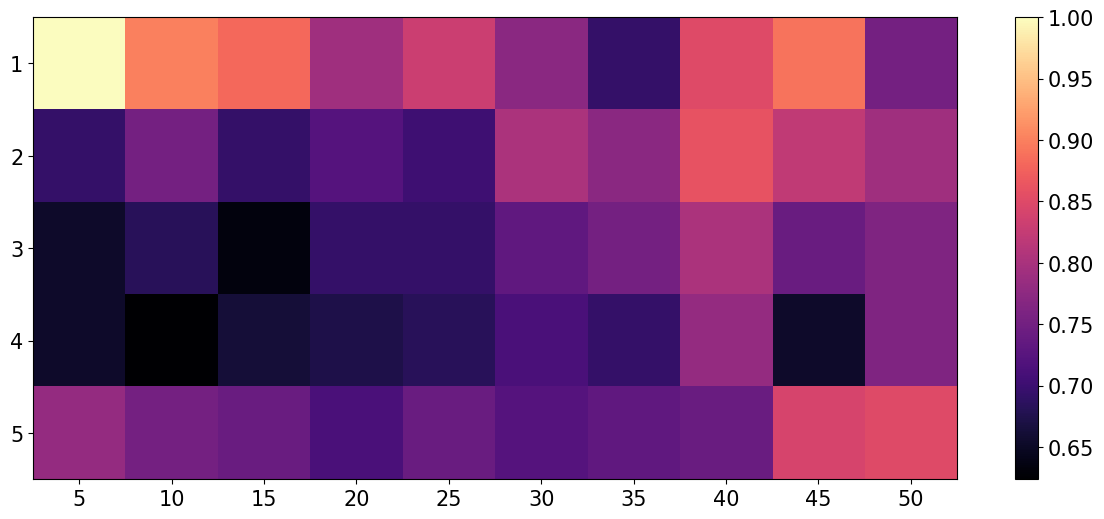

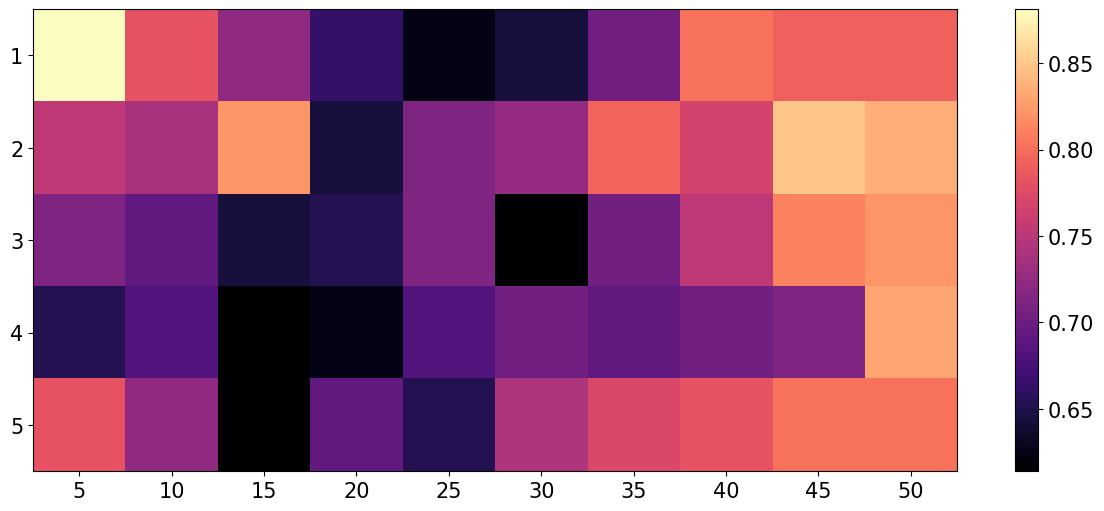

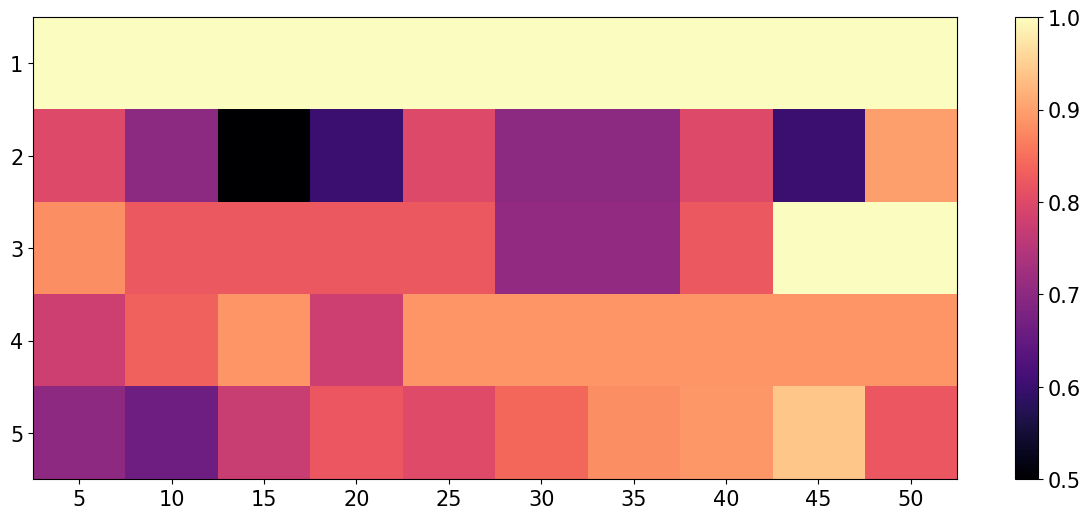

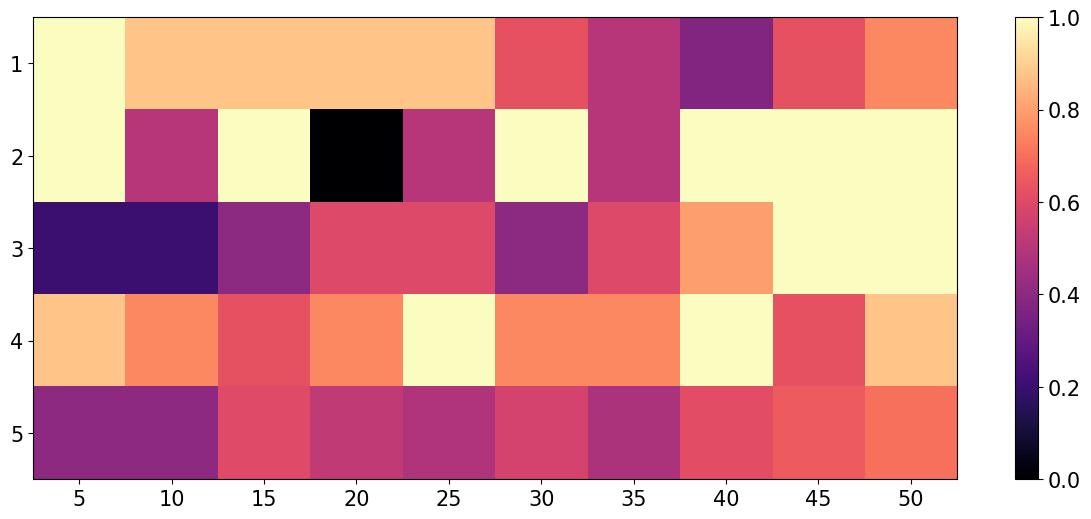

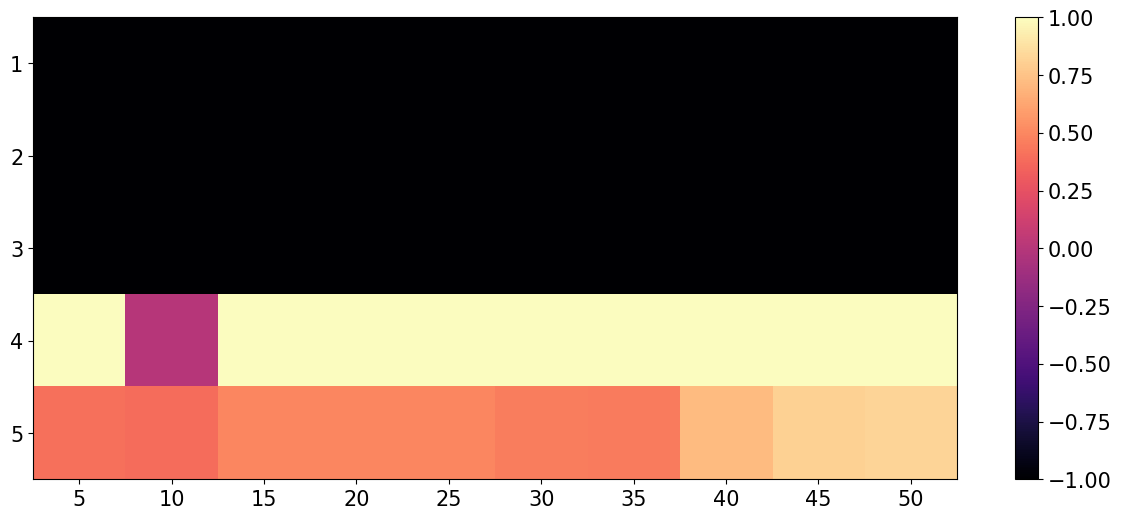

In [55]:
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
for i in range(5):
    for d1, d2 in zip(small_d, large_d):
        heatmap(excel_sheet_mname=models[i], fixed_axis = 'nodule size', fixed_axis_parameter=f'{d1}  < d <= {d2}', figname=models[i]+'_nsize_'+f'{d1} -d- {d2}'+'_score-VS-distance', figaxes = ['radius', 'score'], arr_shape=(5, 10))

C:\Users\peter\AppData\Local\Temp\ipykernel_10812\3082014915.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,6))


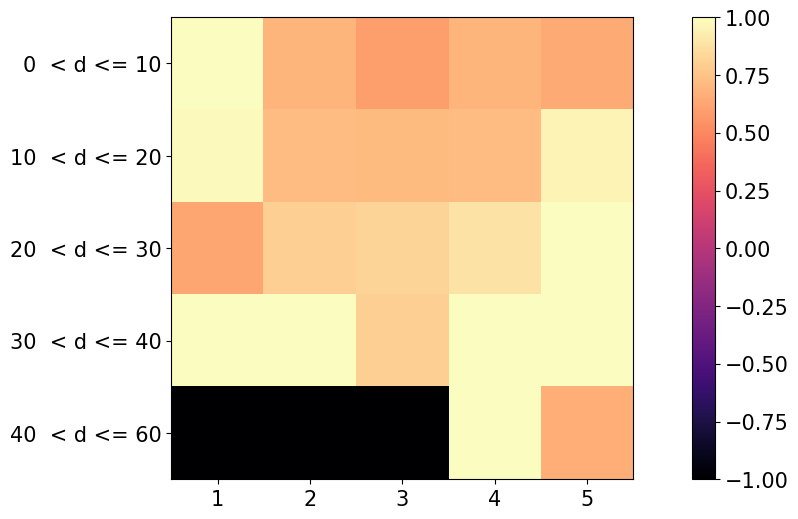

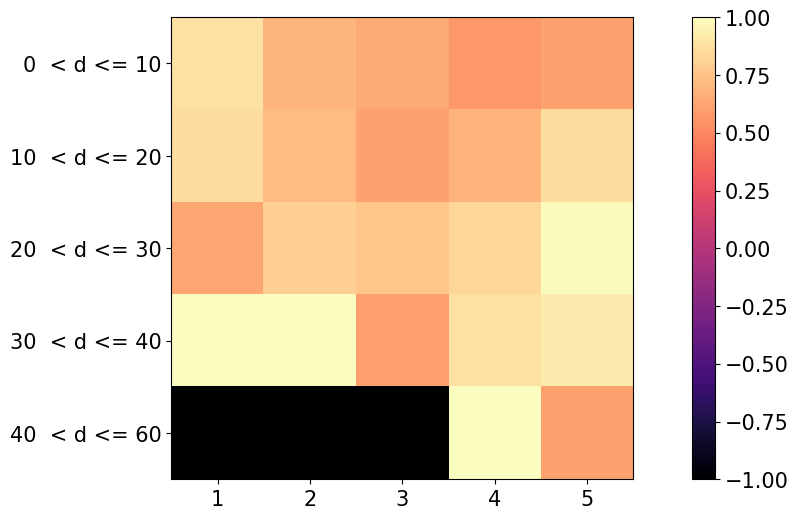

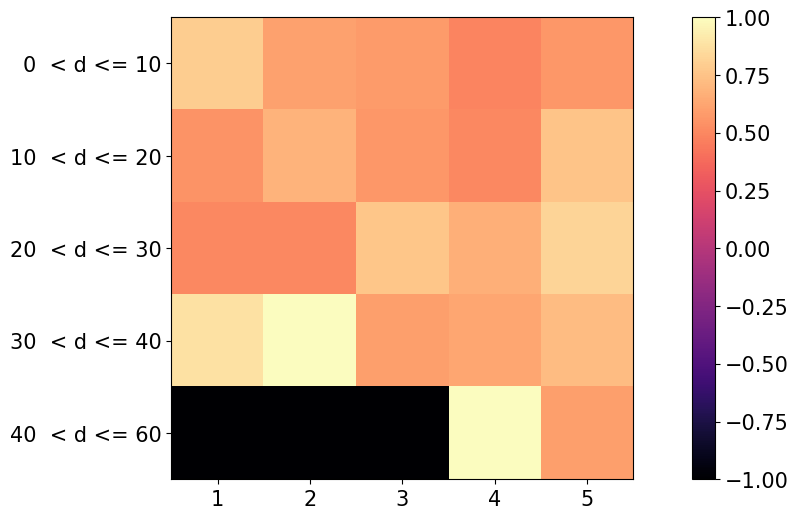

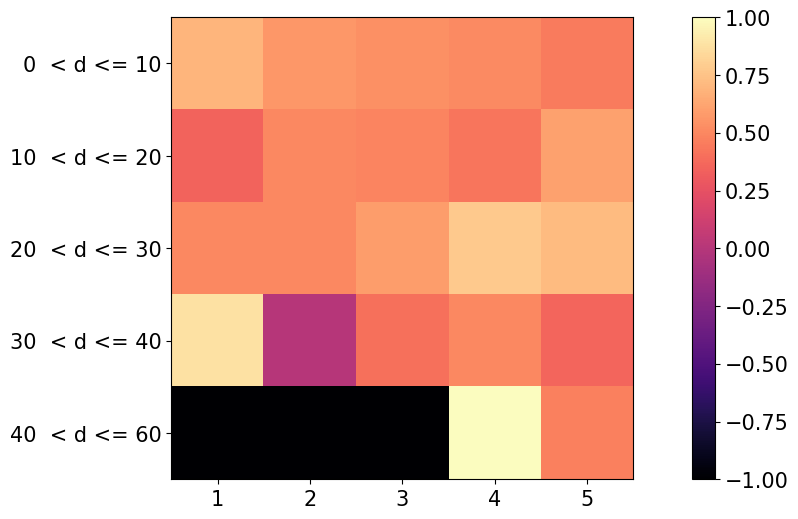

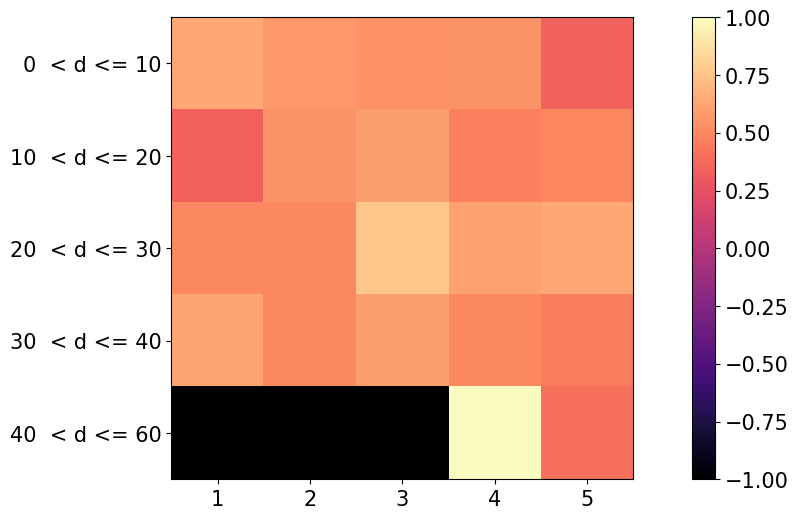

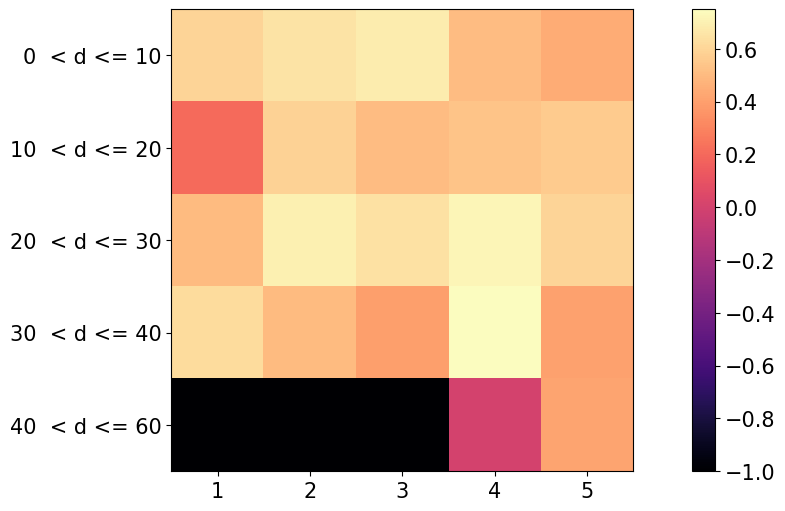

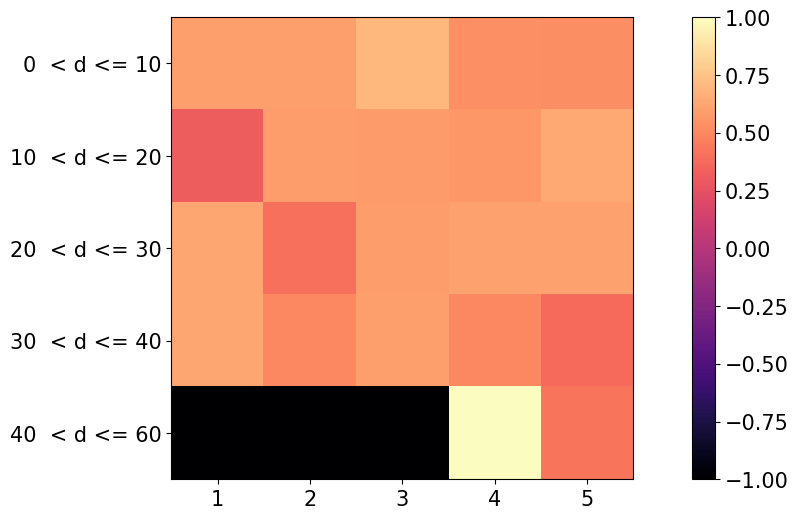

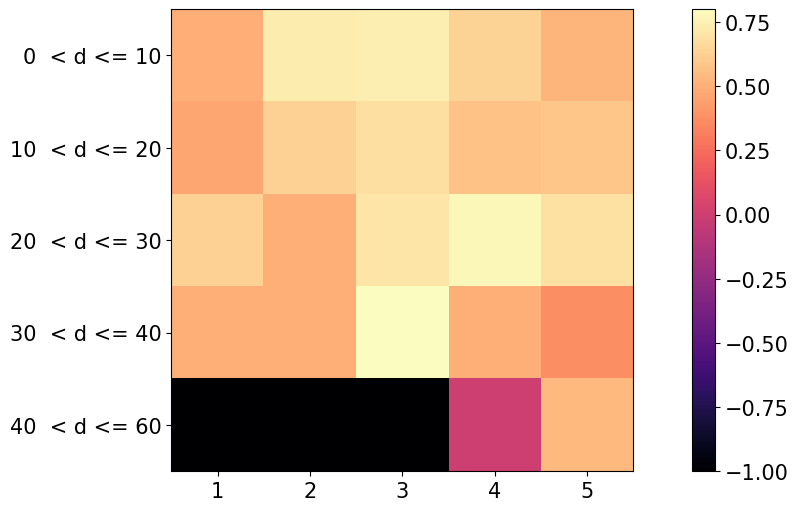

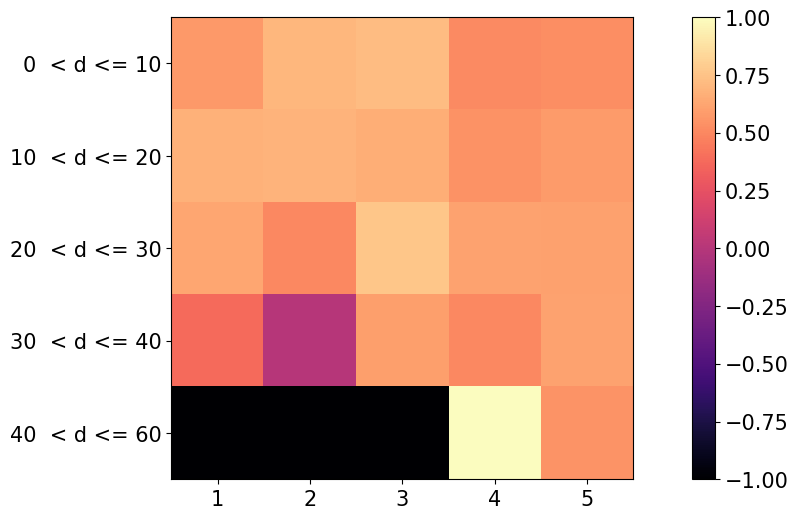

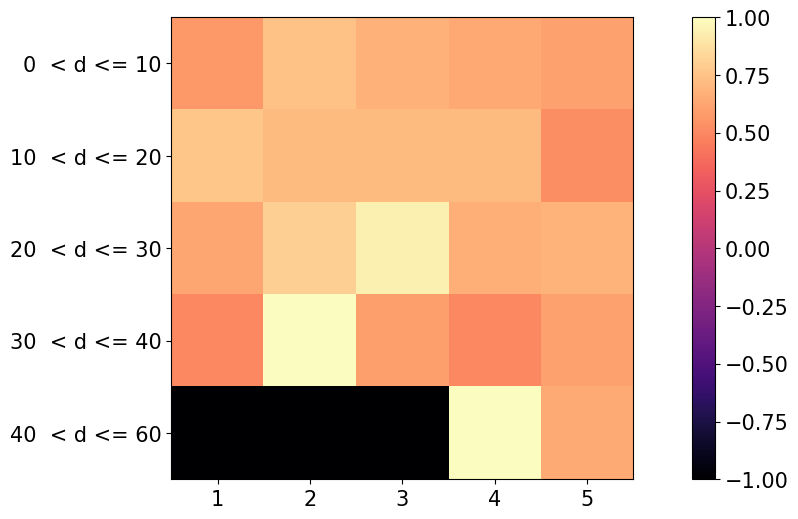

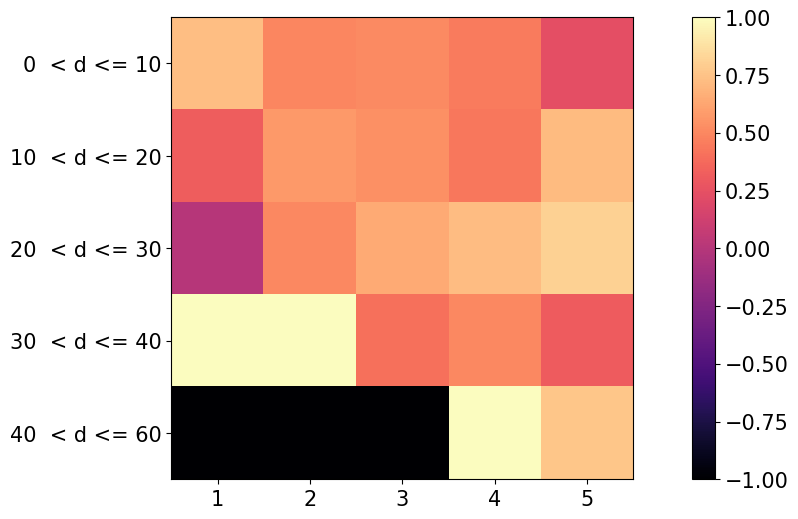

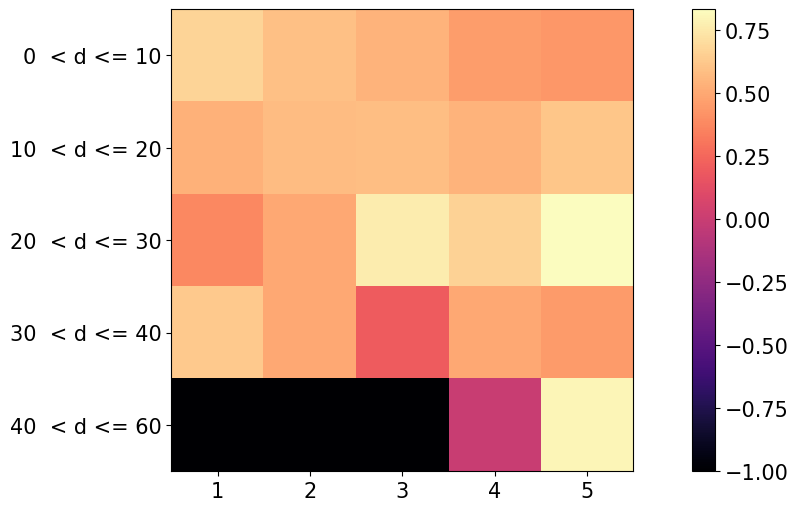

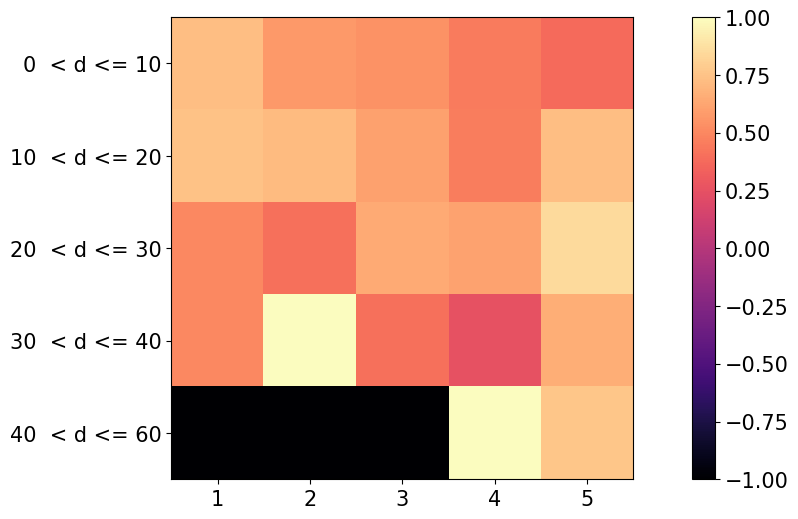

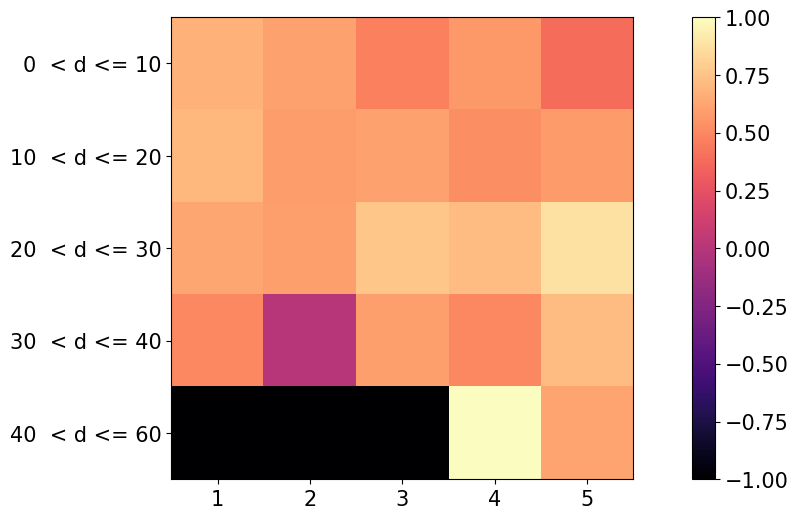

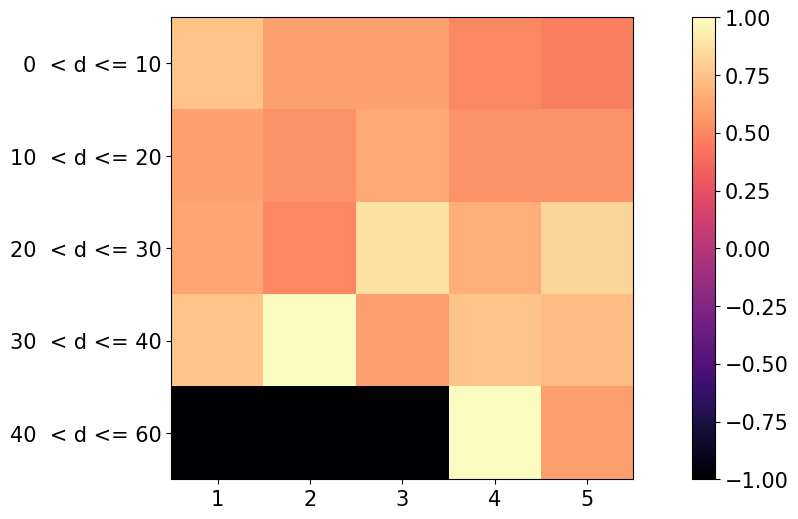

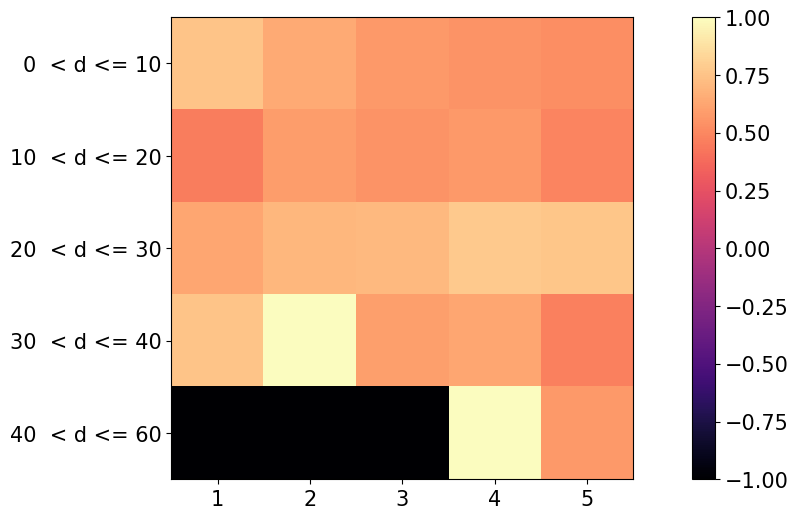

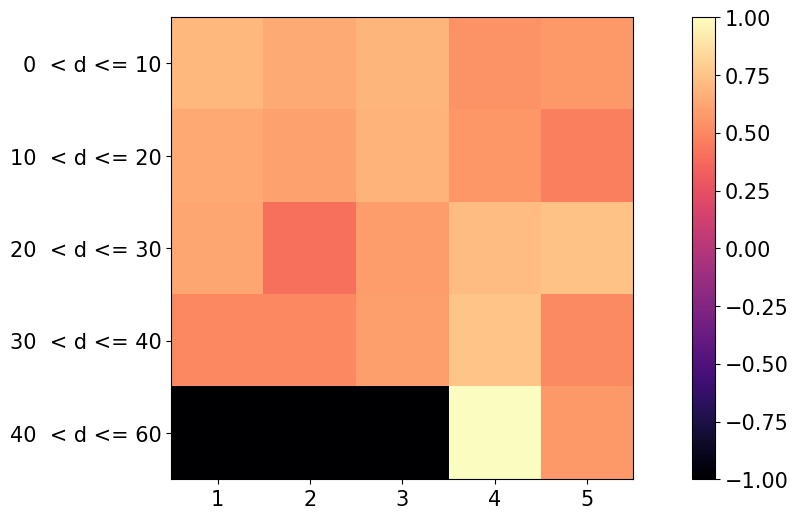

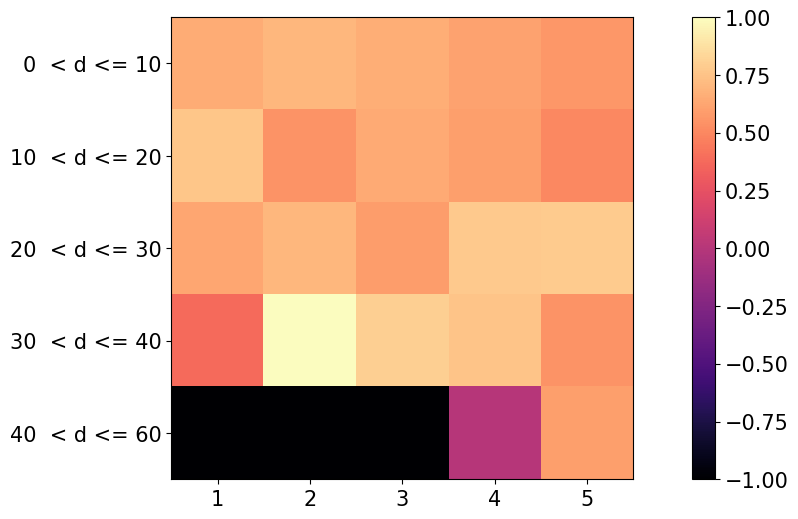

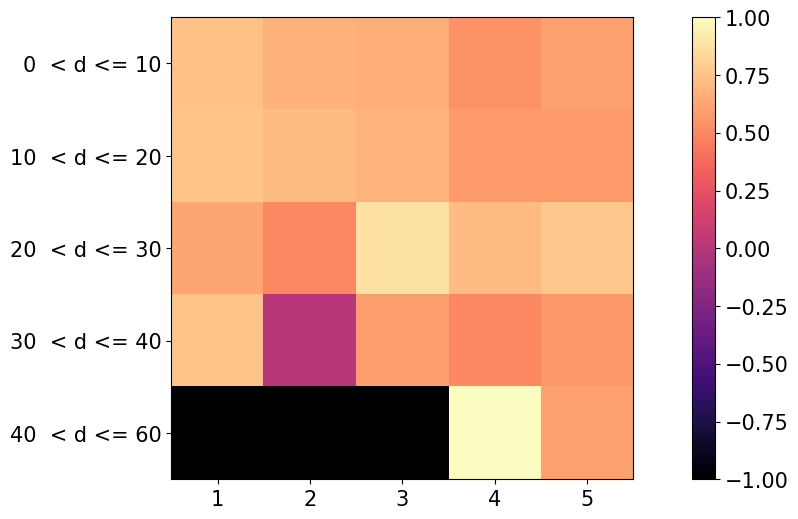

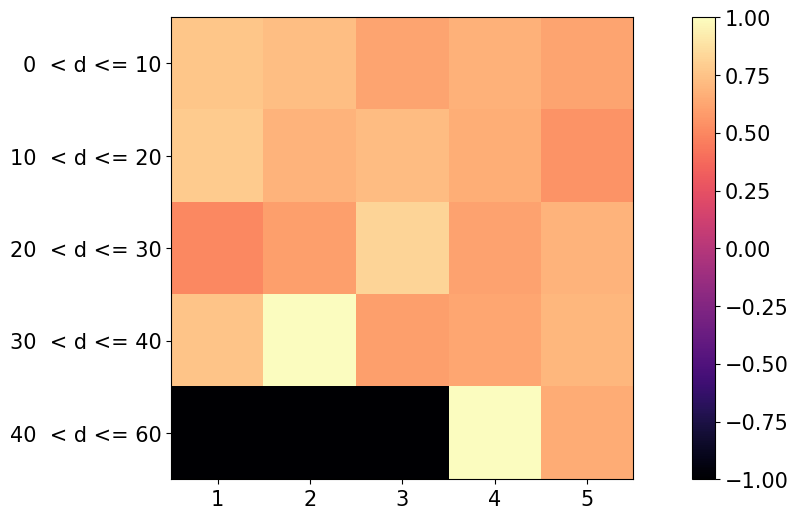

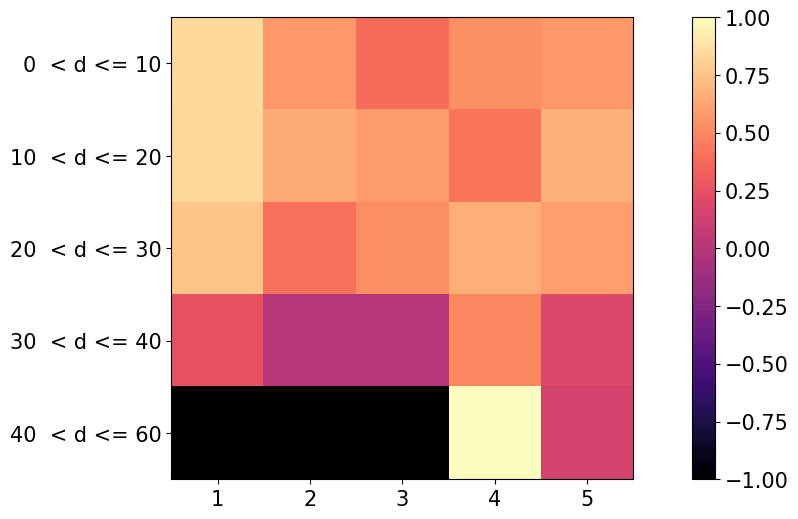

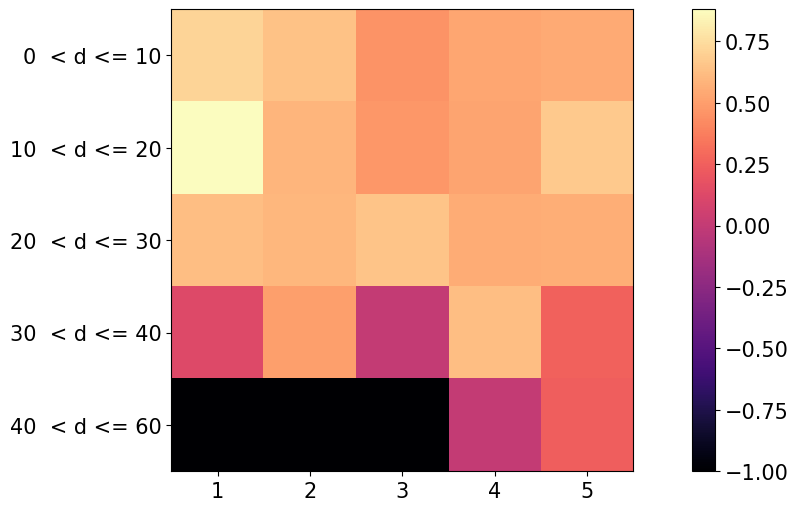

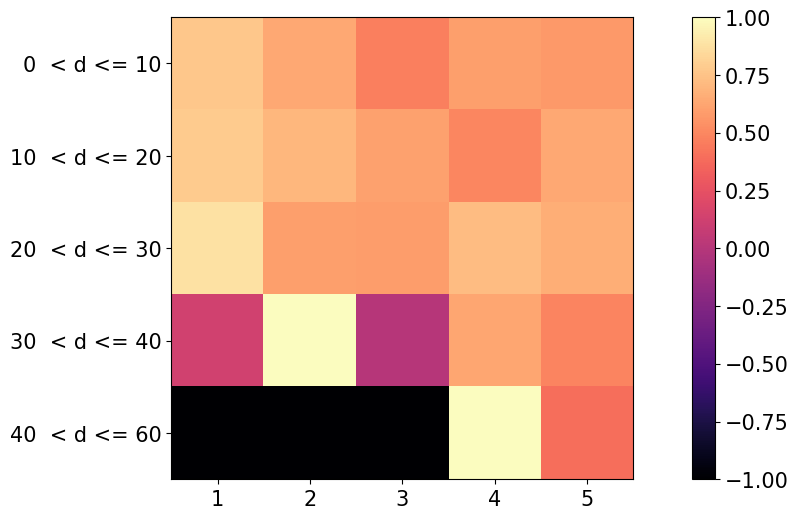

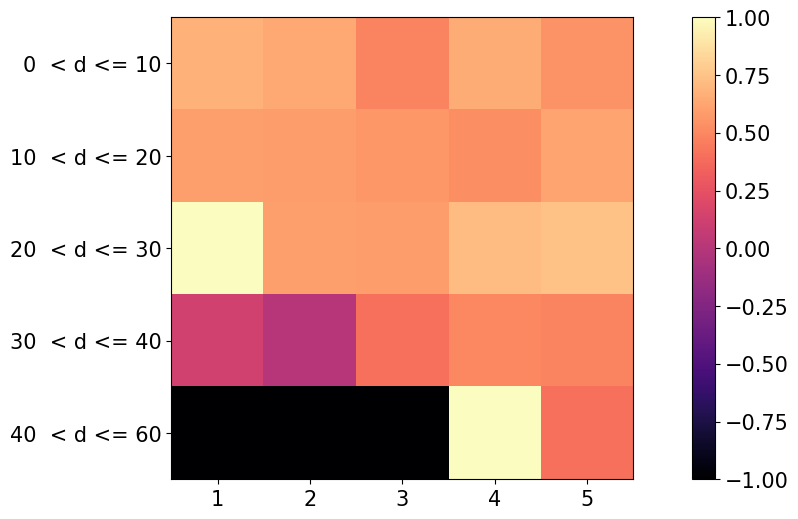

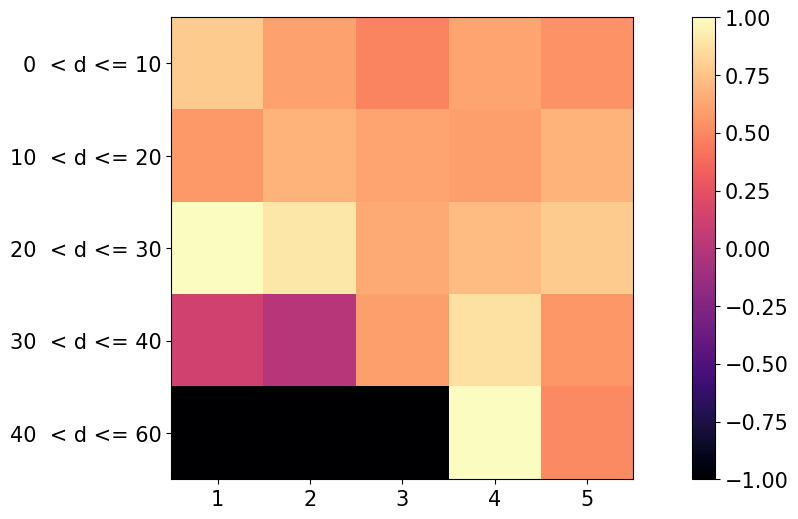

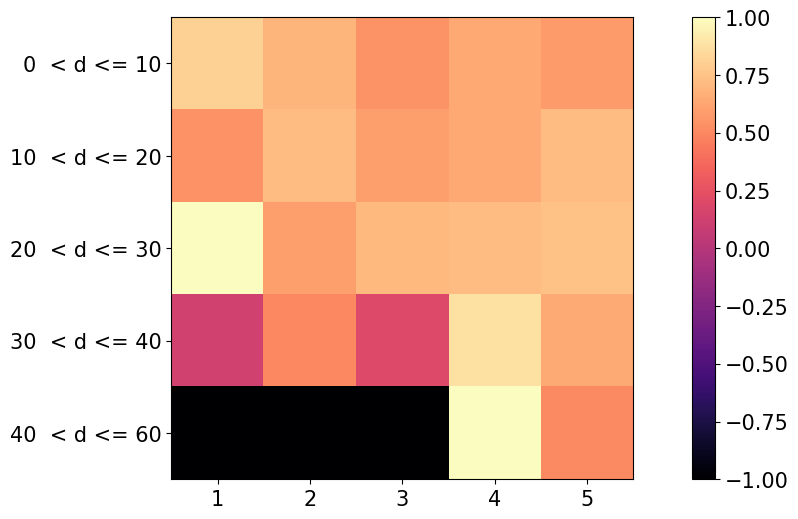

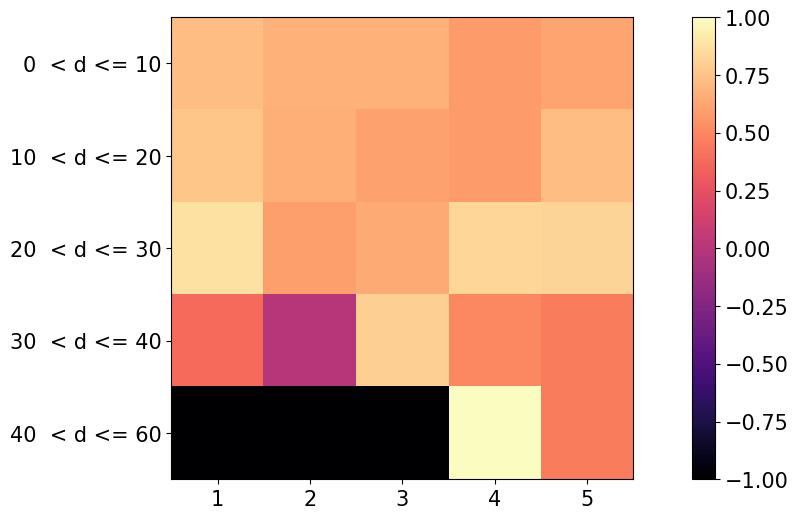

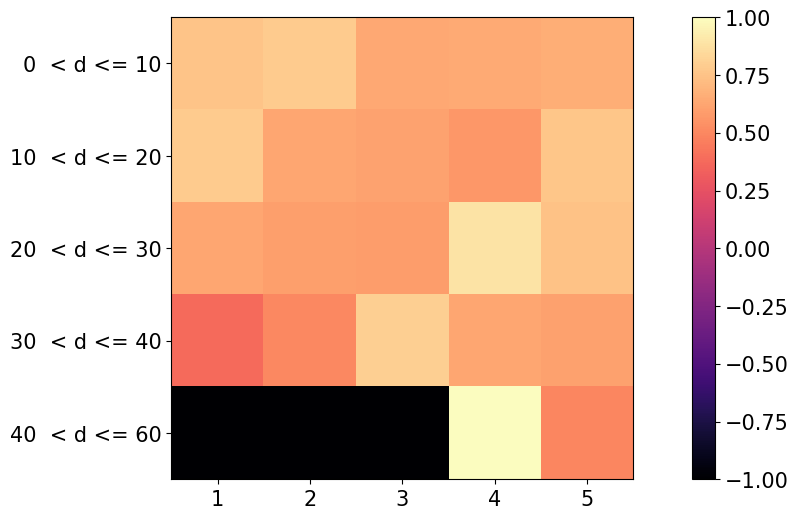

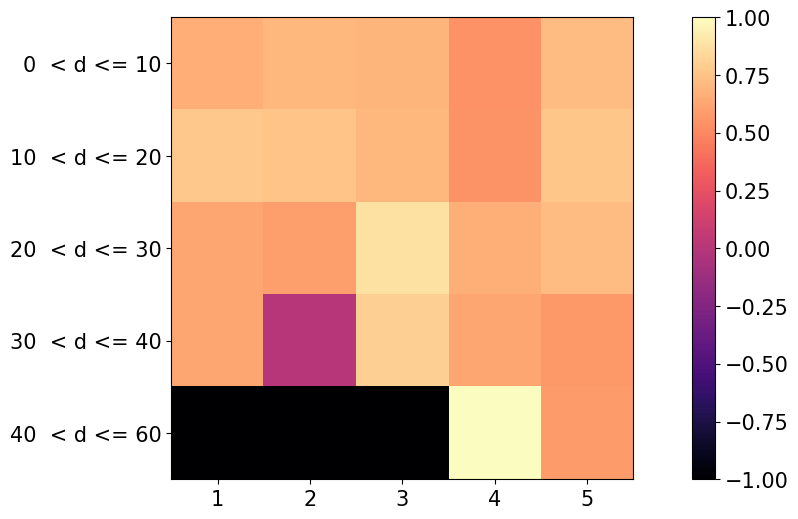

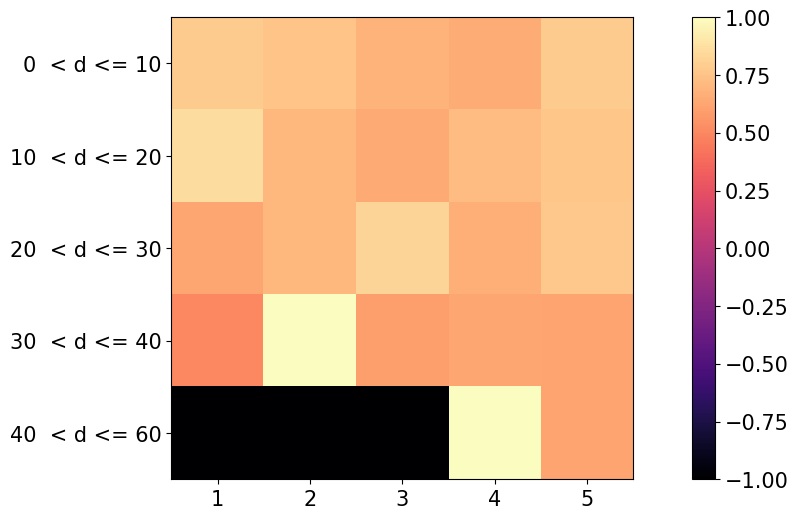

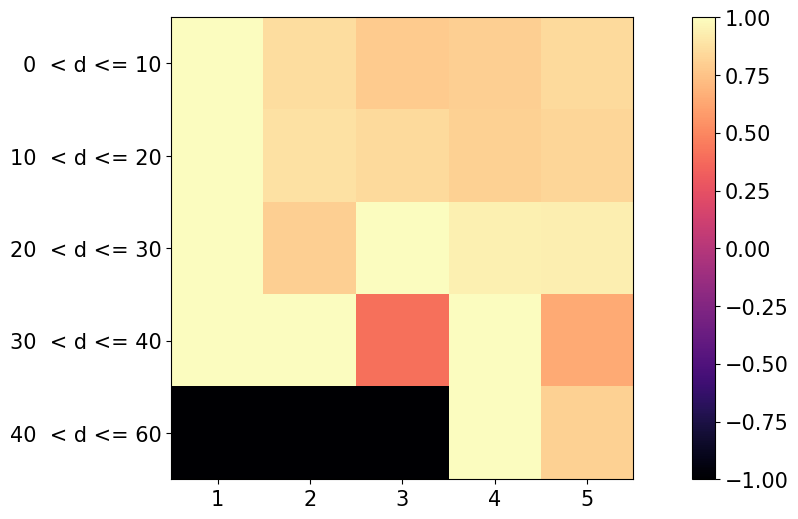

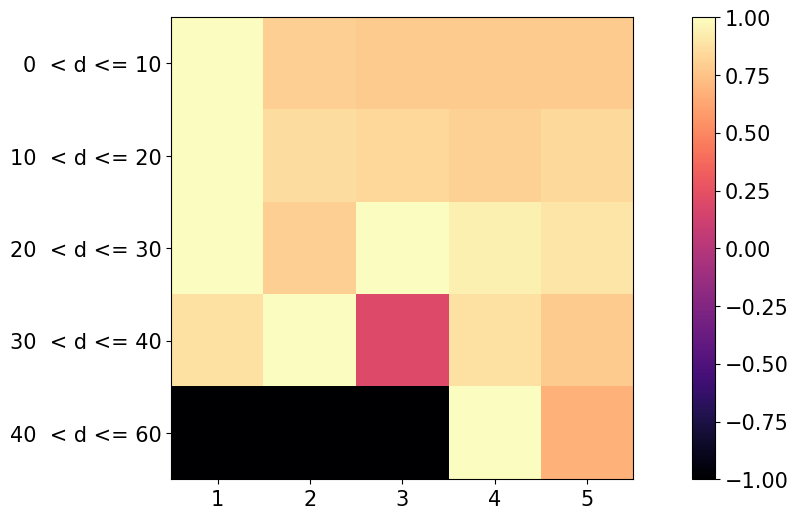

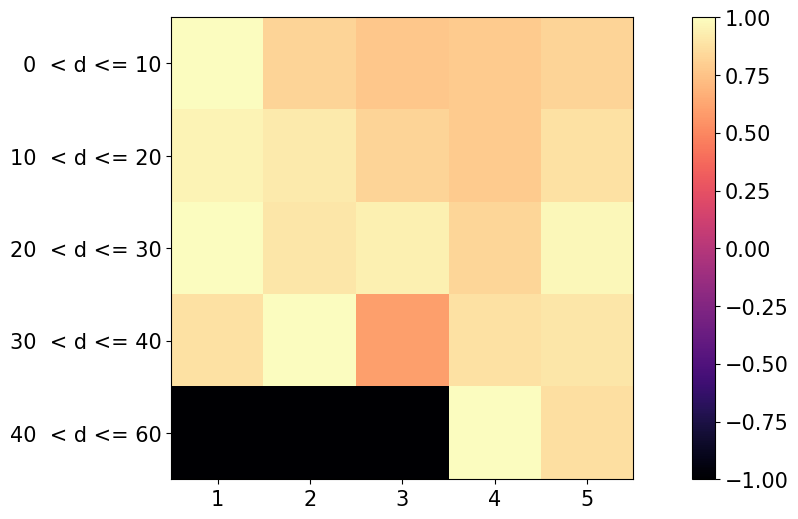

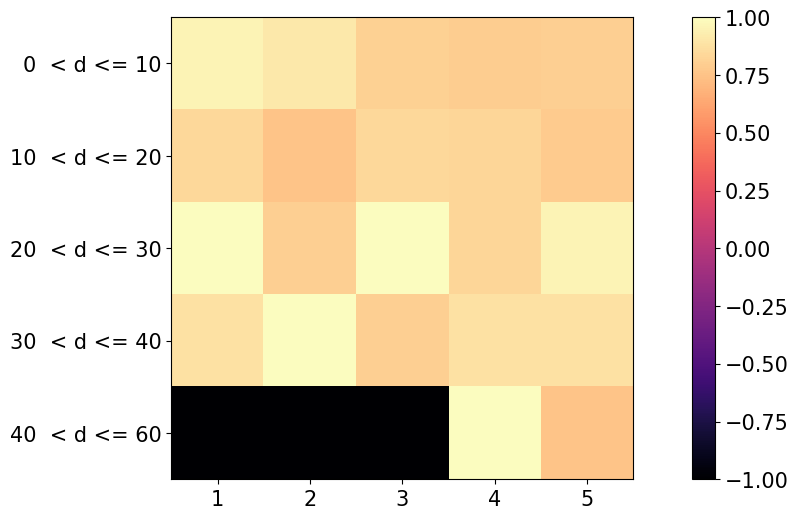

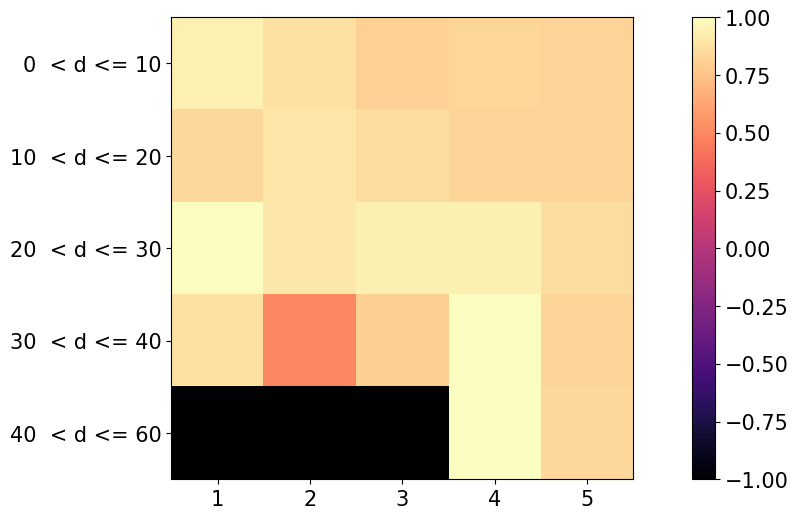

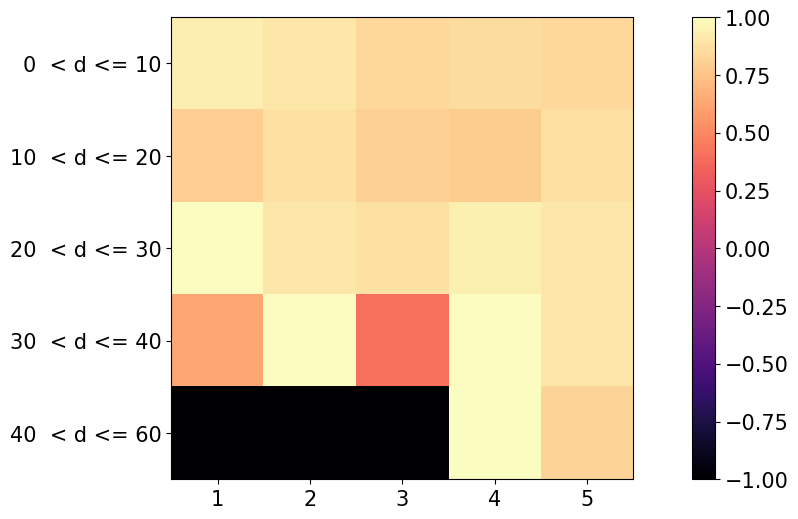

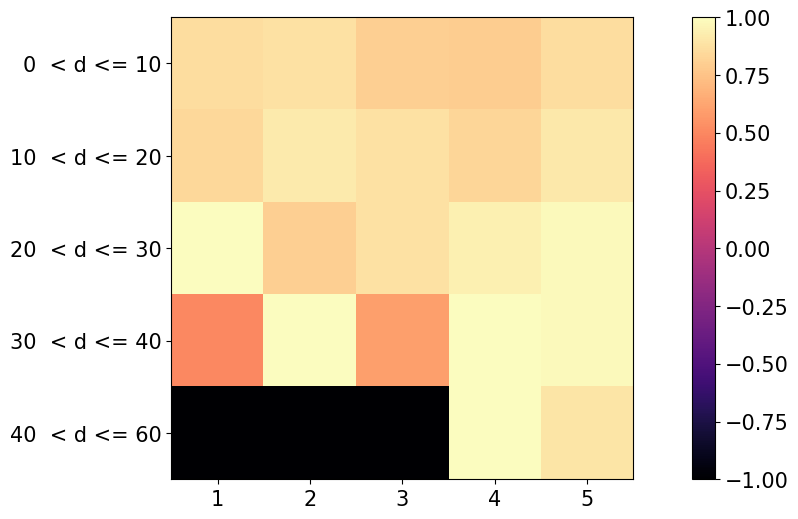

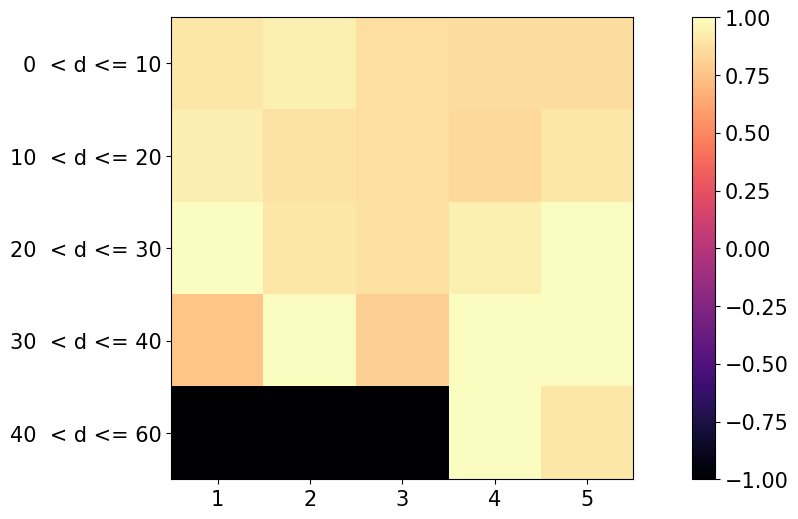

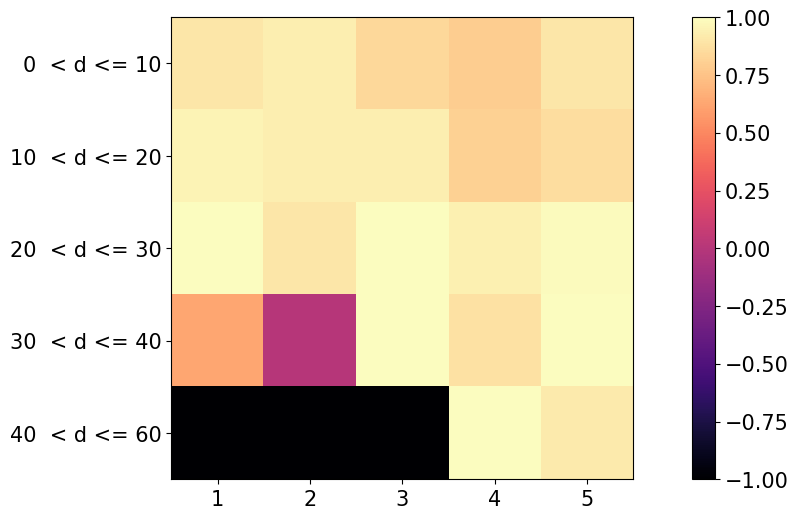

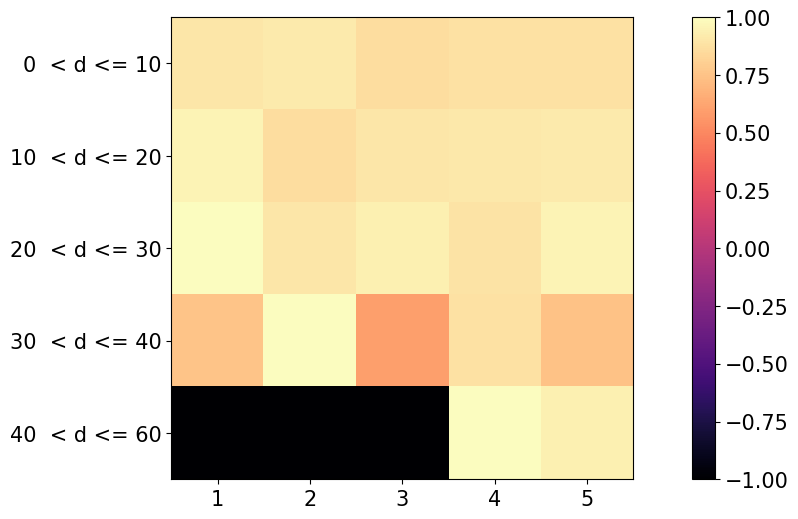

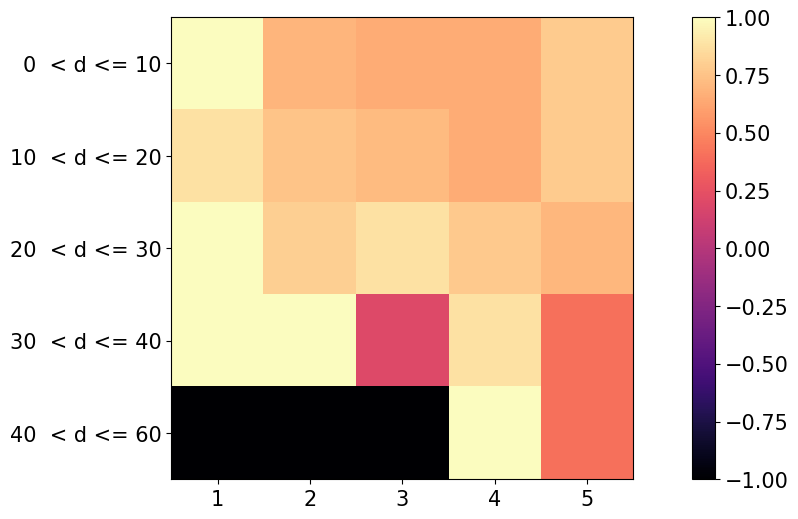

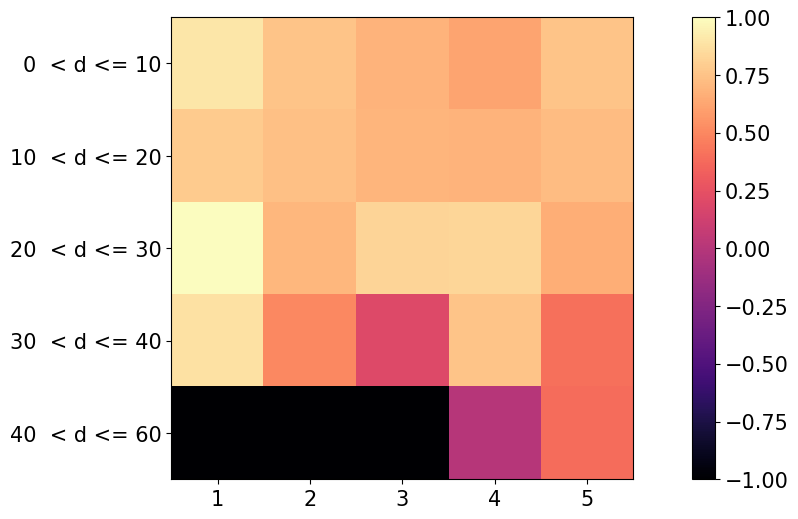

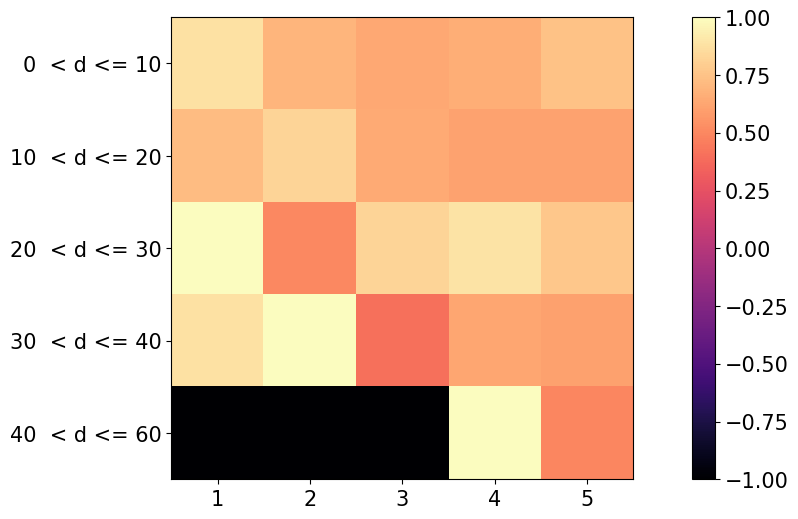

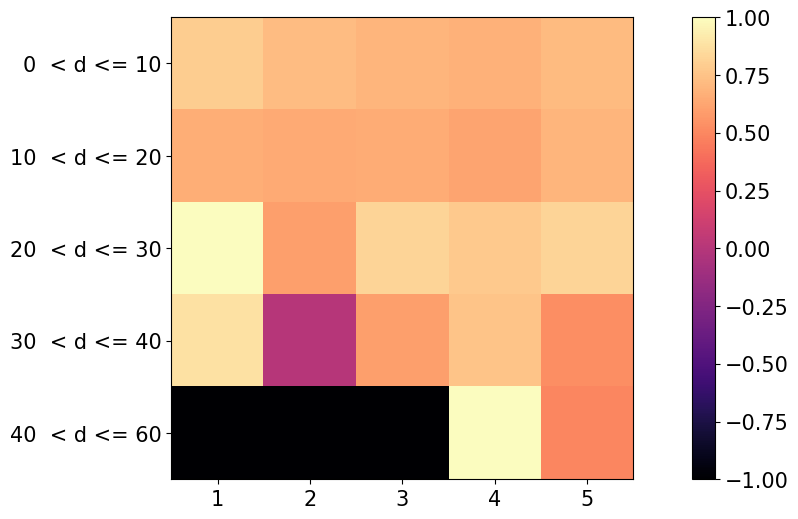

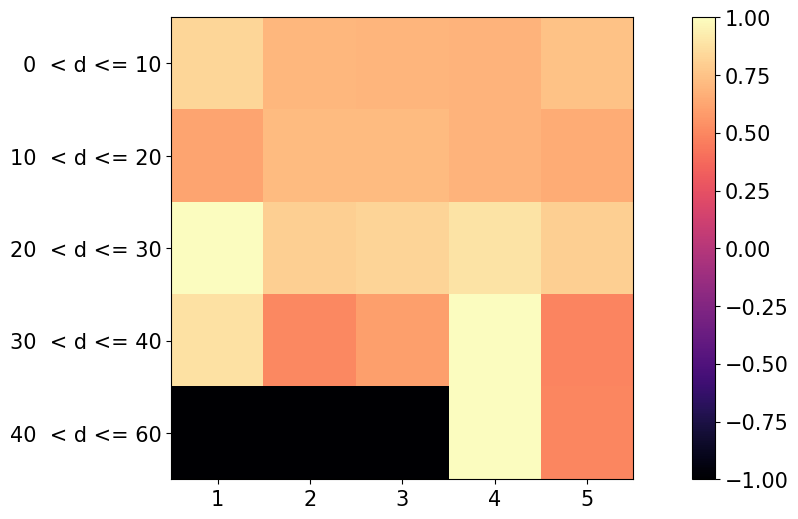

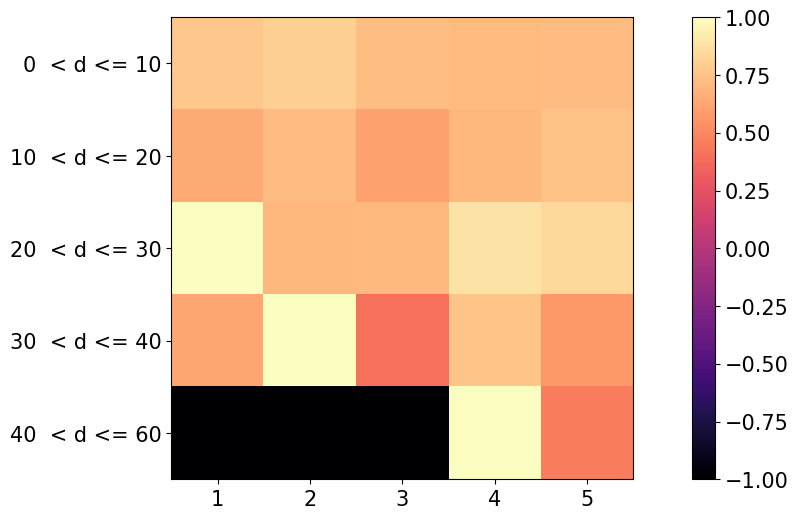

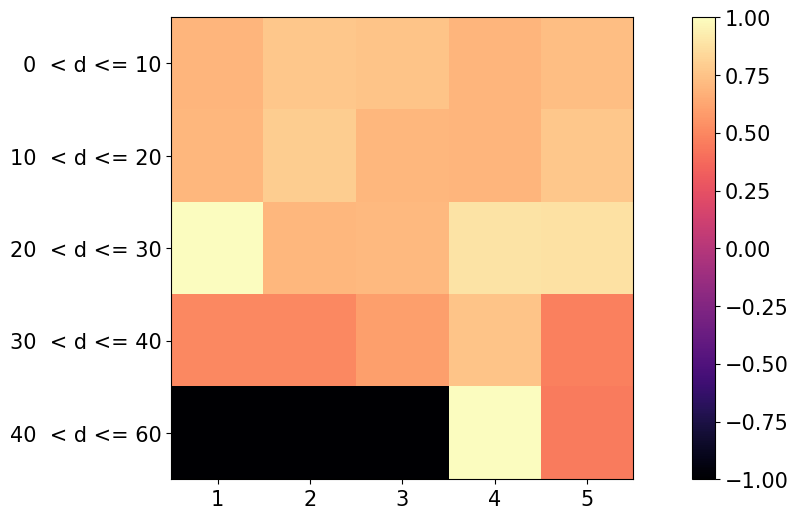

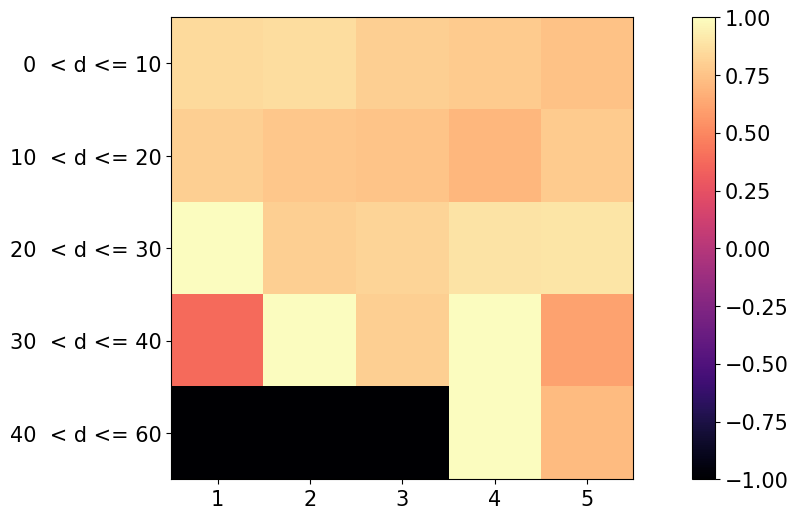

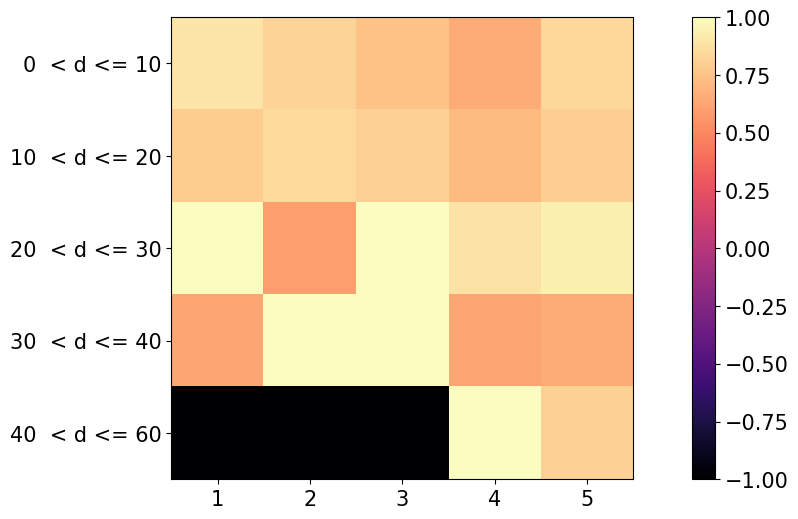

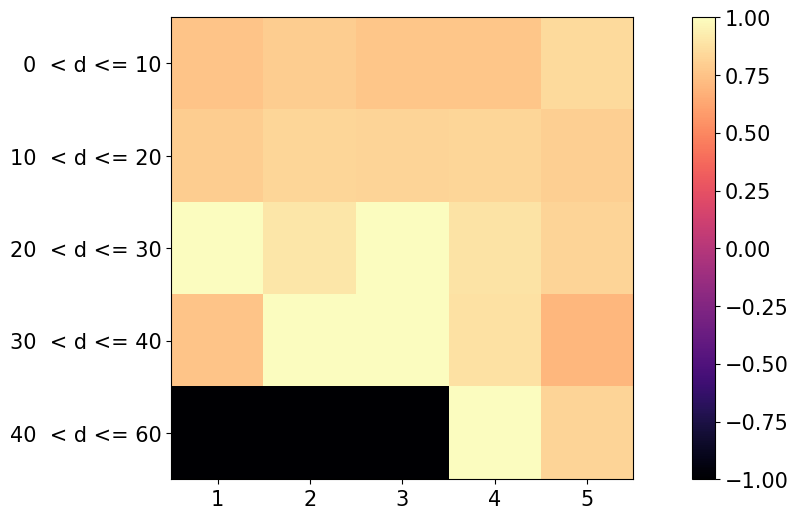

In [56]:
small_d = [0, 10, 20, 30, 40 ] # mm
large_d = [10, 20, 30, 40, 60] # mm
for i in range(5):
    for r in range(5,55,5):
        heatmap(excel_sheet_mname=models[i], fixed_axis = 'radius', fixed_axis_parameter=r, figname=models[i]+'_radius_'+f'r{r}'+'_score-VS-nodule_size', figaxes = ['score', 'nodule size'], arr_shape=(5, 5))

Unnamed: 0  radius  score    nodule size     accuracy
0             0       5      1   0  < d <= 10            1
1             1       5      1  10  < d <= 20  0.980198026
2             2       5      1  20  < d <= 30        0.625
3             3       5      1  30  < d <= 40            1
4             4       5      1  40  < d <= 60            o
..          ...     ...    ...            ...          ...
245         245      50      5   0  < d <= 10  0.613861382
246         246      50      5  10  < d <= 20  0.524752498
247         247      50      5  20  < d <= 30  0.683168292
248         248      50      5  30  < d <= 40  0.613861382
249         249      50      5  40  < d <= 60  0.643564343

[250 rows x 5 columns]

# Get Reduced Heatmaps

In [53]:
def heatmap(excel_sheet_mname, reduced_axis = 'score', figaxes = ['radius', 'nodule size'], arr_shape=(5, 10)):
    m1 = pd.read_csv('A:/MSc/Pulmonary Nodules/Results/All/reduced/'+excel_sheet_mname+'_reduced_'+reduced_axis+'.csv')
    arr = np.zeros(arr_shape)
    acc = list(m1['accuracy'])
    n=0
    for i in range(arr_shape[1]):
        for j in range(arr_shape[0]):
            arr[j][i] = acc[n]
            n += 1

    plt.figure(figsize=(15,6))
    plt.imshow(arr, cmap ="magma")
    plt.colorbar().ax.tick_params(labelsize=15)

    # Assigning labels of x-axis 
    # according to dataframe
    plt.xticks(range(len(np.unique(np.array(list(m1[figaxes[0]]))))), np.unique(np.array(list(m1[figaxes[0]]))))

    # Assigning labels of y-axis 
    # according to dataframe
    plt.yticks(range(len(np.unique(np.array(list(m1[figaxes[1]]))))), np.unique(np.array(list(m1[figaxes[1]]))))
    plt.tick_params(axis='both', which='major', labelsize=15)
    #plt.savefig('A:/MSc/Pulmonary Nodules/figures' + '/All/reduced/' +excel_sheet_mname+'_reduced_'+reduced_axis+ '.png', dpi = 500)
    # Displaying the figure
    plt.show()
    return arr

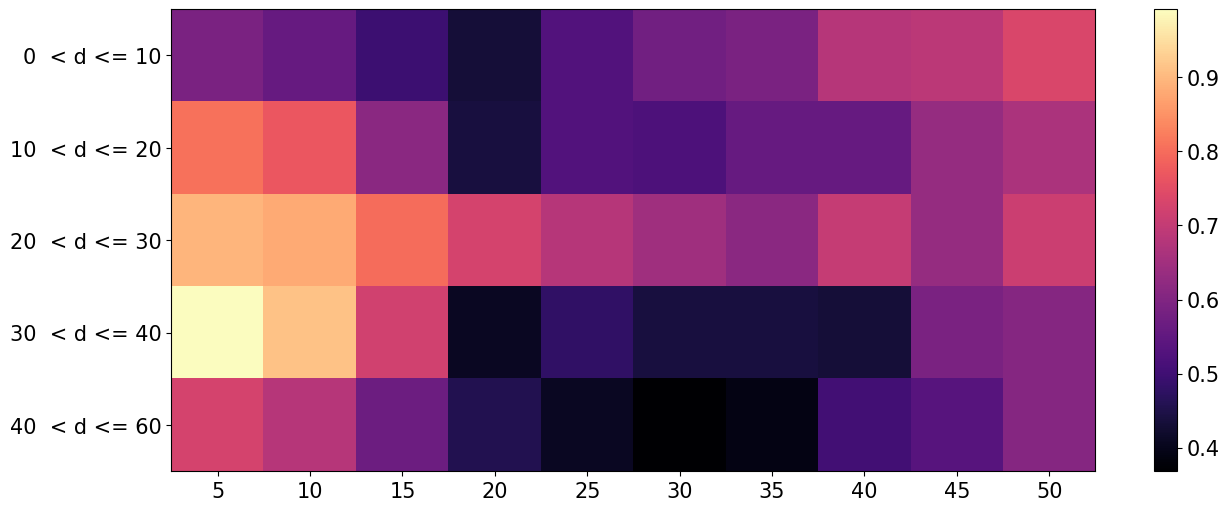

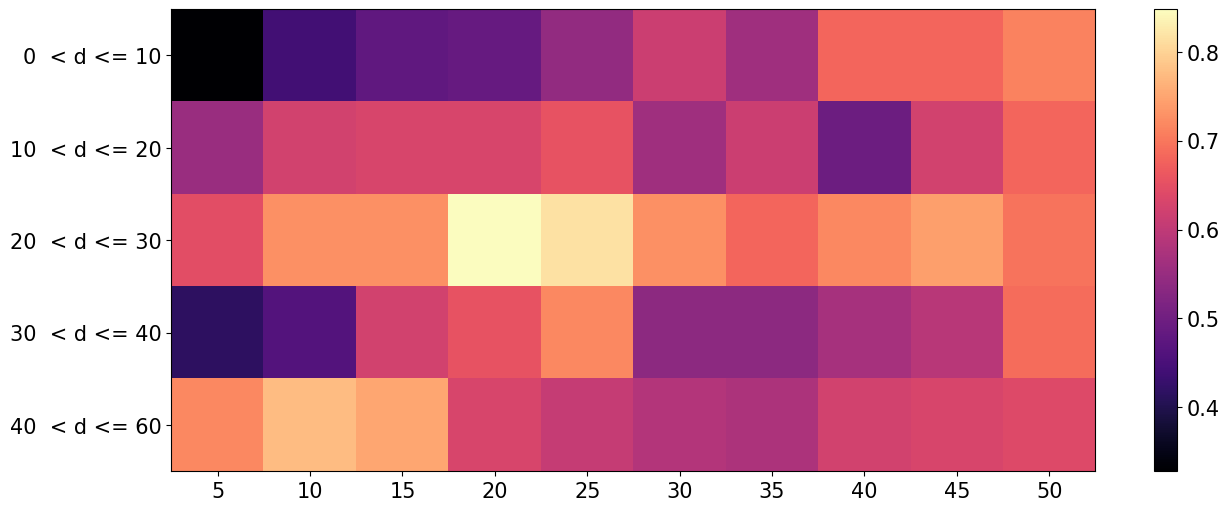

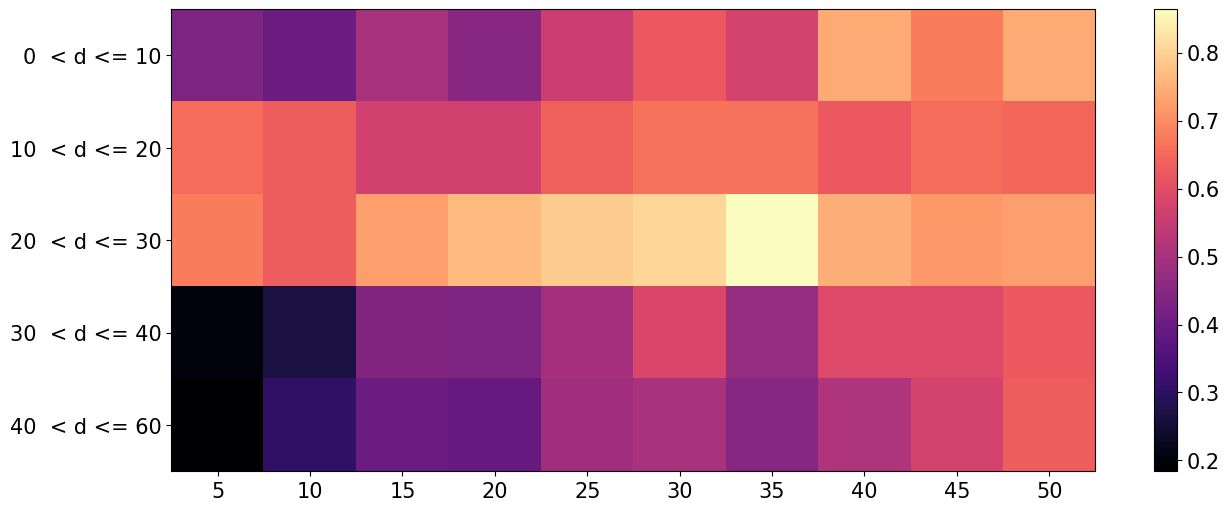

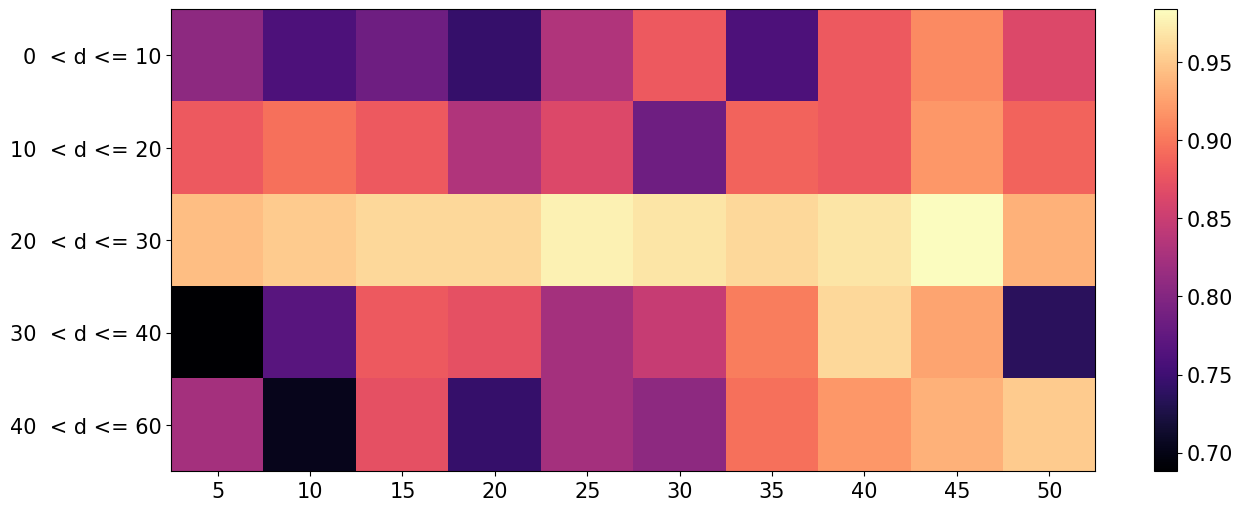

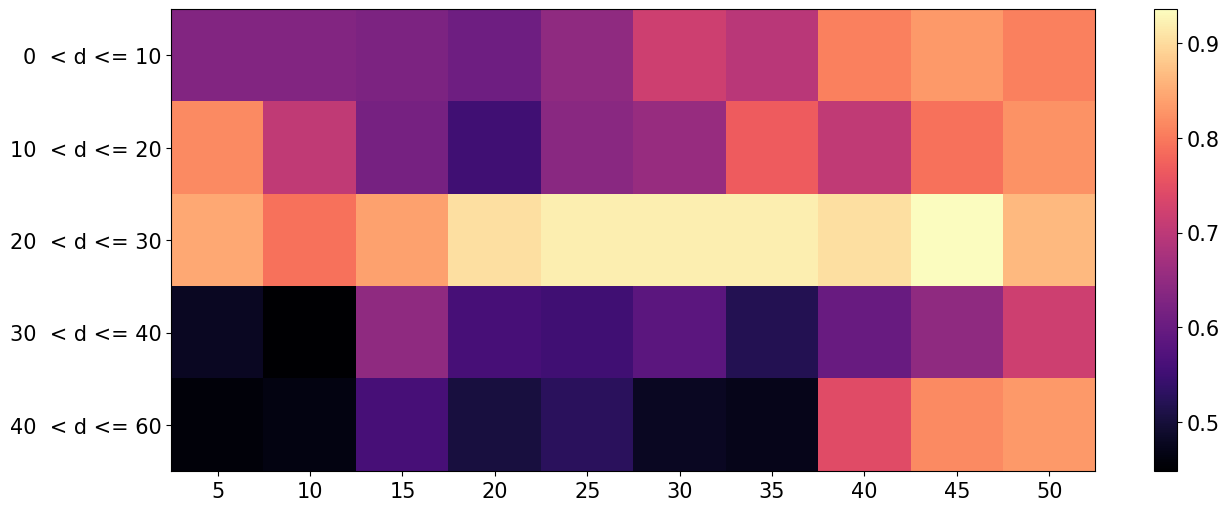

In [35]:
for model in models:
    heatmap(model, reduced_axis = 'score', figaxes = ['radius', 'nodule size'], arr_shape=(5, 10))

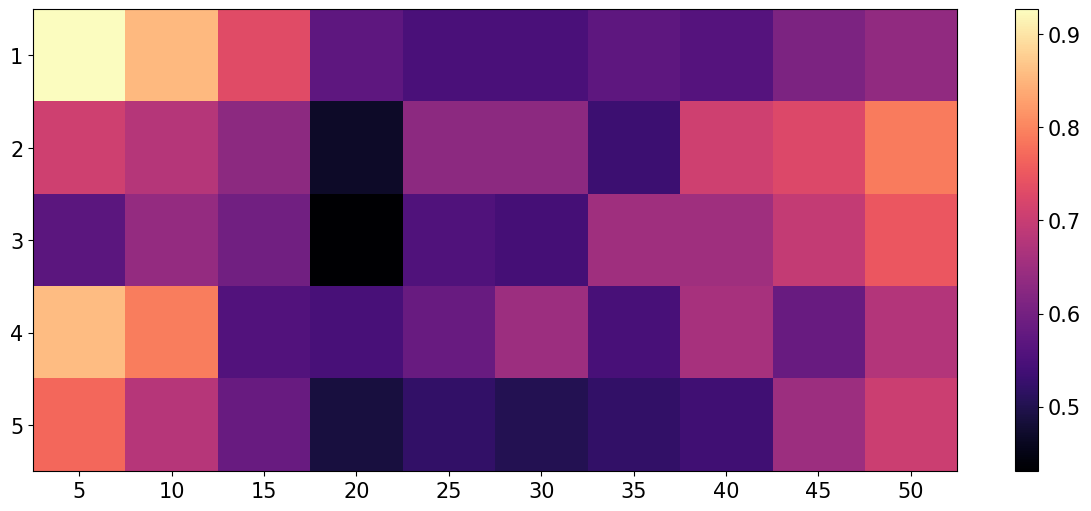

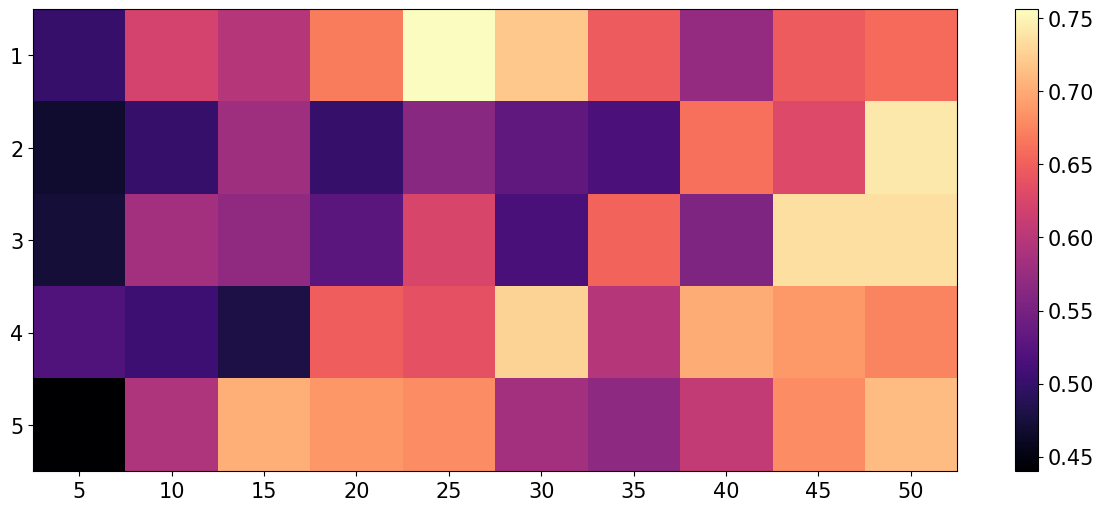

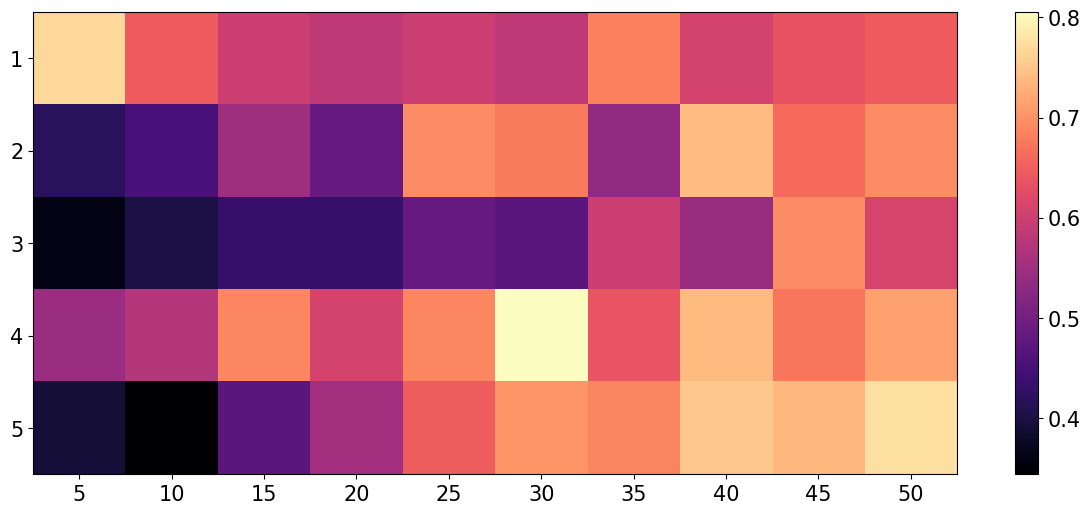

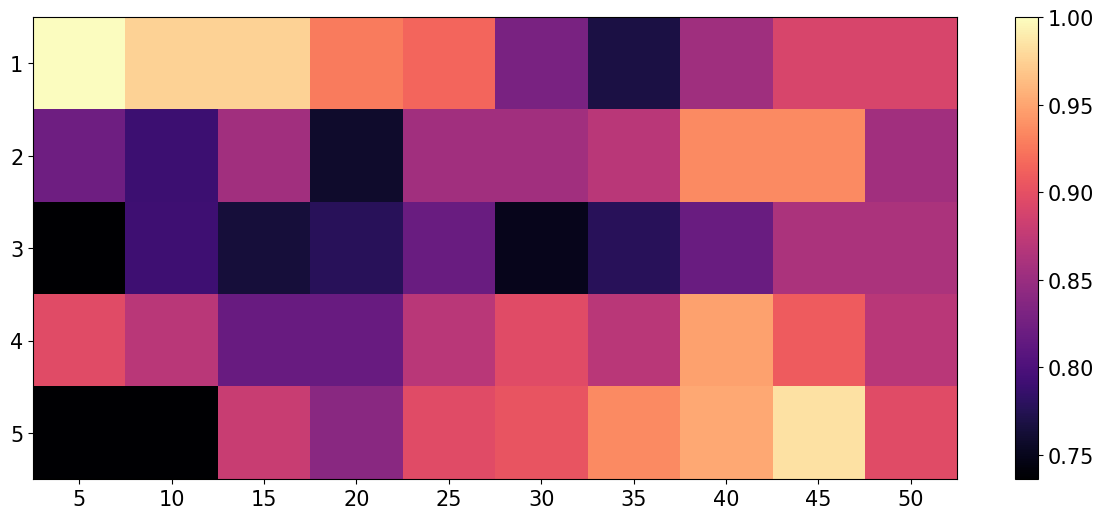

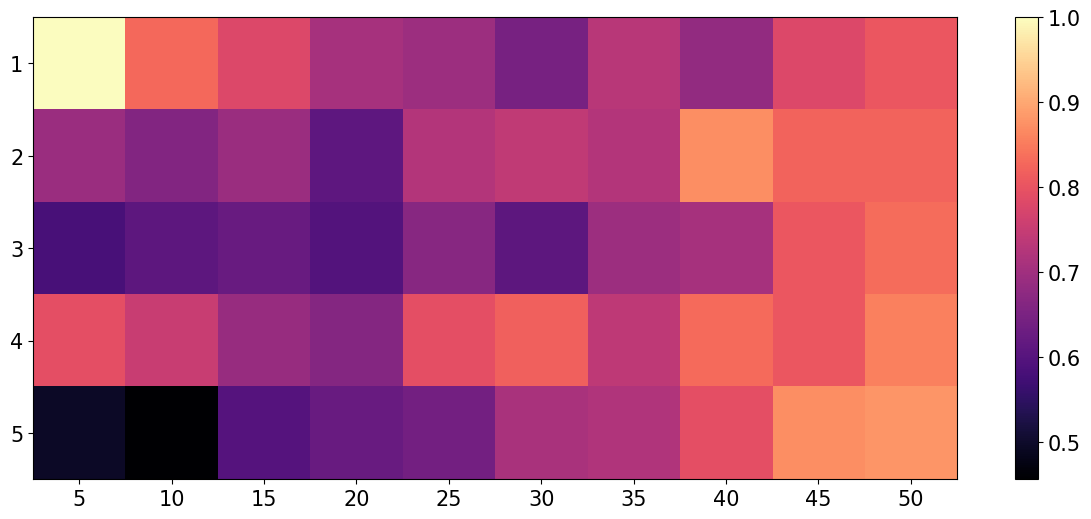

In [36]:
for model in models:
    heatmap(model, reduced_axis = 'nodule_size', figaxes = ['radius', 'score'], arr_shape=(5, 10))

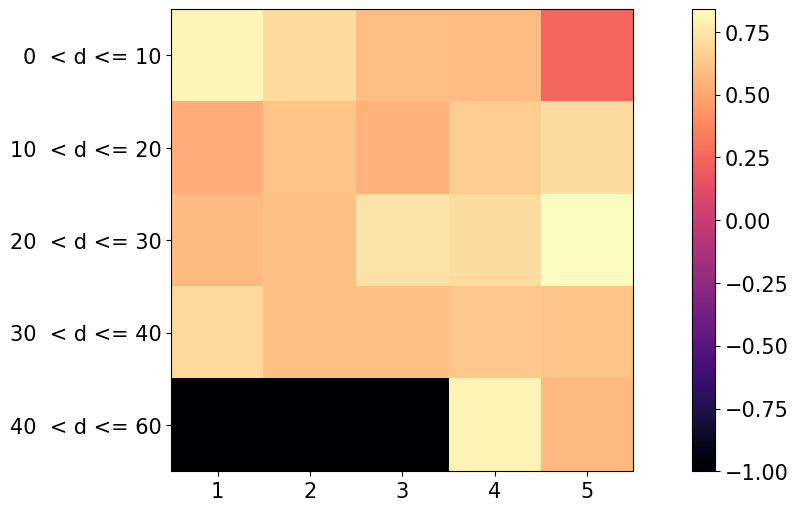

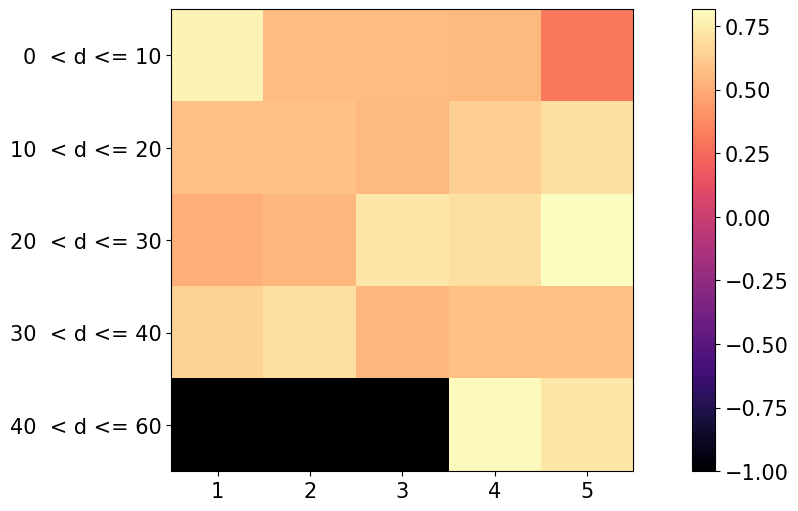

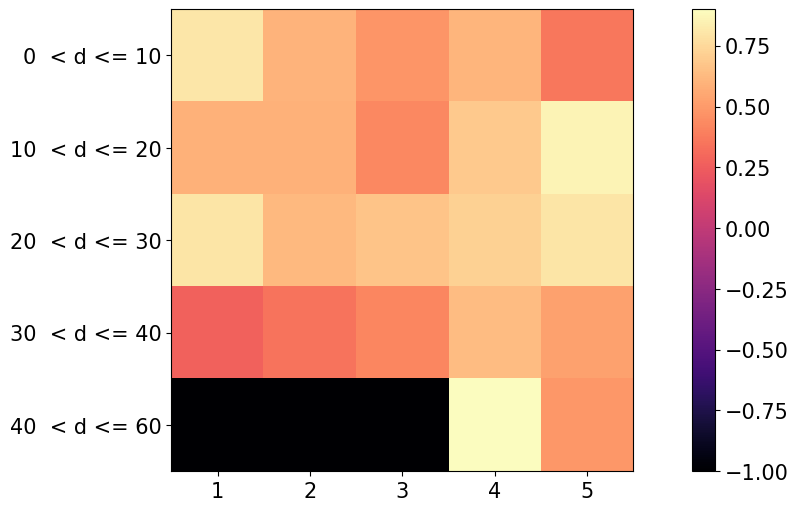

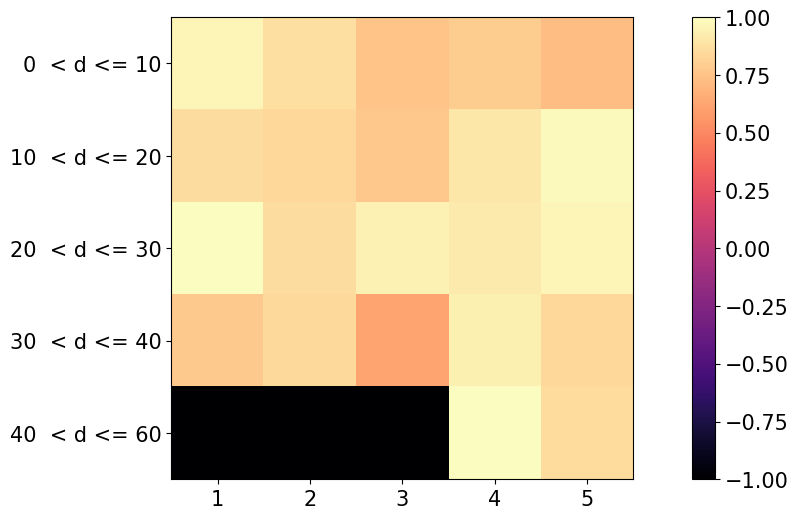

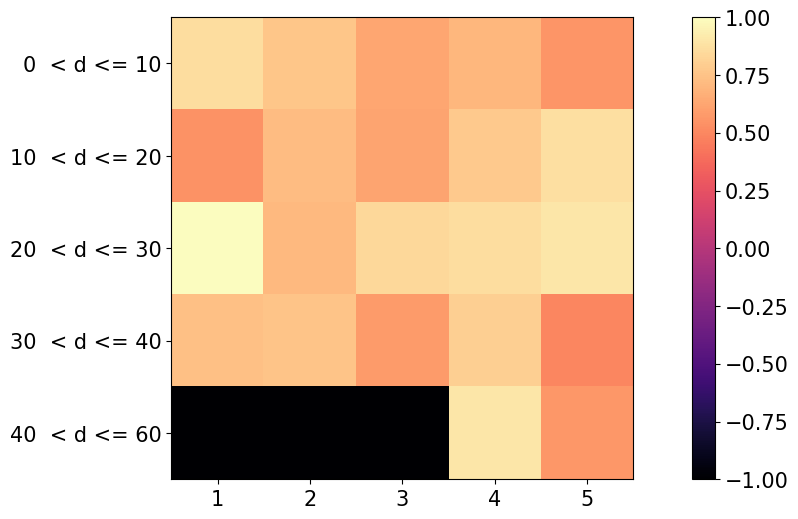

In [51]:
for model in models:
    heatmap(model, reduced_axis = 'radius', figaxes = ['score', 'nodule size'], arr_shape=(5, 5))

# Paper Figures

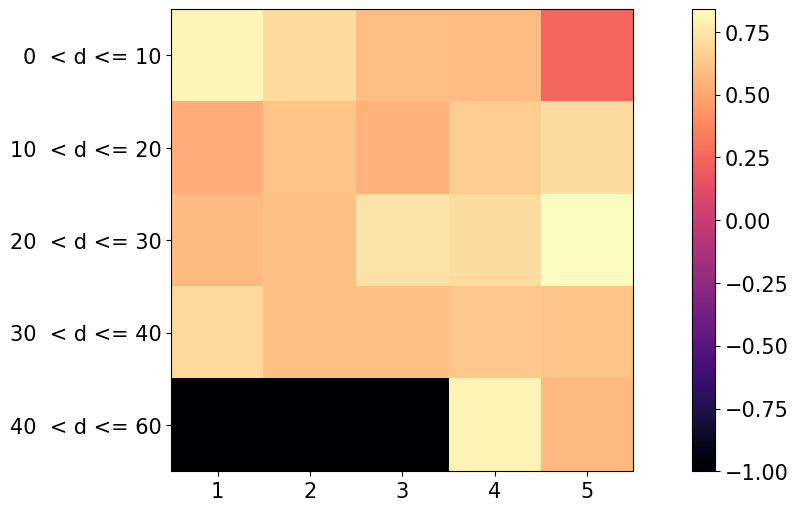

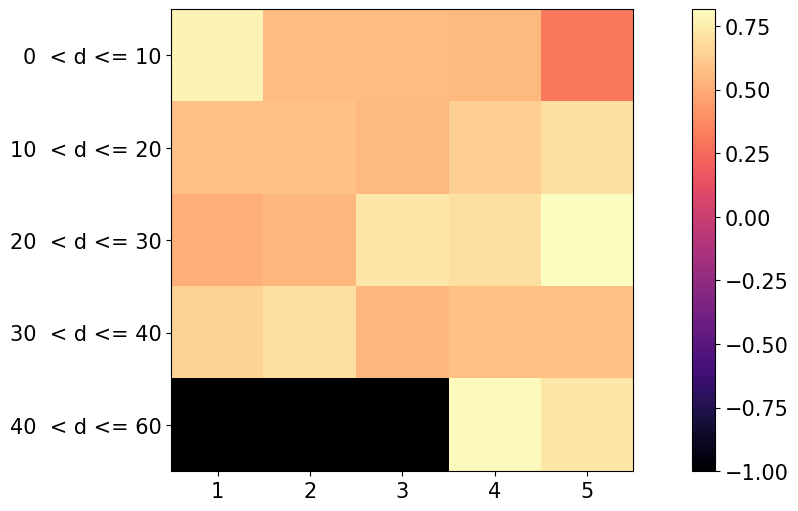

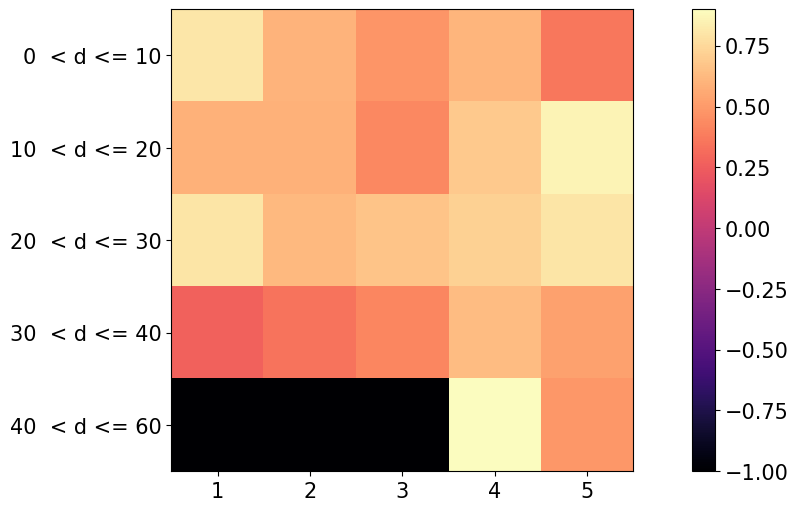

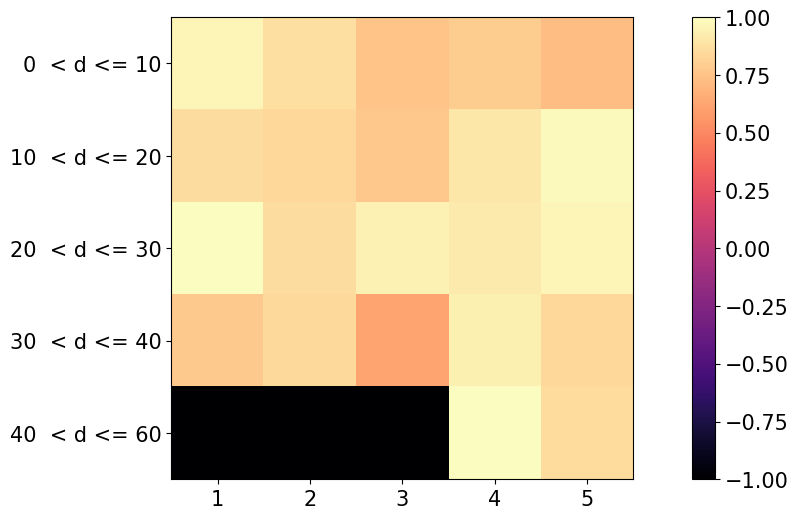

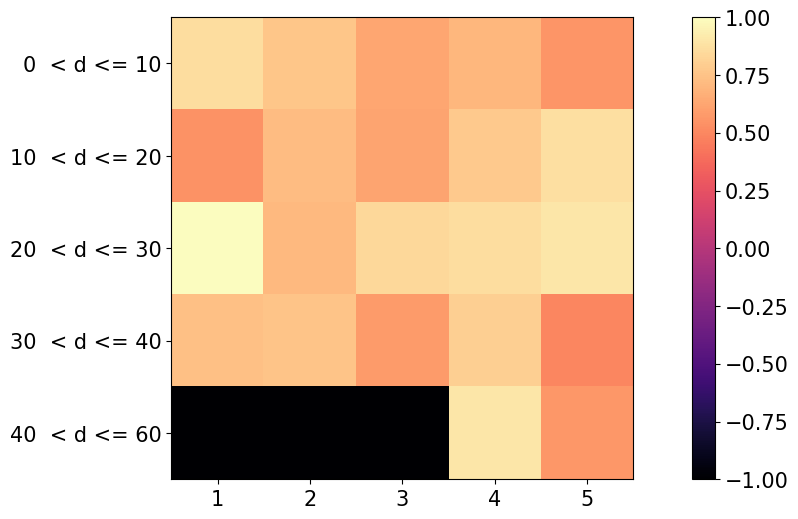

In [54]:
arrays = []
for model in models:
    arrays.append(heatmap(model, reduced_axis = 'radius', figaxes = ['score', 'nodule size'], arr_shape=(5, 5)))

In [56]:
arrays[-2][:-1,:]

array([[0.96399999, 0.86799997, 0.75199997, 0.796     , 0.73199999],
       [0.86000001, 0.83600003, 0.77200001, 0.90399998, 0.98400003],
       [1.        , 0.86000001, 0.9470588 , 0.91666669, 0.96799999],
       [0.77499998, 0.85000002, 0.62      , 0.9375    , 0.83999997]])

In [60]:
def plot_heatmap(arr, xticks, yticks, savename):
    plt.figure(figsize=(15,6))
    plt.imshow(arr, cmap ="magma")
    plt.colorbar().ax.tick_params(labelsize=15)

    # Assigning labels of x-axis 
    # according to dataframe
    plt.xticks(range(len(np.unique(np.array(xticks)))), np.unique(np.array(xticks)))

    # Assigning labels of y-axis 
    # according to dataframe
    plt.yticks(range(len(np.unique(np.array(yticks)))), np.unique(np.array(yticks)))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.savefig('A:/MSc/Pulmonary Nodules/figures/final_figures/' +savename+ '.png', dpi = 500)
    # Displaying the figure
    #plt.show()

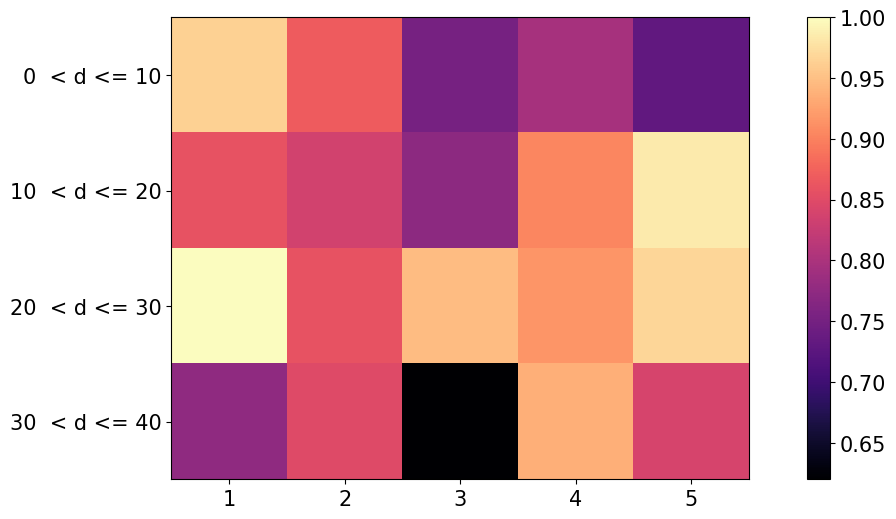

In [61]:
plot_heatmap(arrays[-2][:-1,:], range(1,6), [f'{d1}  < d <= {d2}' for d1, d2 in zip([0, 10, 20 ,30], [10, 20, 30, 40])], 'figure4')

## Malignancy score vs Accuracy

In [65]:
models_path = r'A:\\MSc\\Pulmonary Nodules\\models\\'
models = ['normal_vs_malignant_r10', 'normal_vs_malignant_r20', 'normal_vs_malignant_r30', 'normal_vs_malignant_r40', 'normal_vs_malignant_r50']
results = {}
for m_name in tqdm(models, total = len(models)):
        results[m_name] = {'radius' : [],
                     'score' : [],
                     'nodule size': [],
                     'accuracy' : []}
        _path = models_path + m_name
        m = tf.keras.models.load_model(_path)
        for score in [1,2,3,4,5]:
            data_df = data_info.loc[data_info['malignancy_score']==score]
            test_data = load_data(data_df, score, 1, radius = 'all_radii', sizes = 'all_sizes')
            if len(test_data) == 0:
                results[m_name]['radius'].append('all')
                results[m_name]['score'].append(score)
                results[m_name]['nodule size'].append('all')
                results[m_name]['accuracy'].append('-1')
                continue
            accuracy = m.evaluate(test_data)
            results[m_name]['radius'].append('all radii')
            results[m_name]['score'].append(score)
            results[m_name]['nodule size'].append('all sizes')
            results[m_name]['accuracy'].append(accuracy[1])

  0%|          | 0/5 [00:00<?, ?it/s]

3ash ya paytor
16/16 [==============================] - 2s 104ms/step - loss: 3.6018 - accuracy: 0.6720
3ash ya paytor
16/16 [==============================] - 2s 104ms/step - loss: 3.6647 - accuracy: 0.6760
3ash ya paytor
16/16 [==============================] - 2s 103ms/step - loss: 5.3122 - accuracy: 0.5800
3ash ya paytor
16/16 [==============================] - 2s 104ms/step - loss: 5.9494 - accuracy: 0.5480
3ash ya paytor
16/16 [==============================] - 2s 104ms/step - loss: 4.0081 - accuracy: 0.6200
3ash ya paytor
16/16 [==============================] - 2s 105ms/step - loss: 2.1006 - accuracy: 0.6760
3ash ya paytor
16/16 [==============================] - 2s 104ms/step - loss: 2.7157 - accuracy: 0.6360
3ash ya paytor
16/16 [==============================] - 2s 104ms/step - loss: 2.9095 - accuracy: 0.5800
3ash ya paytor
16/16 [==============================] - 2s 105ms/step - loss: 3.1193 - accuracy: 0.5960
3ash ya paytor
16/16 [==============================] - 2s 106ms

In [66]:
for model in models:
    pd.DataFrame(results[model]).to_csv('A:/MSc/Pulmonary Nodules/Results/acc_' + model + '_at all scores.csv')